# Introduction

This is a supervised machine learning project in which I attempt to predict the occurence of severe weather in the wet/summer season in the vicinity of Cape Canaveral using the 1500Z/11:00am ET daily weather balloon. This balloon is a good predictor, since it samples the environment a few hours before thunderstorms typically develop. From the weather balloon data, we can get many candidate predictors, to include parameters that measure moisture, instability and wind speed/direction. From these features, we will create and test several binary classifition models, where the label is a 1 or a 0 on whether Severe Weather occured within 30 nm of Cape Canaveral Space Force Station/Kennedy Space Center. I decided to subset the data to just include days with offshore wind direction to help balance the dataset and since this is the main forecast challenge. Ultimately, our goal is to get a reliable probabilistic forecast for severe weather based on this balloon data.

# Code Preamble

In [1]:
!pip install -U shap

In [2]:
# -*- coding: utf-8 -*-


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from patsy import dmatrices

from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print("\n---Libraries loaded")



---Libraries loaded


# Data Understanding/Preparation

Don't run this cell if files not saved in google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data preparation

Update below with file path where you saved the file

In [4]:

soundingfile = '/content/drive/My Drive/15Z_KXMR_soundingparameters.csv'
#plfile = '/content/drive/My Drive/precipltng_2008_2022.csv'
severe_reports = '/content/drive/My Drive/NWS_severe_reports_2008_2023.csv'
sounding_severe = '/content/drive/My Drive/sounding_severe_30nm_2005_2022.csv'
severe_days = '/content/drive/My Drive/severedates_30nm_2005_2023.csv'

In [5]:
df1 = pd.read_csv(soundingfile)
df2 = pd.read_csv(severe_days)
#df3 = pd.read_csv(severe_reports)


df2.head(10)
#print(df2.head(10))
#print(df3.head(10))

Date  Severe
0   5/1/05       0
1   5/2/05       0
2   5/3/05       0
3   5/4/05       0
4   5/5/05       0
5   5/6/05       0
6   5/7/05       0
7   5/8/05       0
8   5/9/05       0
9  5/10/05       0

In [6]:


import pandas as pd
df1['Datetime'] = pd.to_datetime(df1[['Year', 'Month', 'Day']])


In [7]:
df1.head(10)

Platform     Lat    Lon  Elevation (m)  Year  Month  Day  Hour (UTC)  Minute  Sounding Base (ft)  Sounding Top (ft)  Sounding Levels  CAPE (J/kg)  700-500mb Lapse Rate (C/ft)  850-500mb Lapse Rate (C/ft)  LI (C)  KI (C)  Thompson Index (C)  Total Totals (C)  T 1000mb (C)  T 850mb (C)  T 700mb (C)  T 500mb (C)  Convective Temperature (C)  1000-700mb RH (%)  PWAT (mm)  700-500mb Average RH (%)  Surface-700mb Average RH (%)  Surface-700mb Average Wind Speed (Kts)  1000-700mb Average U-Wind Component (Kts)  1000-700mb Average V-Wind Component (Kts)  1000-850mb Average U-Wind Component (Kts)  1000-850mb Average V-Wind Component (Kts)  850-700mb Average U-Wind Component (Kts)  850-700mb Average V-Wind Component (Kts)  850-500mb Average U-Wind Component (Kts)  850-500mb Average V-Wind Component (Kts)  850mb Average U-Wind Component (Kts)  850mb Average V-Wind Component (Kts)  700mb Average U-Wind Component (Kts)  700mb Average V-Wind Component (Kts)  500mb Average U-Wind Component (Kts)  \
0     KXMR  28.467 -80.55              3  1990      1    1          12       0                16.4            93999.3               68     0.107058                    -0.001576                    -0.001607     4.2     5.7                 1.5              33.4          18.8         15.0          6.2         -7.7                        17.9               55.1       24.9                      11.0                          56.9                                    29.3                                       26.5                                       13.1                                       25.4                                       14.4                                      27.4                                      12.0                                      33.0                                      13.9                                  29.0                                  10.6                                  31.7                                  14.8                                  41.8   
1     KXMR  28.467 -80.55              3  1990      1    2          17       0                16.4            54363.5               67     0.000000                    -0.001896                    -0.001169    13.1   -10.6               -23.7              28.5          16.6          7.4          7.6         -9.1                         3.0               42.9       17.3                      20.4                          43.9                                     8.6                                       -3.9                                       -3.0                                       -8.3                                       -1.4                                      -0.2                                      -4.3                                      12.5                                      -5.3                                   8.0                                   0.0                                   5.4                                  -4.5                                  36.4   
2     KXMR  28.467 -80.55              3  1990      1    3          12       0                16.4            54199.5               80     0.477133                    -0.001967                    -0.001847     7.7   -17.9               -25.6              22.2          19.2         16.0          7.2        -10.1                        12.8               41.3       19.6                      11.3                          43.0                                     8.9                                       -3.0                                       -0.4                                       -9.9                                        4.2                                       2.8                                      -4.2                                      10.8                                       0.9                                  -3.3                                   4.8                                   8.4                                  -3.1                                  30.8   
3 

In [8]:
#only include rows that are in the months May through September, inclusive

df1 = df1[(df1['Month'] >= 5) & (df1['Month'] <= 9)]


In [9]:


df2['Date'] = pd.to_datetime(df2['Date'])


<ipython-input-9-feb01113be37>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Date'] = pd.to_datetime(df2['Date'])


In [10]:
df2.head(10)

Date  Severe
0 2005-05-01       0
1 2005-05-02       0
2 2005-05-03       0
3 2005-05-04       0
4 2005-05-05       0
5 2005-05-06       0
6 2005-05-07       0
7 2005-05-08       0
8 2005-05-09       0
9 2005-05-10       0

In [11]:
#remove all rows before the year 2005. This is where we have reliable severe report data

df1 = df1[df1['Year'] >= 2005]


In [12]:
#Insert the df2[Severe] column to df1 where df1[Datetime] = df2[Date]

import pandas as pd
df1 = pd.merge(df1, df2[['Date', 'Severe']], left_on='Datetime', right_on='Date', how='left')
df1.drop('Date', axis=1, inplace=True)


In [13]:
#find how many rows have an Na or inf in the Severe column

import numpy as np
# Count NaNs in 'Severe' column
nan_count = df1['Severe'].isna().sum()

# Count infinities in 'Severe' column
inf_count = np.isinf(df1['Severe']).sum()

print("Number of NaNs in 'Severe' column:", nan_count)
print("Number of infinities in 'Severe' column:", inf_count)


Number of NaNs in 'Severe' column: 0
Number of infinities in 'Severe' column: 0


In [14]:
#download df1 as a csv

#from google.colab import files
#df1.to_csv('df1.csv', index=False)
#files.download('df1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#In each column header in df, remove the text that is in the parentheses, and the parentheses themselves

df1.columns = [col.split(' (')[0] for col in df1.columns]


In [18]:
df1

Platform        Lat    Lon  Elevation  Year  Month  Day  Hour  Minute  Sounding Base  Sounding Top  Sounding Levels         CAPE  700-500mb Lapse Rate  850-500mb Lapse Rate   LI    KI  Thompson Index  Total Totals  T 1000mb  T 850mb  T 700mb  T 500mb  Convective Temperature  1000-700mb RH  PWAT  700-500mb Average RH  Surface-700mb Average RH  Surface-700mb Average Wind Speed  1000-700mb Average U-Wind Component  1000-700mb Average V-Wind Component  1000-850mb Average U-Wind Component  1000-850mb Average V-Wind Component  850-700mb Average U-Wind Component  850-700mb Average V-Wind Component  850-500mb Average U-Wind Component  850-500mb Average V-Wind Component  850mb Average U-Wind Component  850mb Average V-Wind Component  700mb Average U-Wind Component  700mb Average V-Wind Component  500mb Average U-Wind Component  500mb Average V-Wind Component  250mb Average U-Wind Component  250mb Average V-Wind Component  0-6km Shear  0-3km Storm Relative Helicity  Wet Bulb Zero Level  \
0        KXMR  28.480000 -80.55          5  2005      5    1    16       0           16.4       85000.0              124   651.067640             -0.001604             -0.001962 -2.7  32.6            35.3          44.4      23.8     18.2      4.6     -9.5                    18.0           68.5  37.8                  46.2                      68.7                              23.3                                 15.7                                 16.1                                 14.7                                 24.2                                16.5                                 9.1                                18.5                                 4.9                            14.9                            17.7                            12.1                            12.1                            33.5                            -5.9                            50.8                            18.5    38.915677                           30.3              12526.2   
1        KXMR  28.480000 -80.55          5  2005      5    2    15       0           16.4      102526.2              104  1236.944904             -0.001537             -0.001711 -2.5  31.1            33.6          44.8      21.8     14.6      4.0     -9.5                    20.1           88.1  40.7                  37.1                      88.1                              10.8                                  9.9                                  1.0                                  3.0                                 -1.4                                15.9                                 3.1                                24.0                                 4.2                             5.0                            -0.4                            21.2                             5.7                            26.1                            15.1                            74.1                            13.1    39.512584                           -2.9              10876.7   
2        KXMR  28.480000 -80.55          5  2005      5    3    15       0           16.4      102362.2              129   189.091421             -0.002120             -0.001889 -1.5  17.1            18.6          47.0      22.0     13.6      5.6    -12.9                    14.6           56.2  29.4                  33.8                      56.6                              14.2                                 10.5                                  0.3                                 -0.2                                 -1.8                                19.7                                 2.1                                21.7                                 2.8                            13.9                            -1.2                            15.4                             4.1                            31.9                            -8.6                            62.0                            16.6    52.522557                           -9.5               8641.4   
3        

In [16]:

columns = ['Platform', 'Year', 'Month', 'Elevation', 'Day', 'Hour', 'Minute', 'Sounding Base', 'Sounding Top', 'Sounding Levels', 'Bulk Richardson Number']
df1.drop(columns, inplace=True, axis=1)

df1.head(10)
print("WET SEASON")

df1.head(150)

WET SEASON


Lat    Lon         CAPE  700-500mb Lapse Rate  850-500mb Lapse Rate   LI    KI  Thompson Index  Total Totals  T 1000mb  T 850mb  T 700mb  T 500mb  Convective Temperature  1000-700mb RH  PWAT  700-500mb Average RH  Surface-700mb Average RH  Surface-700mb Average Wind Speed  1000-700mb Average U-Wind Component  1000-700mb Average V-Wind Component  1000-850mb Average U-Wind Component  1000-850mb Average V-Wind Component  850-700mb Average U-Wind Component  850-700mb Average V-Wind Component  850-500mb Average U-Wind Component  850-500mb Average V-Wind Component  850mb Average U-Wind Component  850mb Average V-Wind Component  700mb Average U-Wind Component  700mb Average V-Wind Component  500mb Average U-Wind Component  500mb Average V-Wind Component  250mb Average U-Wind Component  250mb Average V-Wind Component  0-6km Shear  0-3km Storm Relative Helicity  Wet Bulb Zero Level  Equilibrium Level  Lowest Freezing Level   -10C Level  Cloud Depth Ratio  Energy Helicity Index  \
0    28.48 -80.55   651.067640             -0.001604             -0.001962 -2.7  32.6            35.3          44.4      23.8     18.2      4.6     -9.5                    18.0           68.5  37.8                  46.2                      68.7                              23.3                                 15.7                                 16.1                                 14.7                                 24.2                                16.5                                 9.1                                18.5                                 4.9                            14.9                            17.7                            12.1                            12.1                            33.5                            -5.9                            50.8                            18.5    38.915677                           30.3              12526.2                NaN            14736.34853  19366.18336                NaN               0.123296   
1    28.48 -80.55  1236.944904             -0.001537             -0.001711 -2.5  31.1            33.6          44.8      21.8     14.6      4.0     -9.5                    20.1           88.1  40.7                  37.1                      88.1                              10.8                                  9.9                                  1.0                                  3.0                                 -1.4                                15.9                                 3.1                                24.0                                 4.2                             5.0                            -0.4                            21.2                             5.7                            26.1                            15.1                            74.1                            13.1    39.512584                           -2.9              10876.7        38954.55671            12726.96723  19329.80422           0.307443              -0.022420   
2    28.48 -80.55   189.091421             -0.002120             -0.001889 -1.5  17.1            18.6          47.0      22.0     13.6      5.6    -12.9                    14.6           56.2  29.4                  33.8                      56.6                              14.2                                 10.5                                  0.3                                 -0.2                                 -1.8                                19.7                                 2.1                                21.7                                 2.8                            13.9                            -1.2                            15.4                             4.1                            31.9                            -8.6                            62.0                            16.6    52.522557                           -9.5               8641.4        28383.60971            12647.99873  17866.63443           0.327136              -0.011227   
3    28.48 -80.55  1103.453883     

In [17]:
df1.drop(['Lat', 'Lon'], inplace=True, axis=1)

In [18]:
#make all the column names in df have no spaces within their string

df1.columns = [column.replace(' ', '_') for column in df1.columns]

In [19]:
df1.drop(['Datetime'], inplace=True, axis=1)
df1.drop(['Cloud_Depth_Ratio', 'Equilibrium_Level'], inplace=True, axis=1)

In [ ]:
#Save df1 as a csv to my drive named "15Zsounding_severe_30nm_2005_2023.csv"

#df1.to_csv('/content/drive/My Drive/15Zsounding_severe_30nm_2005_2023.csv', index=False)

In [20]:
df1.head(10)

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate   LI    KI  Thompson_Index  Total_Totals  T_1000mb  T_850mb  T_700mb  T_500mb  Convective_Temperature  1000-700mb_RH  PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level   -10C_Level  Energy_Helicity_Index  Microburst_Day_Potential_Index     WINDEX  Severe
0   651.067640             -0.001604             -0.001962 -2.7  32.6            35.3          44.4      23.8     18.2      4.6     -9.5                    18.0           68.5  37.8                  46.2                      68.7                              23.3                                 15.7                                 16.1                                 14.7                                 24.2                                16.5                                 9.1                                18.5                                 4.9                            14.9                            17.7                            12.1                            12.1                            33.5                            -5.9                            50.8                            18.5    38.915677                           30.3              12526.2            14736.34853  19366.18336               0.123296                        0.581552   4.976881       0
1  1236.944904             -0.001537             -0.001711 -2.5  31.1            33.6          44.8      21.8     14.6      4.0     -9.5                    20.1           88.1  40.7                  37.1                      88.1                              10.8                                  9.9                                  1.0                                  3.0                                 -1.4                                15.9                                 3.1                                24.0                                 4.2                             5.0                            -0.4                            21.2                             5.7                            26.1                            15.1                            74.1                            13.1    39.512584                           -2.9              10876.7            12726.96723  19329.80422              -0.022420                        0.695409   9.944281       0
2   189.091421             -0.002120             -0.001889 -1.5  17.1            18.6          47.0      22.0     13.6      5.6    -12.9                    14.6           56.2  29.4                  33.8                      56.6                              14.2                                 10.5                                  0.3                                 -0.2                                 -1.8                                19.7                                 2.1                                21.7                                 2.8                            13.9                            -1.2                            15.4                             4.1                            31.9                            -8.6                            62.0                            16.6    52.522557                           -9.5               8641.4            12647.99873  17866.63443              -0.011227                        0.591579   9.765966       0
3  1103.453883             -0.002068             -0.001841 -4.

Data Description Table

In [21]:
df1.info()
df1.describe()
df1.isnull().sum()


#df_warm.info()
#df_warm.describe()
#df_warm.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2789 entries, 0 to 2788
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CAPE                                 2710 non-null   float64
 1   700-500mb_Lapse_Rate                 2785 non-null   float64
 2   850-500mb_Lapse_Rate                 2784 non-null   float64
 3   LI                                   2722 non-null   float64
 4   KI                                   2783 non-null   float64
 5   Thompson_Index                       2722 non-null   float64
 6   Total_Totals                         2784 non-null   float64
 7   T_1000mb                             2617 non-null   float64
 8   T_850mb                              2784 non-null   float64
 9   T_700mb                              2785 non-null   float64
 10  T_500mb                              2785 non-null   float64
 11  Convective_Temperature        

CAPE                               79
700-500mb_Lapse_Rate                4
850-500mb_Lapse_Rate                5
LI                                 67
KI                                  6
                                 ... 
-10C_Level                          2
Energy_Helicity_Index              79
Microburst_Day_Potential_Index      7
WINDEX                            117
Severe                              0
Length: 42, dtype: int64

In [22]:
rows, columns = df1.shape
cell_count = rows * columns
number_of_nulls = df1.isnull().sum().sum()
percentage_of_missing = (number_of_nulls / cell_count) * 100
print(f'Percentage of missing values: {percentage_of_missing}%')

Percentage of missing values: 1.5665283682494153%


# Data Preparation

Dealing with Null values

In [23]:
#df1['Cloud_Depth_Ratio'].fillna(0, inplace = True)
#df1['Equilibrium_Level'].fillna(0, inplace = True)
#df['Hail'].fillna(0, inplace=True)

df1.dropna(inplace = True)
df1.info()
df1.describe()
df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 2447 entries, 0 to 2787
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CAPE                                 2447 non-null   float64
 1   700-500mb_Lapse_Rate                 2447 non-null   float64
 2   850-500mb_Lapse_Rate                 2447 non-null   float64
 3   LI                                   2447 non-null   float64
 4   KI                                   2447 non-null   float64
 5   Thompson_Index                       2447 non-null   float64
 6   Total_Totals                         2447 non-null   float64
 7   T_1000mb                             2447 non-null   float64
 8   T_850mb                              2447 non-null   float64
 9   T_700mb                              2447 non-null   float64
 10  T_500mb                              2447 non-null   float64
 11  Convective_Temperature             

CAPE                              0
700-500mb_Lapse_Rate              0
850-500mb_Lapse_Rate              0
LI                                0
KI                                0
                                 ..
-10C_Level                        0
Energy_Helicity_Index             0
Microburst_Day_Potential_Index    0
WINDEX                            0
Severe                            0
Length: 42, dtype: int64

In [24]:
df1.columns = [col.split('_(')[0] for col in df1.columns]

In [25]:
df1['PWAT'] = df1['PWAT'].astype(float)
df1['PWAT'] = df1['PWAT']* 0.039370 # convert from mm to in
df1['PWAT'].describe()

count    2447.000000
mean        2.175288
std        22.537188
min        -7.732268
25%         1.488186
50%         1.767713
75%         1.976374
max      1115.438714
Name: PWAT, dtype: float64

In [26]:
# Delete rows where 'PWAT' is < 0 or > 3 (not physically possible)
df1 = df1[(df1['PWAT'] >= 0) & (df1['PWAT'] <= 3)]
df1['PWAT'].describe()

count    2425.000000
mean        1.707322
std         0.382323
min         0.370078
25%         1.492123
50%         1.767713
75%         1.972437
max         2.925191
Name: PWAT, dtype: float64

In [32]:
df1.head(10)

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate   LI    KI  Thompson_Index  Total_Totals  T_1000mb  T_850mb  T_700mb  T_500mb  Convective_Temperature  1000-700mb_RH      PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level   -10C_Level  Energy_Helicity_Index  Microburst_Day_Potential_Index     WINDEX  Severe
0   651.067640             -0.001604             -0.001962 -2.7  32.6            35.3          44.4      23.8     18.2      4.6     -9.5                    18.0           68.5  1.488186                  46.2                      68.7                              23.3                                 15.7                                 16.1                                 14.7                                 24.2                                16.5                                 9.1                                18.5                                 4.9                            14.9                            17.7                            12.1                            12.1                            33.5                            -5.9                            50.8                            18.5    38.915677                           30.3              12526.2            14736.34853  19366.18336               0.123296                        0.581552   4.976881       0
1  1236.944904             -0.001537             -0.001711 -2.5  31.1            33.6          44.8      21.8     14.6      4.0     -9.5                    20.1           88.1  1.602359                  37.1                      88.1                              10.8                                  9.9                                  1.0                                  3.0                                 -1.4                                15.9                                 3.1                                24.0                                 4.2                             5.0                            -0.4                            21.2                             5.7                            26.1                            15.1                            74.1                            13.1    39.512584                           -2.9              10876.7            12726.96723  19329.80422              -0.022420                        0.695409   9.944281       0
2   189.091421             -0.002120             -0.001889 -1.5  17.1            18.6          47.0      22.0     13.6      5.6    -12.9                    14.6           56.2  1.157478                  33.8                      56.6                              14.2                                 10.5                                  0.3                                 -0.2                                 -1.8                                19.7                                 2.1                                21.7                                 2.8                            13.9                            -1.2                            15.4                             4.1                            31.9                            -8.6                            62.0                            16.6    52.522557                           -9.5               8641.4            12647.99873  17866.63443              -0.011227                        0.591579   9.765966       0
3  1103.453883             -0.002068          

In [33]:
df1.describe()

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate           LI           KI  Thompson_Index  Total_Totals     T_1000mb      T_850mb      T_700mb      T_500mb  Convective_Temperature  1000-700mb_RH         PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level    -10C_Level  Energy_Helicity_Index  \
count  2425.000000           2425.000000           2425.000000  2425.000000  2425.000000     2425.000000   2425.000000  2425.000000  2425.000000  2425.000000  2425.000000             2425.000000    2425.000000  2425.000000           2425.000000               2425.000000                       2425.000000                          2425.000000                          2425.000000                          2425.000000                          2425.000000                         2425.000000                         2425.000000                         2425.000000                         2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000  2425.000000                    2425.000000          2425.000000            2425.000000   2425.000000            2425.000000   
mean   2058.315622             -0.001747             -0.001708    -4.964577    24.616033       29.580495     42.144330    25.956206    16.974021     8.171381    -7.310062               21.944577      67.444206     1.707322             49.083052                 67.785155                         11.106845                             1.361031                             2.680495                             0.587299                             2.699464                            2.031093                            2.663588                            3.143794                            2.245526                        1.673732                        2.800536                        3.524371                        2.452454                        4.937320                        1.276330                        8.590474                       -1.224948    13.708909                       8.622969         12505.640289           15242.822028  20821.561071               0.117503   
std    1359.748691              0.000169              0.000123     3.463790    11.529952       13.511956      5.127347     1.806893     1.759248     1.661798     1.866236                3.295825      12.903507     0.382323             22.221345                 12.518128                          5.762012                             9.227463                             7.288878                             8.983929                             7.350624                            9.897215                            7.654584                            9.984575                            7.460429                       10.332692                        8.032408                       10.998940                        8.657062                       12.310049                        9.631886                       23.781752                       17.883749    15.885325                      31.771639          1727.285489            1066.318260   1101.635106               0.384449   
min    -563.801804             -0.002467             -0.002179   -15.900000   -47.650000  

In [27]:
df1 = df1[(df1['WINDEX'] >= 0) & (df1['WINDEX'] <= 100)]
df1['WINDEX'].describe()

count    2416.000000
mean       10.280335
std         5.363381
min         0.000000
25%         7.718574
50%        11.877071
75%        14.184919
max        21.490778
Name: WINDEX, dtype: float64

**Create a df for just offshore flow days using the 1000-700mb averaged wind direction**

In [28]:
df_offshore = df1[df1['1000-700mb_Average_U-Wind_Component'] > 0]

In [29]:
df_offshore

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate   LI    KI  Thompson_Index  Total_Totals  T_1000mb  T_850mb  T_700mb  T_500mb  Convective_Temperature  1000-700mb_RH      PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level   -10C_Level  Energy_Helicity_Index  Microburst_Day_Potential_Index     WINDEX  Severe
0      651.067640             -0.001604             -0.001962 -2.7  32.6            35.3          44.4      23.8     18.2      4.6     -9.5                    18.0           68.5  1.488186                  46.2                      68.7                              23.3                                 15.7                                 16.1                                 14.7                                 24.2                                16.5                                 9.1                                18.5                                 4.9                            14.9                            17.7                            12.1                            12.1                            33.5                            -5.9                            50.8                            18.5    38.915677                           30.3              12526.2            14736.34853  19366.18336               0.123296                        0.581552   4.976881       0
1     1236.944904             -0.001537             -0.001711 -2.5  31.1            33.6          44.8      21.8     14.6      4.0     -9.5                    20.1           88.1  1.602359                  37.1                      88.1                              10.8                                  9.9                                  1.0                                  3.0                                 -1.4                                15.9                                 3.1                                24.0                                 4.2                             5.0                            -0.4                            21.2                             5.7                            26.1                            15.1                            74.1                            13.1    39.512584                           -2.9              10876.7            12726.96723  19329.80422              -0.022420                        0.695409   9.944281       0
2      189.091421             -0.002120             -0.001889 -1.5  17.1            18.6          47.0      22.0     13.6      5.6    -12.9                    14.6           56.2  1.157478                  33.8                      56.6                              14.2                                 10.5                                  0.3                                 -0.2                                 -1.8                                19.7                                 2.1                                21.7                                 2.8                            13.9                            -1.2                            15.4                             4.1                            31.9                            -8.6                            62.0                            16.6    52.522557                           -9.5               8641.4            12647.99873  17866.63443              -0.011227                        0.591579   9.765966       0
3     1103.453883             -0.0020

In [30]:

df_offshore['WINDEX'].describe()

count    1345.000000
mean       10.794512
std         5.280285
min         0.000000
25%         8.898767
50%        12.382576
75%        14.403333
max        19.823029
Name: WINDEX, dtype: float64

# EDA/Visualization

Heat Map Correlation Matrix

**Just offshore flow**

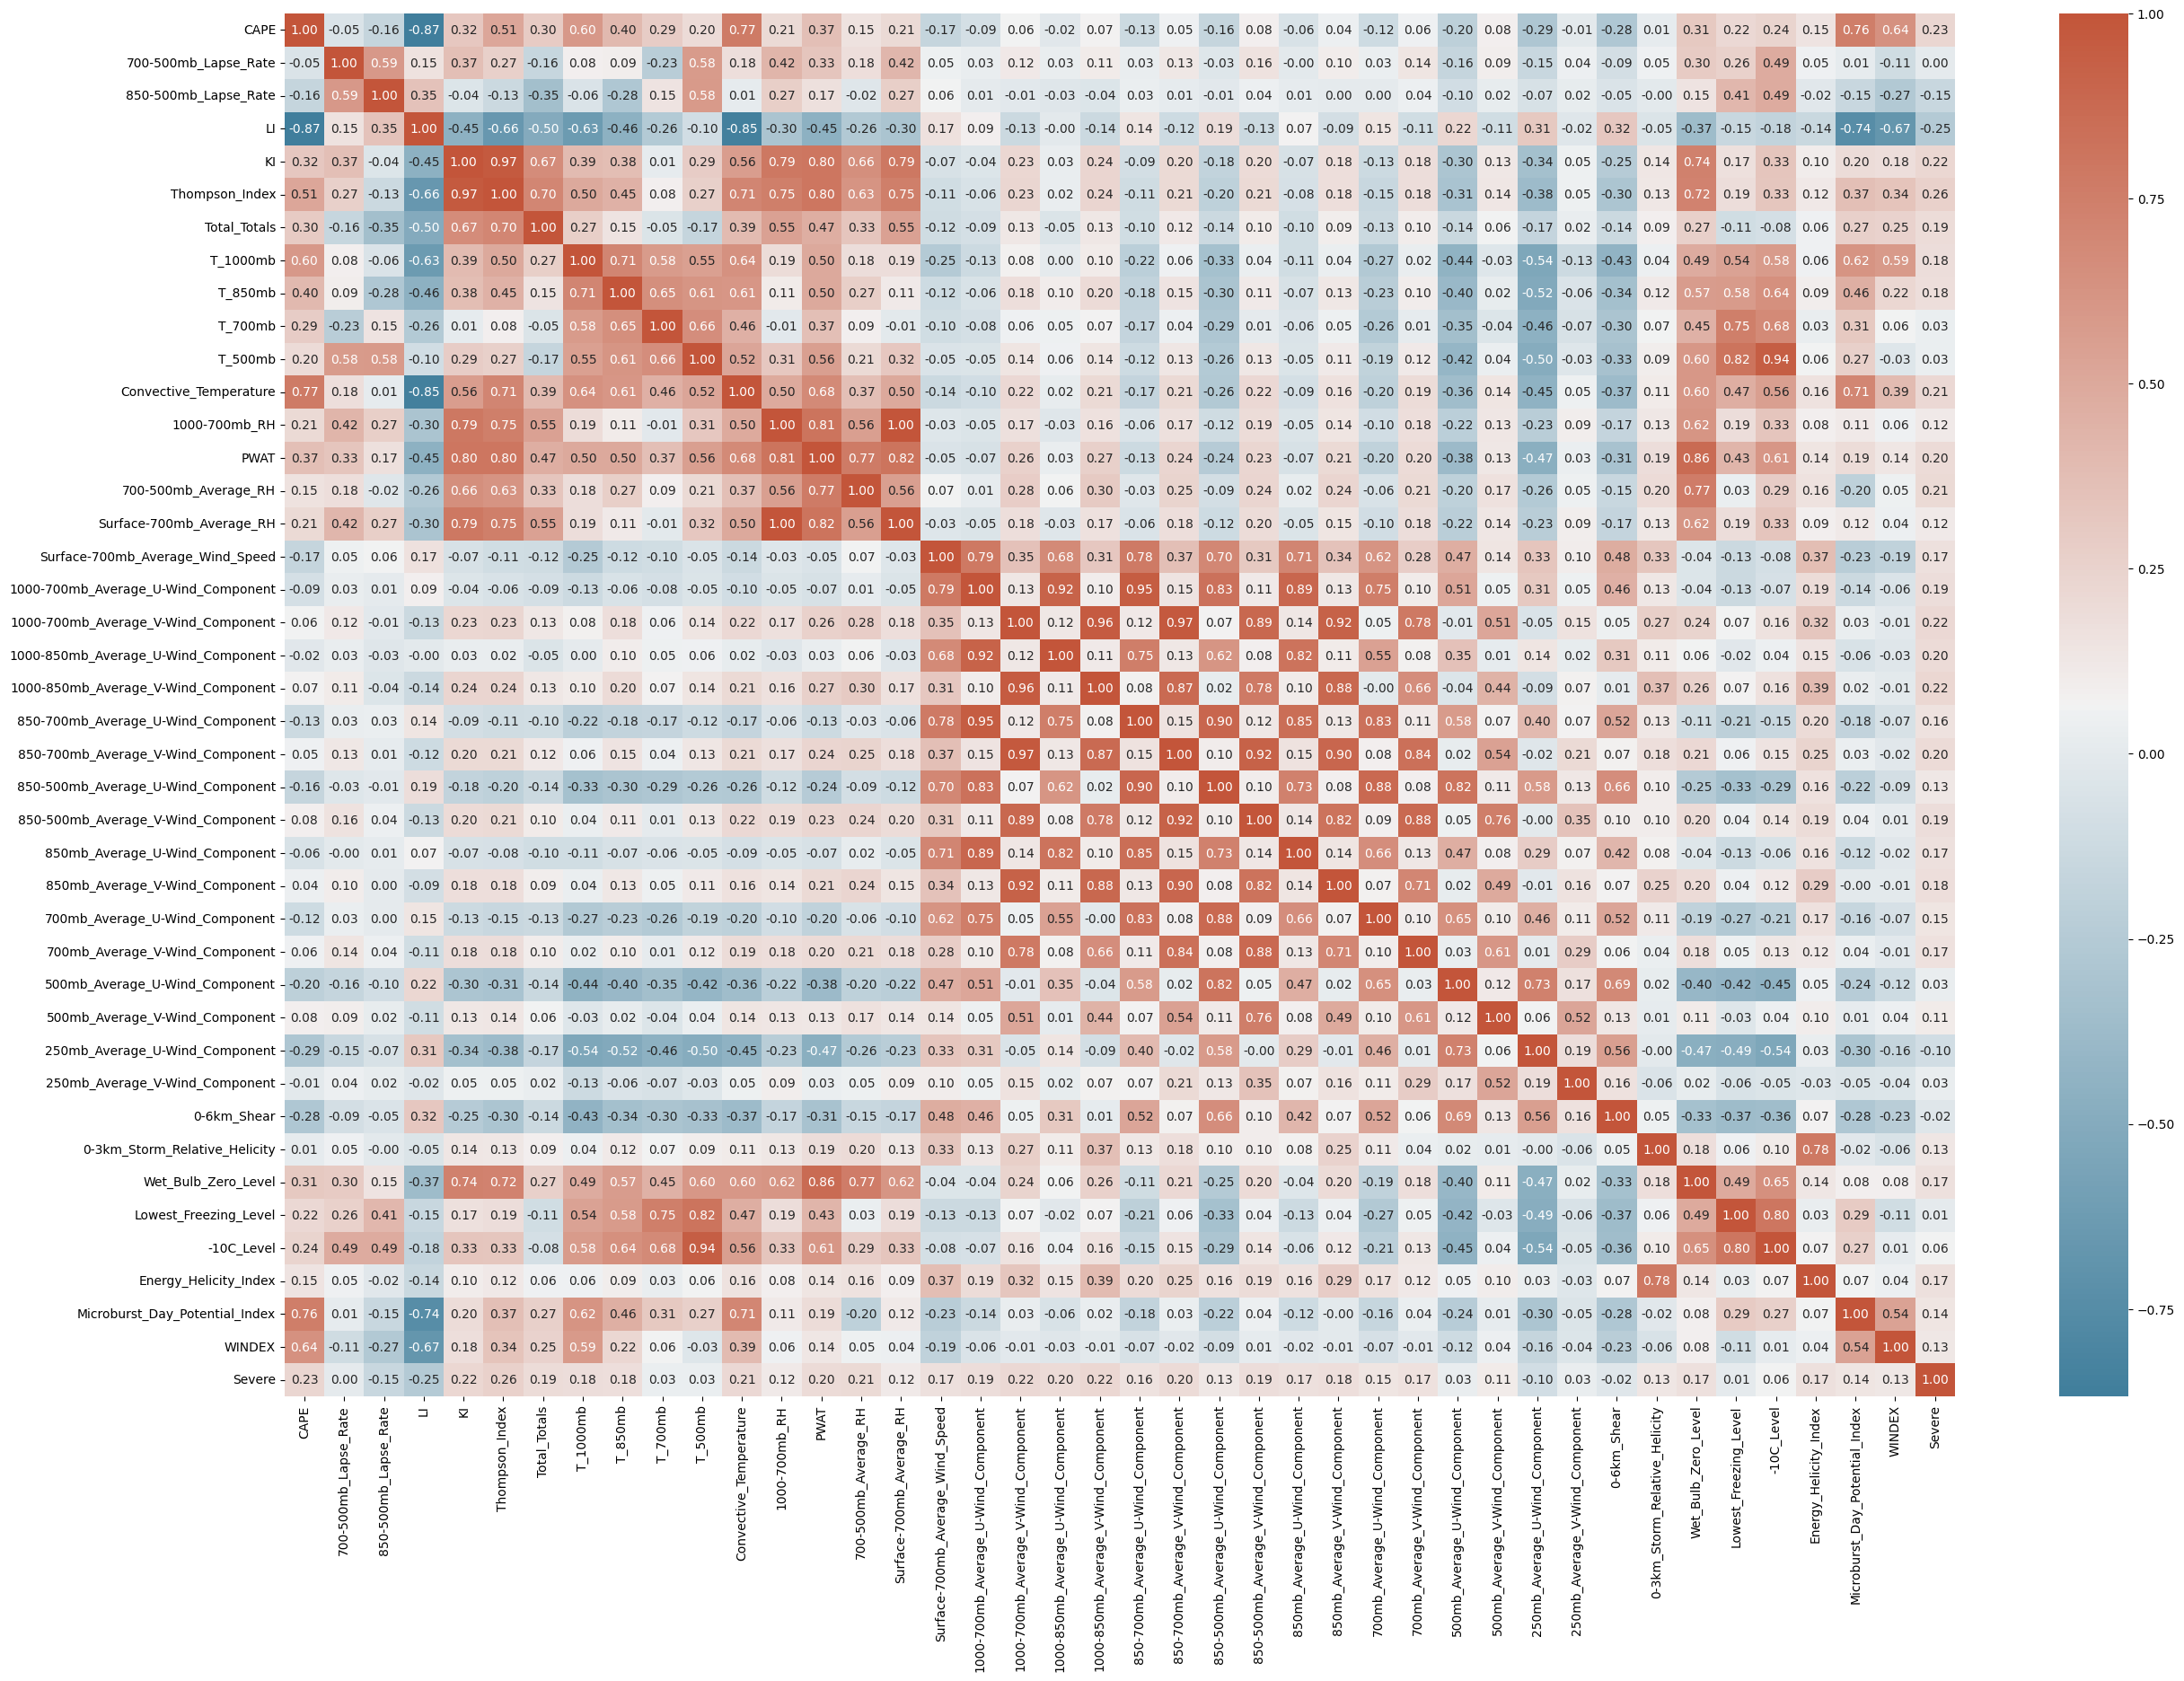

In [31]:
plt.figure(figsize=(30,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_offshore.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()

**All days, onshore and offshore flow**

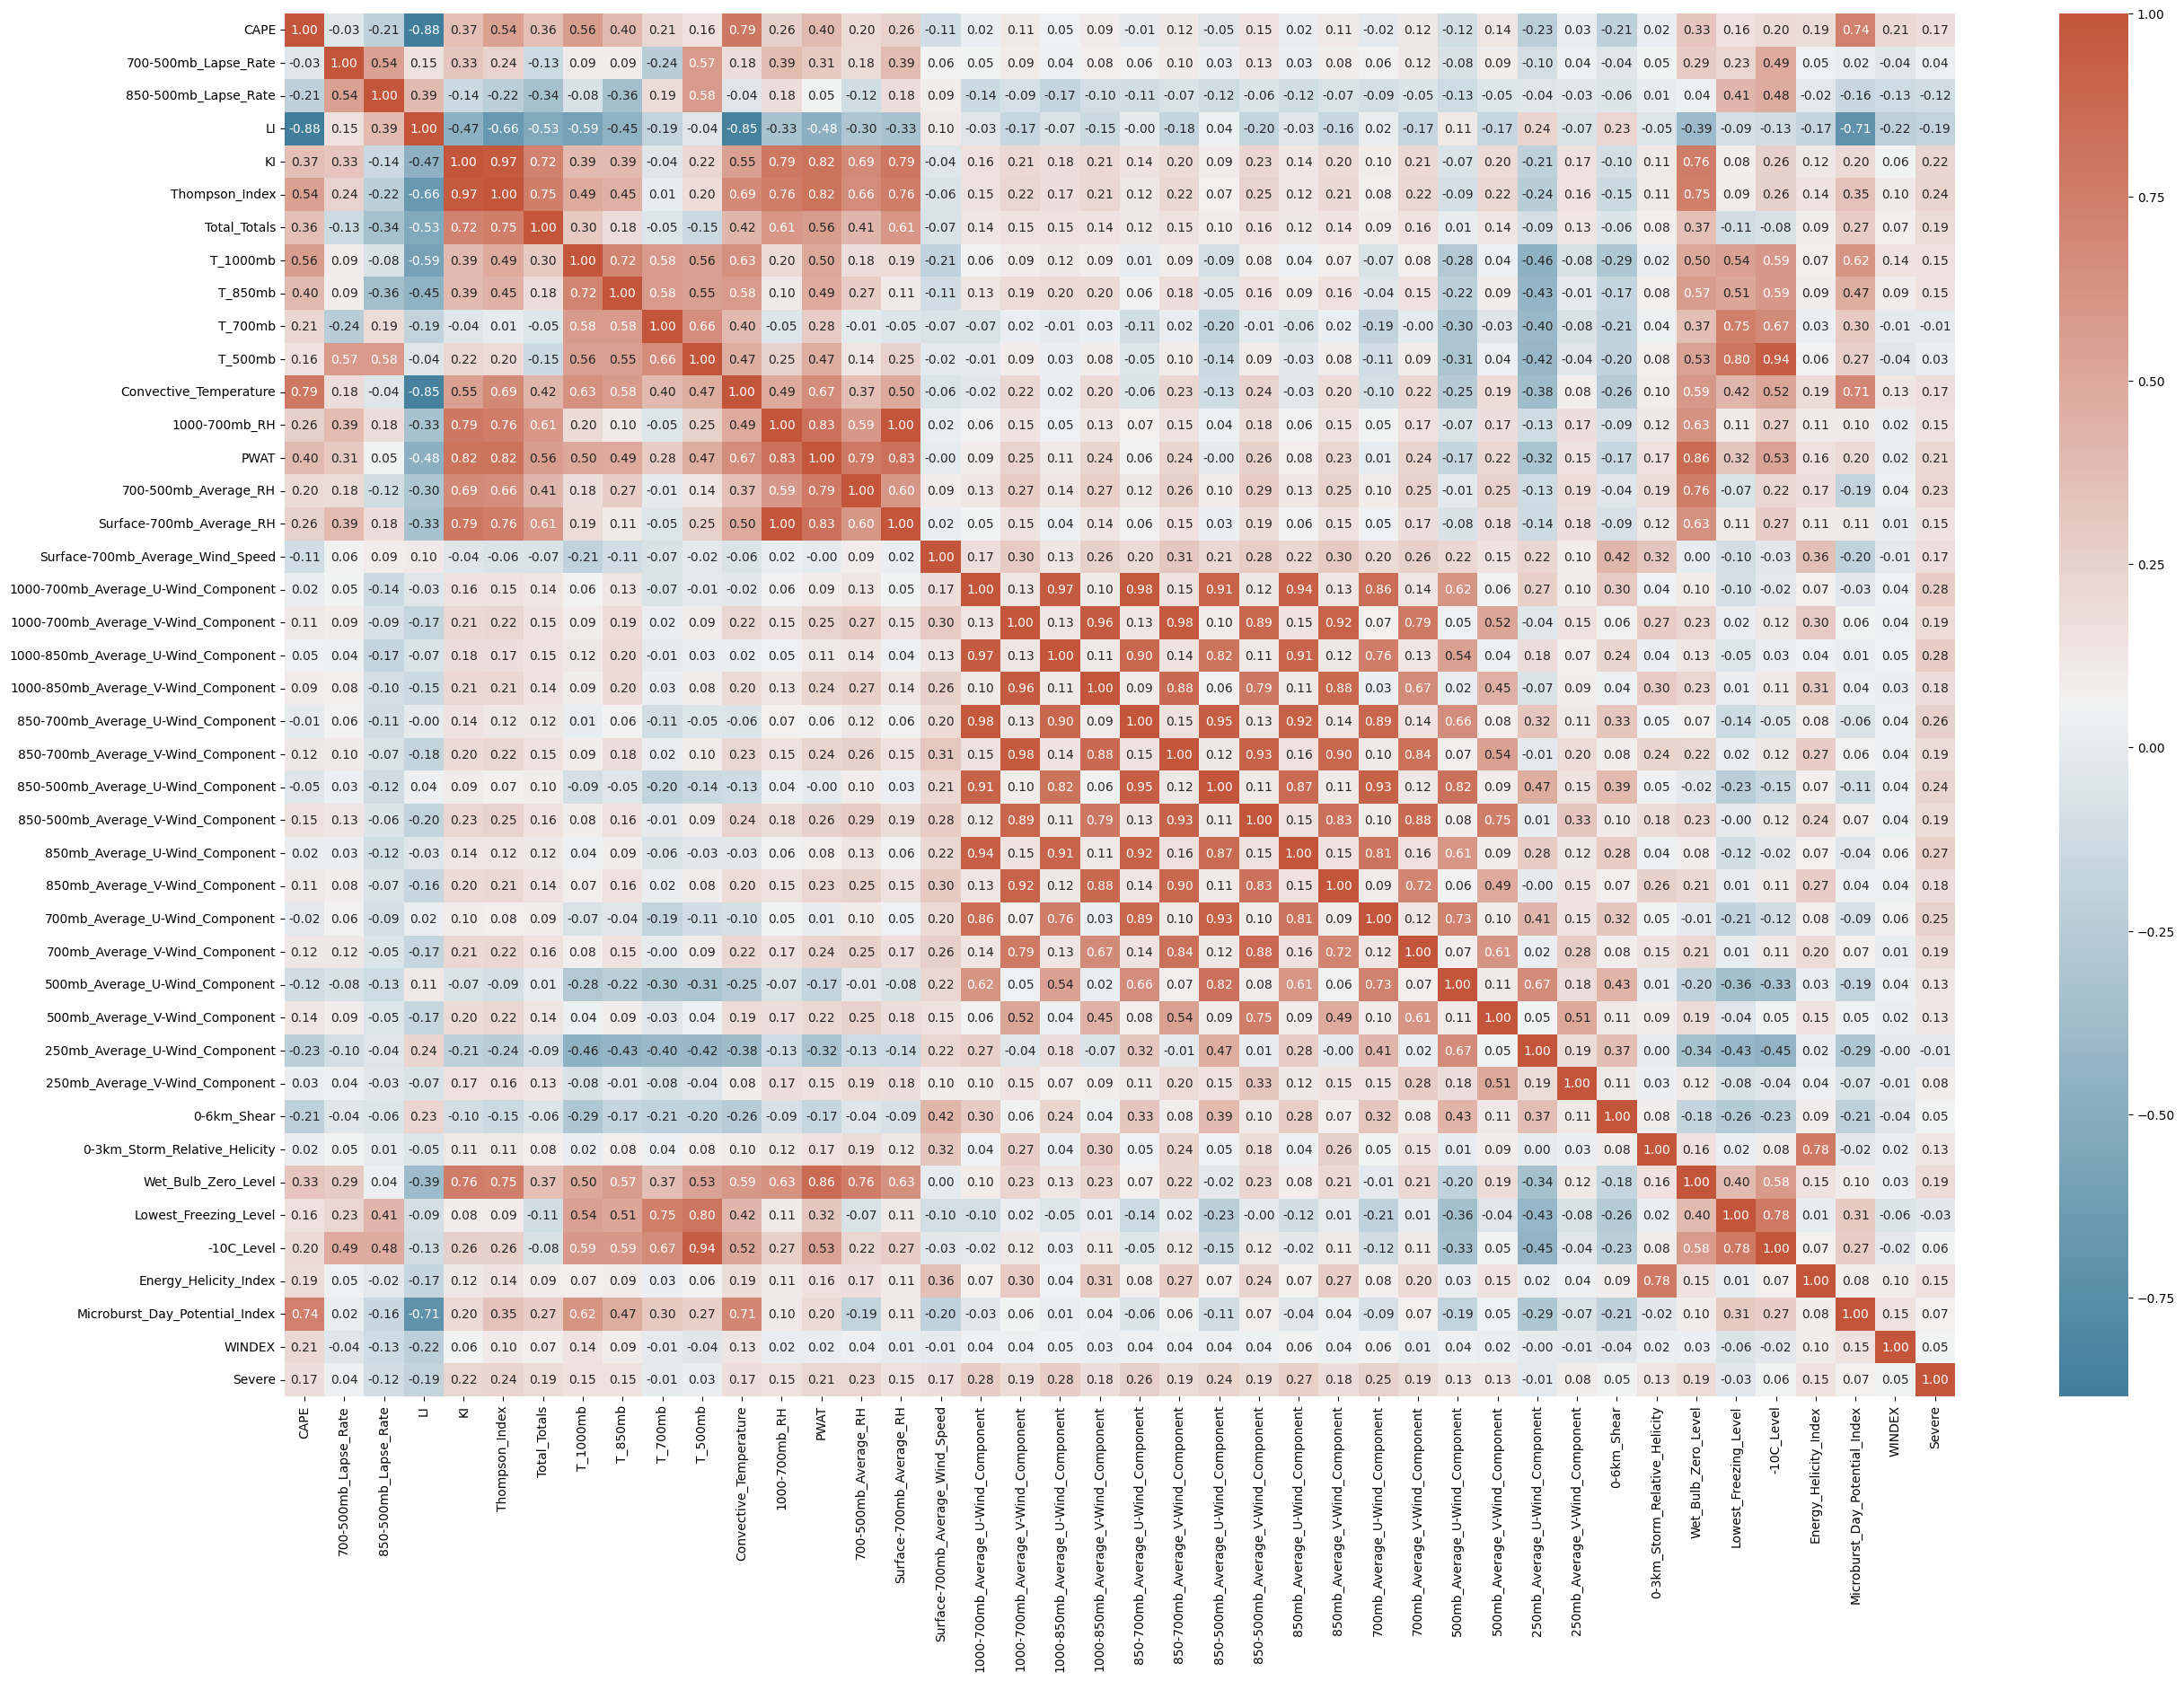

In [ ]:
plt.figure(figsize=(30,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df1.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()

Histograms of Each Variable

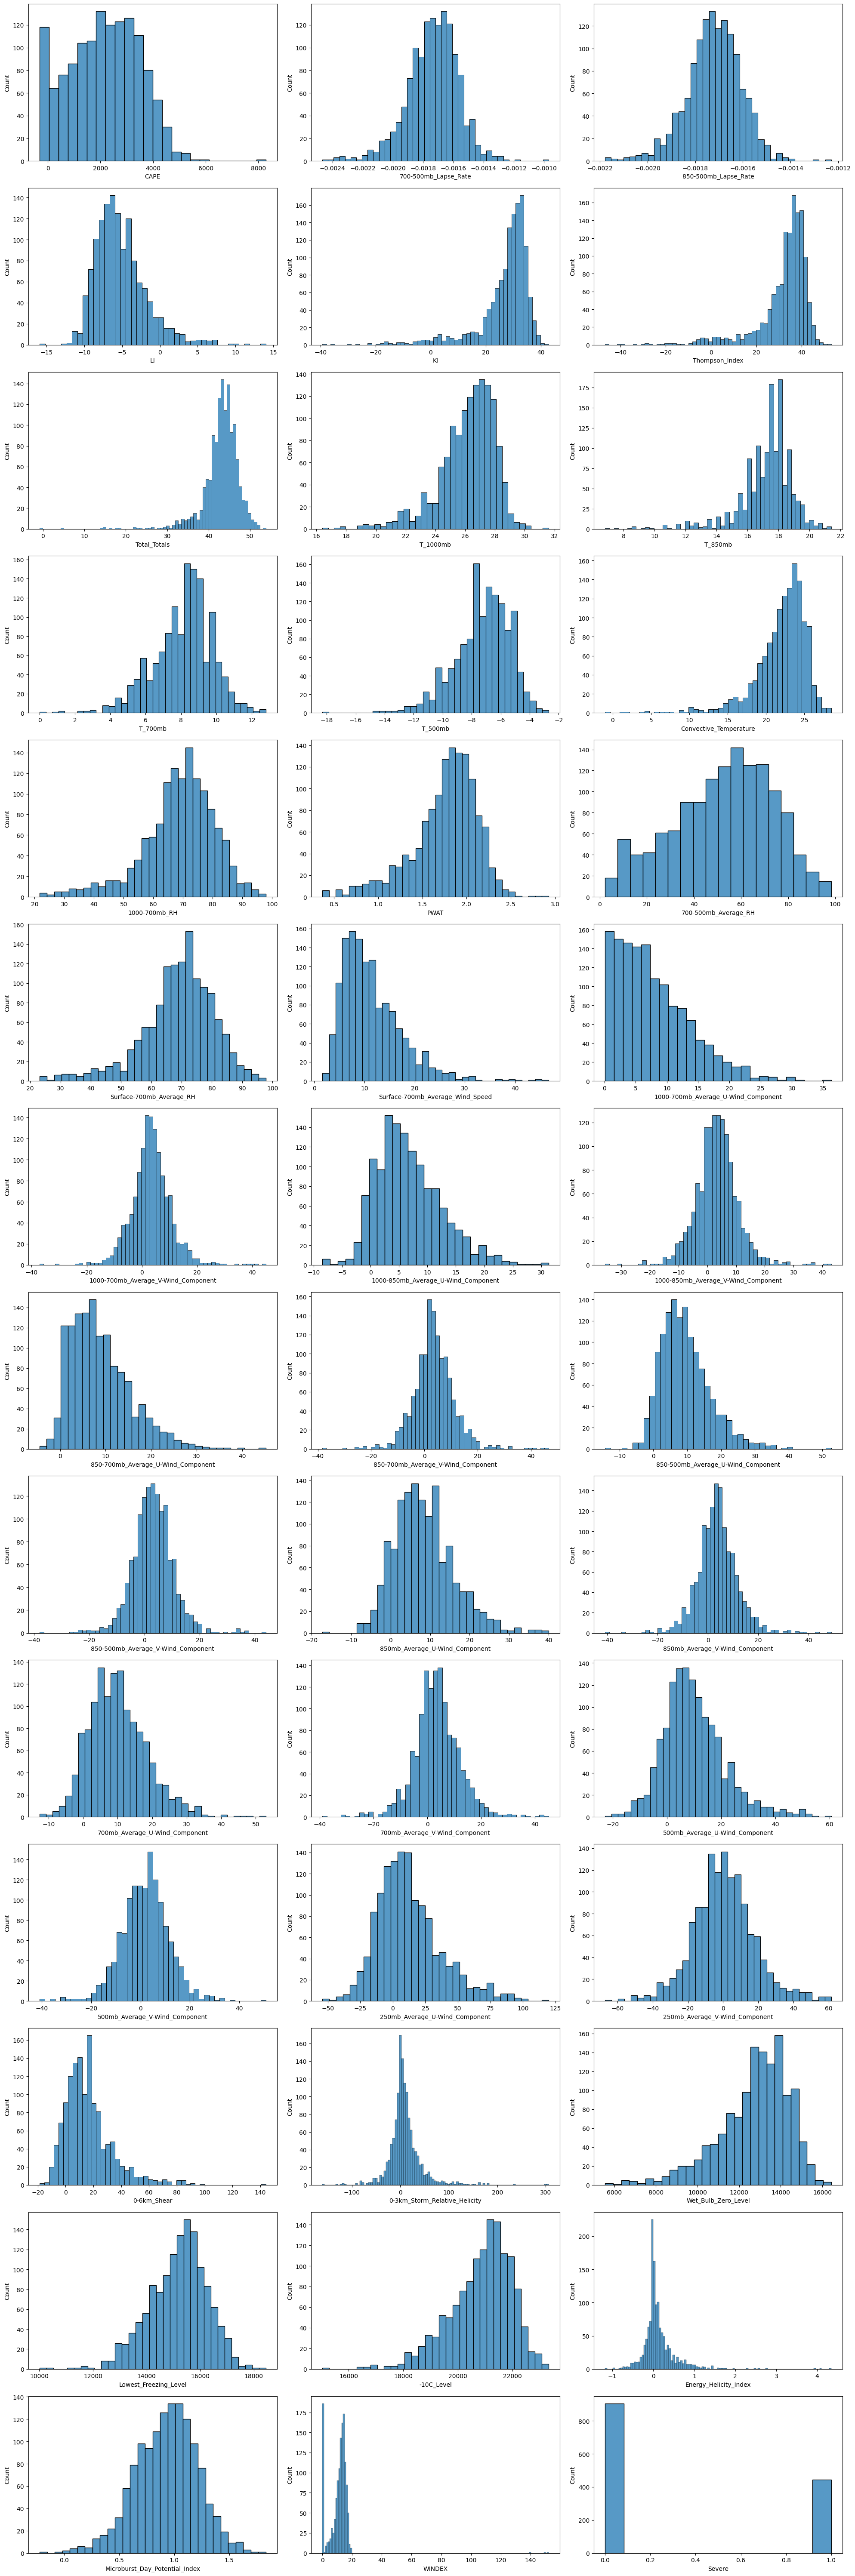

In [43]:
# Create figure and axes with 13 rows and 3 columns
fig, ax = plt.subplots(nrows=14, ncols=3, figsize=(20,60))

# Get the column names
distribution = df_offshore.columns

rows = 0
cols = 0
for i, column in enumerate(distribution):
    # Use histplot instead of displot for better axes control
    sns.histplot(data=df_offshore[column], ax=ax[rows, cols])
    cols += 1
    if cols == 3:
        cols = 0
        rows += 1

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Breakdown of Severe vs. No Severe days.dataset

In [32]:
df1['Severe'].value_counts()

Severe
0    1870
1     546
Name: count, dtype: int64

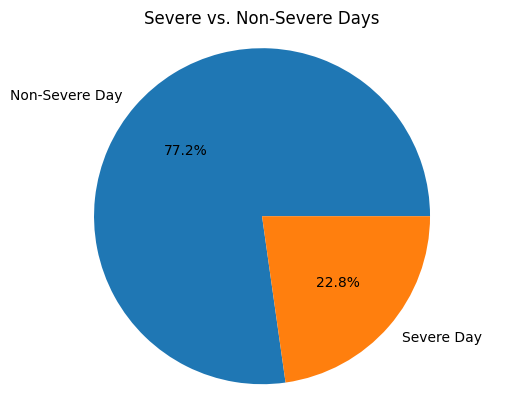

In [33]:
Tasks = [1890, 557]

my_labels = 'Non-Severe Day','Severe Day'
plt.pie(Tasks, labels=my_labels,autopct='%1.1f%%')
plt.title('Severe vs. Non-Severe Days')
plt.axis('equal')
plt.show()

In [34]:
non_severe, severe = df_offshore['Severe'].value_counts()
print(severe)
print(non_severe)

442
903


In [35]:
offshore_severe_pct = severe / (severe + non_severe)
print(offshore_severe_pct)

0.3286245353159851


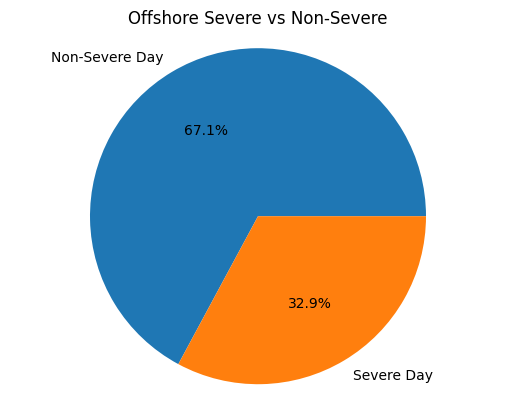

In [36]:
Tasks = [non_severe, severe]

my_labels = 'Non-Severe Day','Severe Day'
plt.pie(Tasks, labels=my_labels,autopct='%1.1f%%')
plt.title('Offshore Severe vs Non-Severe')
plt.axis('equal')
plt.show()

In [43]:
df1.describe()

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate           LI           KI  Thompson_Index  Total_Totals     T_1000mb      T_850mb      T_700mb      T_500mb  Convective_Temperature  1000-700mb_RH         PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level    -10C_Level  Energy_Helicity_Index  \
count  2425.000000           2425.000000           2425.000000  2425.000000  2425.000000     2425.000000   2425.000000  2425.000000  2425.000000  2425.000000  2425.000000             2425.000000    2425.000000  2425.000000           2425.000000               2425.000000                       2425.000000                          2425.000000                          2425.000000                          2425.000000                          2425.000000                         2425.000000                         2425.000000                         2425.000000                         2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000                     2425.000000  2425.000000                    2425.000000          2425.000000            2425.000000   2425.000000            2425.000000   
mean   2058.315622             -0.001747             -0.001708    -4.964577    24.616033       29.580495     42.144330    25.956206    16.974021     8.171381    -7.310062               21.944577      67.444206     1.707326             49.083052                 67.785155                         11.106845                             1.361031                             2.680495                             0.587299                             2.699464                            2.031093                            2.663588                            3.143794                            2.245526                        1.673732                        2.800536                        3.524371                        2.452454                        4.937320                        1.276330                        8.590474                       -1.224948    13.708909                       8.622969         12505.640289           15242.822028  20821.561071               0.117503   
std    1359.748691              0.000169              0.000123     3.463790    11.529952       13.511956      5.127347     1.806893     1.759248     1.661798     1.866236                3.295825      12.903507     0.382324             22.221345                 12.518128                          5.762012                             9.227463                             7.288878                             8.983929                             7.350624                            9.897215                            7.654584                            9.984575                            7.460429                       10.332692                        8.032408                       10.998940                        8.657062                       12.310049                        9.631886                       23.781752                       17.883749    15.885325                      31.771639          1727.285489            1066.318260   1101.635106               0.384449   
min    -563.801804             -0.002467             -0.002179   -15.900000   -47.650000  

In [ ]:
df_offshore.describe()

CAPE  700-500mb_Lapse_Rate  850-500mb_Lapse_Rate           LI           KI  Thompson_Index  Total_Totals     T_1000mb      T_850mb      T_700mb      T_500mb  Convective_Temperature  1000-700mb_RH          PWAT  700-500mb_Average_RH  Surface-700mb_Average_RH  Surface-700mb_Average_Wind_Speed  1000-700mb_Average_U-Wind_Component  1000-700mb_Average_V-Wind_Component  1000-850mb_Average_U-Wind_Component  1000-850mb_Average_V-Wind_Component  850-700mb_Average_U-Wind_Component  850-700mb_Average_V-Wind_Component  850-500mb_Average_U-Wind_Component  850-500mb_Average_V-Wind_Component  850mb_Average_U-Wind_Component  850mb_Average_V-Wind_Component  700mb_Average_U-Wind_Component  700mb_Average_V-Wind_Component  500mb_Average_U-Wind_Component  500mb_Average_V-Wind_Component  250mb_Average_U-Wind_Component  250mb_Average_V-Wind_Component  0-6km_Shear  0-3km_Storm_Relative_Helicity  Wet_Bulb_Zero_Level  Lowest_Freezing_Level    -10C_Level  Energy_Helicity_Index  \
count  1358.000000           1358.000000           1358.000000  1358.000000  1358.000000     1358.000000   1358.000000  1358.000000  1358.000000  1358.000000  1358.000000             1358.000000    1358.000000   1358.000000           1358.000000               1358.000000                       1358.000000                          1358.000000                          1358.000000                          1358.000000                          1358.000000                         1358.000000                         1358.000000                         1358.000000                         1358.000000                     1358.000000                     1358.000000                     1358.000000                     1358.000000                     1358.000000                     1358.000000                     1358.000000                     1358.000000  1358.000000                    1358.000000          1358.000000            1358.000000   1358.000000            1358.000000   
mean   2135.665045             -0.001737             -0.001723    -5.208837    26.630766       31.839543     42.956664    26.134168    17.207953     8.107511    -7.282474               22.035052      68.650442     65.977025             52.373564                 68.900147                         11.525331                             7.863328                             3.325552                             6.740280                             3.151105                            8.835935                            3.476141                            9.479971                            2.970398                        8.497570                        3.671723                       10.102946                        3.459205                       10.025479                        1.823196                       12.379308                        0.431222    16.390855                       9.460236         12728.926804           15186.238681  20848.704998               0.130108   
std    1321.698957              0.000170              0.000115     3.391907    10.199871       12.116569      4.527012     1.891359     1.718372     1.668129     1.886293                3.395933      12.245781    767.821061             21.131934                 11.918708                          6.105883                             5.856294                             7.353471                             5.787916                             7.406098                            6.634550                            7.756324                            7.386649                            7.544718                        7.560279                        8.080610                        8.405059                        8.764520                       11.478788                        9.686050                       24.704129                       17.388897    17.494349                      34.680452          1706.313926            1077.452222   1128.847140               0.414986   
min    -310.977886             -0.002467             -0.002179   -15.900000   -39.3000

In [37]:
# prompt: Count the number of columns in df_offshore

num_columns = len(df_offshore.columns)
print(f"The number of columns in df_offshore is: {num_columns}")


The number of columns in df_offshore is: 42


# Start Modeling Prep

In [38]:
#Split into Train/Test Data
#columns_drop = ['Year', 'Month', 'Day', 'Hour_(UTC)']
#columns_drop = ['Year', 'Month', 'Day', 'Hour (UTC)', 'CAPE', 'PWAT', 'Equilibrium_Level', 'Cloud_Depth_Ratio', 'EHI', 'LI', 'KI', 'Surface_700_RH']
#df.drop(columns_drop, inplace=True, axis=1)

#Model 1 (all variables, no transformations)
X = df1.loc[:, df1.columns != 'Severe']
y = df1.loc[:, df1.columns == 'Severe']

#X = (X-X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [50]:
# prompt: Standardize variables in the X dataset

from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to dataframes (optional but recommended)
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Just offshore flow

In [51]:
#Model 1 (all variables, no transformations)
X_offshore = df_offshore.loc[:, df_offshore.columns != 'Severe']
y_offshore = df_offshore.loc[:, df_offshore.columns == 'Severe']


#X = (X-X.mean()) / X.std()
X_train_offshore, X_test_offshore, y_train_offshore, y_test_offshore = train_test_split(X_offshore, y_offshore, test_size=0.3, stratify = y_offshore, random_state=42)

In [52]:
# Fit and transform the training data
X_train_offshore_scaled = scaler.fit_transform(X_train_offshore)

# Transform the testing data using the same scaler
X_test_offshore_scaled = scaler.transform(X_test_offshore)

# Convert the scaled data back to dataframes (optional but recommended)
#X_train_scaled_offshore = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#X_test_scaled_offshore = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
y_test

Severe
1569       0
2450       1
2447       1
1467       1
2761       0
...      ...
1264       0
2355       0
2779       1
2532       0
697        0

[728 rows x 1 columns]

# Logistic Regression All Predictors

In [53]:
# First model: Includes all predictor variables with no transforms on the non-resampled dataset
logreg_model1 = sm.Logit(y_train_offshore,X_train_offshore_scaled).fit()
print(logreg_model1.summary())

Optimization terminated successfully.
         Current function value: 0.586661
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 Severe   No. Observations:                  941
Model:                          Logit   Df Residuals:                      900
Method:                           MLE   Df Model:                           40
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                 0.07324
Time:                        02:17:05   Log-Likelihood:                -552.05
converged:                       True   LL-Null:                       -595.67
Covariance Type:            nonrobust   LLR p-value:                 2.293e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5928      0.203      2.917      0.004       0.195       0.991
x2            -3.4556      7

In [54]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Fit the Model with Sklearn
logreg = LogisticRegression(fit_intercept = True)    # default intercept = true
#logreg = LogisticRegression(fit_intercept = False)

logreg.fit(X_train_offshore_scaled, y_train_offshore.values.ravel())
y_pred_test = logreg.predict(X_test_offshore_scaled)
y_pred_train = logreg.predict(X_train_offshore_scaled)
print("Modeling complete")
# Instead of printing summary, you can print coefficients and intercept
print("Coefficients:", logreg.coef_)  # Print the coefficients
print("Intercept:", logreg.intercept_)  # Print the intercept

Modeling complete
Coefficients: [[ 5.42030143e-01  9.43329985e-02 -2.48352887e-01  2.91265246e-03
   1.84070900e-01  1.56025625e-01  3.63733885e-01  7.61366961e-01
   1.71868720e-02 -2.59400010e-01  1.29606620e-01  3.13592072e-01
  -7.32214405e-02 -5.75259096e-03  1.11407799e-01 -9.14011745e-02
  -7.27063746e-05  1.16951403e-02 -8.81710732e-02  2.49202350e-01
   4.80522986e-01 -1.87190382e-01 -5.10046793e-01  5.82379300e-01
   7.52053356e-01  1.62826579e-02 -4.77270823e-02  1.81540419e-01
   1.11164310e-01 -6.84100200e-02 -1.78981736e-01 -1.87120786e-01
  -6.00218701e-03 -3.45667206e-01  9.46527254e-02 -1.01316521e-01
  -3.51884198e-01 -7.99298723e-02 -5.28270003e-02 -2.00546118e-01
  -4.77788247e-01]]
Intercept: [-1.09809963]


In [58]:
#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(logreg.score(X_test_offshore_scaled, y_test_offshore))

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_test)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_test))

#An attempt at a regression model summary
print("\n---An attempt at a regression model summary")

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


regression_results(y_test_offshore, y_pred_test)


---Test Set Accuracy
0.7128712871287128

---Confusion Matrix
[[243  28]
 [ 88  45]]

---Classification Report
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       271
           1       0.62      0.34      0.44       133

    accuracy                           0.71       404
   macro avg       0.68      0.62      0.62       404
weighted avg       0.70      0.71      0.69       404


---An attempt at a regression model summary
explained_variance:  -0.2003
mean_squared_log_error:  0.138
r2:  -0.3002
MAE:  0.2871
MSE:  0.2871
RMSE:  0.5358


In [57]:
#calculate the brier score for the above logistic regression

from sklearn.metrics import brier_score_loss


# Calculate predicted probabilities if you only have predicted classes
y_pred_proba = logreg.predict_proba(X_test_offshore_scaled)[:, 1]


brier_score = brier_score_loss(y_test_offshore, y_pred_proba)

print(f"Brier Score: {brier_score}")


Brier Score: 0.1914362785135979


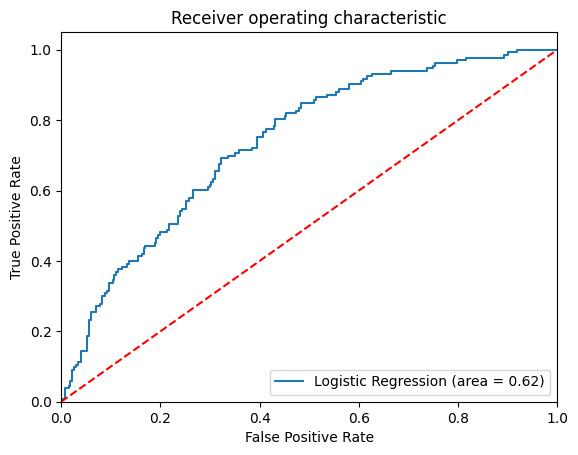

In [59]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test_offshore, logreg.predict(X_test_offshore_scaled))
fpr, tpr, thresholds = roc_curve(y_test_offshore, logreg.predict_proba(X_test_offshore_scaled)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

# P-Value and Meteorological Insight

['CAPE' '700-500mb_Lapse_Rate' '850-500mb_Lapse_Rate' 'LI' 'KI'
 'Thompson_Index' 'Total_Totals' 'T_1000mb' 'T_850mb' 'T_700mb' 'T_500mb'
 'Convective_Temperature' '1000-700mb_RH' 'PWAT' '700-500mb_Average_RH'
 'Surface-700mb_Average_RH' 'Surface-700mb_Average_Wind_Speed'
 '1000-700mb_Average_U-Wind_Component'
 '1000-700mb_Average_V-Wind_Component' '850mb_Average_U-Wind_Component'
 '850mb_Average_V-Wind_Component' '700mb_Average_U-Wind_Component'
 '700mb_Average_V-Wind_Component' '500mb_Average_U-Wind_Component'
 '500mb_Average_V-Wind_Component' '250mb_Average_U-Wind_Component'
 '250mb_Average_V-Wind_Component' '0-6km_Shear'
 '0-3km_Storm_Relative_Helicity' 'Wet_Bulb_Zero_Level' 'Equilibrium_Level'
 'Lowest_Freezing_Level' '-10C_Level' 'Cloud_Depth_Ratio'
 'Energy_Helicity_Index' 'Precip']

In [60]:
formula = 'Severe ~ Thompson_Index + WINDEX + Q("1000-700mb_Average_U-Wind_Component") '
y1, X1 = dmatrices(formula, data = df_offshore , return_type ='dataframe')
#X1 = (X1-X1.mean())/X1.std()
#X1['Intercept'] = 1

X1_train , X1_test , y1_train , y1_test = train_test_split ( X1, y1, test_size =0.2 , stratify = y1, random_state =42)
X1_train.head(10)

#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#X1_res, y1_res = smote.fit_resample(X1_train, y1_train)

Intercept  Thompson_Index     WINDEX  Q("1000-700mb_Average_U-Wind_Component")
2540        1.0            24.3  15.922115                                       7.3
1831        1.0            28.0  13.277723                                       6.4
1600        1.0            41.2  10.595890                                      12.2
897         1.0            36.4  13.144751                                       9.1
1725        1.0            31.1  12.446117                                       4.7
2038        1.0            36.7  11.188780                                      10.7
546         1.0            42.9  16.798319                                      18.2
2291        1.0            39.9  14.359209                                       5.8
1581        1.0            32.7   2.561726                                      13.5
915         1.0            29.0  11.650017                                       6.6

In [61]:
model1 = sm.Logit(y1_train,X1_train).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.563565
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Severe   No. Observations:                 1076
Model:                          Logit   Df Residuals:                     1072
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.1103
Time:                        02:21:05   Log-Likelihood:                -606.40
converged:                       True   LL-Null:                       -681.61
Covariance Type:            nonrobust   LLR p-value:                 2.133e-32
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -4.4

In [62]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Fit the Model with Sklearn
#logreg = LogisticRegression(fit_intercept = True)    # default intercept = true
logreg = LogisticRegression(fit_intercept = False)

logreg.fit(X1_train, y1_train.values.ravel())
y1_pred_test = logreg.predict(X1_test)
y1_pred_train = logreg.predict(X1_train)
print("Modeling complete")
y1_pred_test
logreg_predict = logreg.predict_proba(X1_test)
print(type(logreg_predict))

Modeling complete
<class 'numpy.ndarray'>


In [63]:
df_logreg_predict = pd.DataFrame(logreg_predict)
df_logreg_predict
#df_logreg_predict['lightning'] = y1_test['Lightning']
df_logreg_predict
y1_test_reset = y1_test.reset_index()
df_logreg_predict = pd.concat([df_logreg_predict, y1_test_reset['Severe']], axis=1)
df_logreg_predict

#y1_test['Lightning']

0         1  Severe
0    0.615160  0.384840     0.0
1    0.435526  0.564474     0.0
2    0.505582  0.494418     0.0
3    0.737427  0.262573     0.0
4    0.734387  0.265613     1.0
..        ...       ...     ...
264  0.712663  0.287337     1.0
265  0.749512  0.250488     0.0
266  0.560258  0.439742     1.0
267  0.880161  0.119839     0.0
268  0.468130  0.531870     1.0

[269 rows x 3 columns]

In [64]:
#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(logreg.score(X1_test, y1_test))

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y1_test, y1_pred_test)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y1_test, y1_pred_test))

#An attempt at a regression model summary
print("\n---An attempt at a regression model summary")

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


regression_results(y1_test, y1_pred_test)


---Test Set Accuracy
0.7137546468401487

---Confusion Matrix
[[172   9]
 [ 68  20]]

---Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82       181
         1.0       0.69      0.23      0.34        88

    accuracy                           0.71       269
   macro avg       0.70      0.59      0.58       269
weighted avg       0.71      0.71      0.66       269


---An attempt at a regression model summary
explained_variance:  -0.0819
mean_squared_log_error:  0.1375
r2:  -0.3004
MAE:  0.2862
MSE:  0.2862
RMSE:  0.535


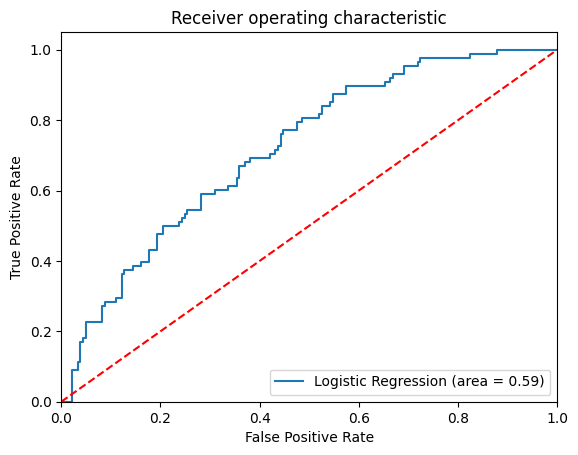

In [65]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y1_test, logreg.predict(X1_test))
fpr, tpr, thresholds = roc_curve(y1_test, logreg.predict_proba(X1_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

# Logistic Regression with Recursive Feature Elimination

In [66]:
from sklearn.feature_selection import RFE
from sklearn import linear_model
model_a = linear_model.LogisticRegression()



rfe = RFE(model_a, n_features_to_select=8, step = 1)
fit = rfe.fit(X_train, y_train.values.ravel())

f = fit.get_support(1) #the most important features
# final_features = data[data.columns[f]] # final features: this gives wrong results
final_features = X[X.columns[f]] # final features

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % final_features.columns)
print("Score: %2.3f" % fit.score(X,y.values.ravel()))

print("----------")

#Selected 'Ed', 'LF', 'MF', 'Wealth', 'Time'

# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, %s, Selected %s, Rank: %.3f' % (i, X.columns.values[i],rfe.support_[i], rfe.ranking_[i]))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Num Features: 8
Selected Features: Index(['Thompson_Index', 'T_850mb', 'T_500mb', '1000-700mb_RH', 'Surface-700mb_Average_RH', '1000-850mb_Average_V-Wind_Component', '850-700mb_Average_V-Wind_Component', '700mb_Average_U-Wind_Component'], dtype='object')
Score: 0.796
----------
Column: 0, CAPE, Selected False, Rank: 24.000
Column: 1, 700-500mb_Lapse_Rate, Selected False, Rank: 33.000
Column: 2, 850-500mb_Lapse_Rate, Selected False, Rank: 34.000
Column: 3, LI, Selected False, Rank: 4.000
Column: 4, KI, Selected False, Rank: 18.000
Column: 5, Thompson_Index, Selected True, Rank: 1.000
Column: 6, Total_Totals, Selected False, Rank: 7.000
Column: 7, T_1000mb, Selected False, Rank: 6.000
Column: 8, T_850mb, Selected True, Rank: 1.000
Column: 9, T_700mb, Selected False, Rank: 28.000
Column: 10, T_500mb, Selected True, Rank: 1.000
Column: 11, Convective_Temperature, Selected False, Rank: 32.000
Column: 12, 1000-700mb_RH, Selected True, Rank: 1.000
Column: 13, PWAT, Selected False, Rank: 21.00

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
model = linear_model.LogisticRegression()


print("\nSearch the best k features for k = 1 to 27\n")

for k in range(1, 10):
  rfe = RFE(model, n_features_to_select = k, step=1)
  fit = rfe.fit(X, y)

  f = fit.get_support(1) #the most important features

  # final_features = data[data.columns[f]] # final features: this gives wrong results
  final_features = X[X.columns[f]] # final features

  print("Num Features: %d" % fit.n_features_)
  print("Selected Features: %s" % final_features.columns)
  print("Score: %2.2f" % fit.score(X,y))
  print("----------")


Search the best k features for k = 1 to 27



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Num Features: 1
Selected Features: Index(['PWAT'], dtype='object')
Score: 0.77
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Num Features: 2
Selected Features: Index(['LI', 'PWAT'], dtype='object')
Score: 0.77
----------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Num Features: 3
Selected Features: Index(['LI', 'Convective_Temperature', 'PWAT'], dtype='object')
Score: 0.77
----------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Num Features: 4
Selected Features: Index(['LI', 'Convective_Temperature', 'PWAT', '1000-850mb_Average_U-Wind_Component'], dtype='object')
Score: 0.78
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Num Features: 5
Selected Features: Index(['LI', 'Convective_Temperature', 'PWAT', 'Surface-700mb_Average_Wind_Speed', '1000-850mb_Average_U-Wind_Component'], dtype='object')
Score: 0.78
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Num Features: 6
Selected Features: Index(['LI', 'Thompson_Index', 'Convective_Temperature', 'PWAT', 'Surface-700mb_Average_Wind_Speed', '1000-850mb_Average_U-Wind_Component'], dtype='object')
Score: 0.79
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Num Features: 7
Selected Features: Index(['LI', 'KI', 'Thompson_Index', 'Convective_Temperature', 'PWAT', 'Surface-700mb_Average_Wind_Speed', '1000-850mb_Average_U-Wind_Component'], dtype='object')
Score: 0.79
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Num Features: 8
Selected Features: Index(['LI', 'KI', 'Thompson_Index', 'Convective_Temperature', 'PWAT', 'Surface-700mb_Average_Wind_Speed', '1000-850mb_Average_U-Wind_Component', '850-500mb_Average_V-Wind_Component'], dtype='object')
Score: 0.79
----------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Num Features: 9
Selected Features: Index(['LI', 'KI', 'Thompson_Index', 'T_500mb', 'Convective_Temperature', 'PWAT', 'Surface-700mb_Average_Wind_Speed', '1000-850mb_Average_U-Wind_Component', '850-500mb_Average_V-Wind_Component'], dtype='object')
Score: 0.79
----------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
formula2 = 'Severe ~ Thompson_Index + Convective_Temperature + T_500mb + Q("1000-850mb_Average_U-Wind_Component") + Q("850-500mb_Average_V-Wind_Component")'
y2, X2 = dmatrices(formula2, data = df_offshore , return_type ='dataframe')
#X1 = (X1-X1.mean())/X1.std()
#X1['Intercept'] = 1

X2_train , X2_test , y2_train , y2_test = train_test_split ( X2, y2, test_size =0.3 , stratify = y1, random_state =42)
X2_train.head(10)


Intercept  Thompson_Index  Convective_Temperature  T_500mb  Q("1000-850mb_Average_U-Wind_Component")  Q("850-500mb_Average_V-Wind_Component")
31          1.0            32.1                    16.1     -7.5                                      17.0                                     26.2
2497        1.0            35.8                    16.3    -14.5                                      -1.2                                    -13.9
451         1.0             5.6                    18.1    -10.3                                       9.9                                     -7.5
2141        1.0            28.9                    22.7     -5.9                                       5.9                                     14.0
2460        1.0            31.5                    22.9     -5.3                                       5.9                                      0.0
2691        1.0            34.6                    23.9     -6.9                                       8.5                                      1.4
1256        1.0            30.9                    22.5     -6.5                                      -3.4                                     -1.9
628         1.0            36.1                    22.2     -9.7                                      14.4                                      1.9
2539        1.0            37.3                    18.5     -8.9                                       6.9                                     -3.9
2229        1.0             0.0                    20.8     -8.9                                       1.6                                      5.1

In [ ]:
model2 = sm.Logit(y2_train,X2_train).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.546973
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Severe   No. Observations:                  945
Model:                          Logit   Df Residuals:                      939
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                  0.1366
Time:                        16:08:29   Log-Likelihood:                -516.89
converged:                       True   LL-Null:                       -598.70
Covariance Type:            nonrobust   LLR p-value:                 1.682e-33
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -8.4

In [ ]:

#Fit the Model with Sklearn
logreg = LogisticRegression(fit_intercept = True)    # default intercept = true
#logreg = LogisticRegression(fit_intercept = False)

logreg.fit(X2_train,y2_train.values.ravel())
y2_pred_test = logreg.predict(X2_test)
y2_pred_train = logreg.predict(X2_train)
print("Modeling complete")

Modeling complete


In [ ]:
#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(logreg.score(X2_test, y2_test))

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y2_test, y2_pred_test)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y2_test, y2_pred_test))

#An attempt at a regression model summary
print("\n---An attempt at a regression model summary")

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


regression_results(y2_test, y2_pred_test)


---Test Set Accuracy
0.6995073891625616

---Confusion Matrix
[[244  29]
 [ 93  40]]

---Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.89      0.80       273
         1.0       0.58      0.30      0.40       133

    accuracy                           0.70       406
   macro avg       0.65      0.60      0.60       406
weighted avg       0.68      0.70      0.67       406


---An attempt at a regression model summary
explained_variance:  -0.2514
mean_squared_log_error:  0.1444
r2:  -0.3642
MAE:  0.3005
MSE:  0.3005
RMSE:  0.5482


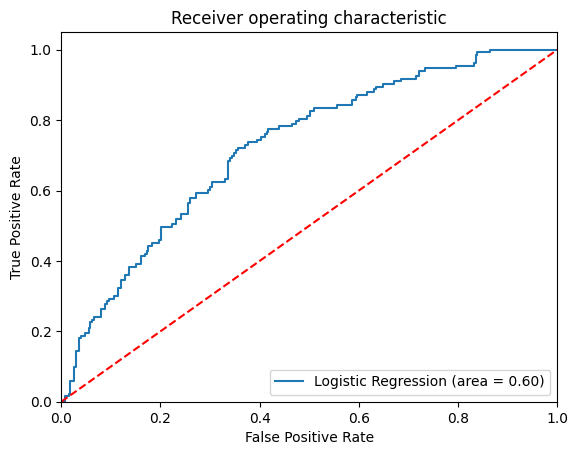

In [ ]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y2_test, logreg.predict(X2_test))
fpr, tpr, thresholds = roc_curve(y2_test, logreg.predict_proba(X2_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

# Decision Tree / CART Approach

This code is modified from https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85

In [48]:
from sklearn.tree import DecisionTreeClassifier

def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

    #Apply SMOTE

    #smote = SMOTE(random_state=42)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion,
                                        splitter=splitter,
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf,
                                        random_state=0,
                                  )
    clf = model.fit(X_train, y_train)



    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    #pred_labels_tr = (model.predict_proba(X_train)[:,1] >= 0.2).astype(bool)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)
    #pred_labels_te = (model.predict_proba(X_test)[:,1] >= 0.4).astype(bool)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    #print('No. of features: ', clf.n_features_)
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')

    print('*************** Feature importance ***************')
    feature_importance = clf.feature_importances_
    print('Feature Importance: ', feature_importance)

    #Plot feature importance
    feature_imp = pd.Series(clf.feature_importances_, index = clf.feature_names_in_)
    plt.figure(figsize=(20,15))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features", pad=15, size=14)

    #Make the Roc Curve for test data
    rfc_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='CART (area = %0.2f)' % rfc_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC', transparent=True)
    plt.show()

    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.columns,
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True,
                                rounded=True,
                                #rotate=True,
                               )
    graph = graphviz.Source(dot_data)

    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  10
No. of leaves:  51
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.6493827160493827
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       272
           1       0.46      0.42      0.44       133

    accuracy                           0.65       405
   macro avg       0.60      0.59      0.59       405
weighted avg       0.64      0.65      0.64       405

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8462354188759279
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       633
           1       0.78      0.74      0.76       310

    accuracy                           0.85       943
   macro avg       0.83      0.82      0.82       943
w

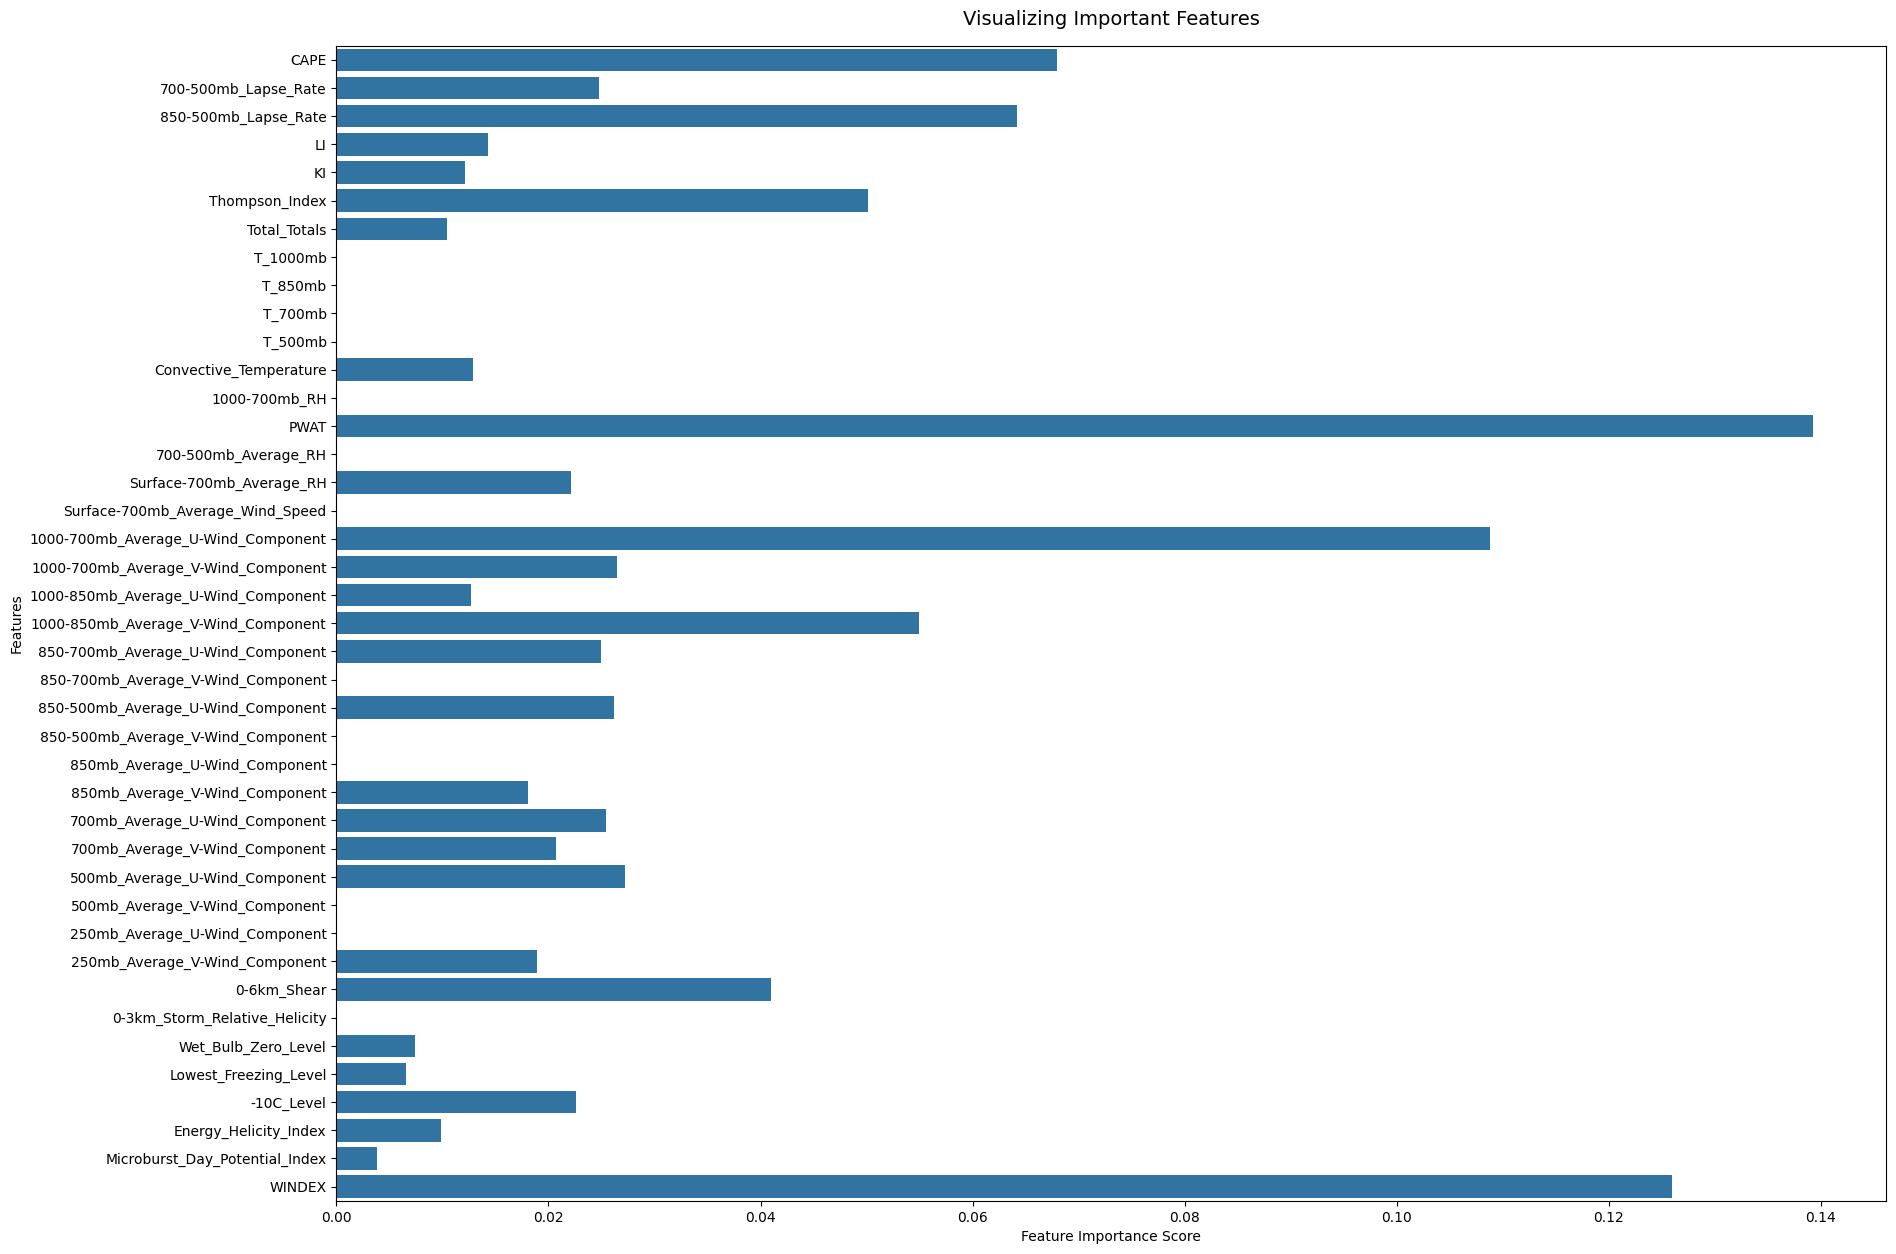

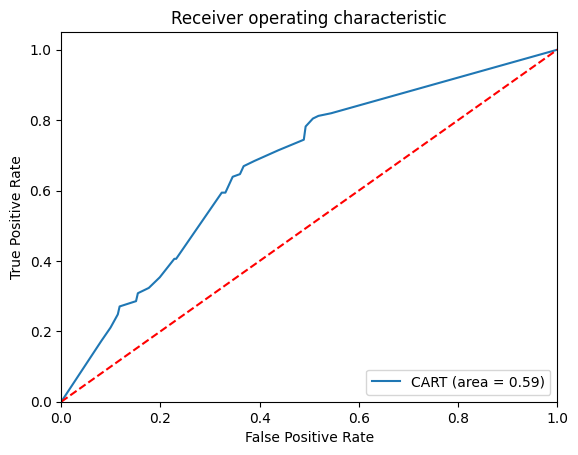

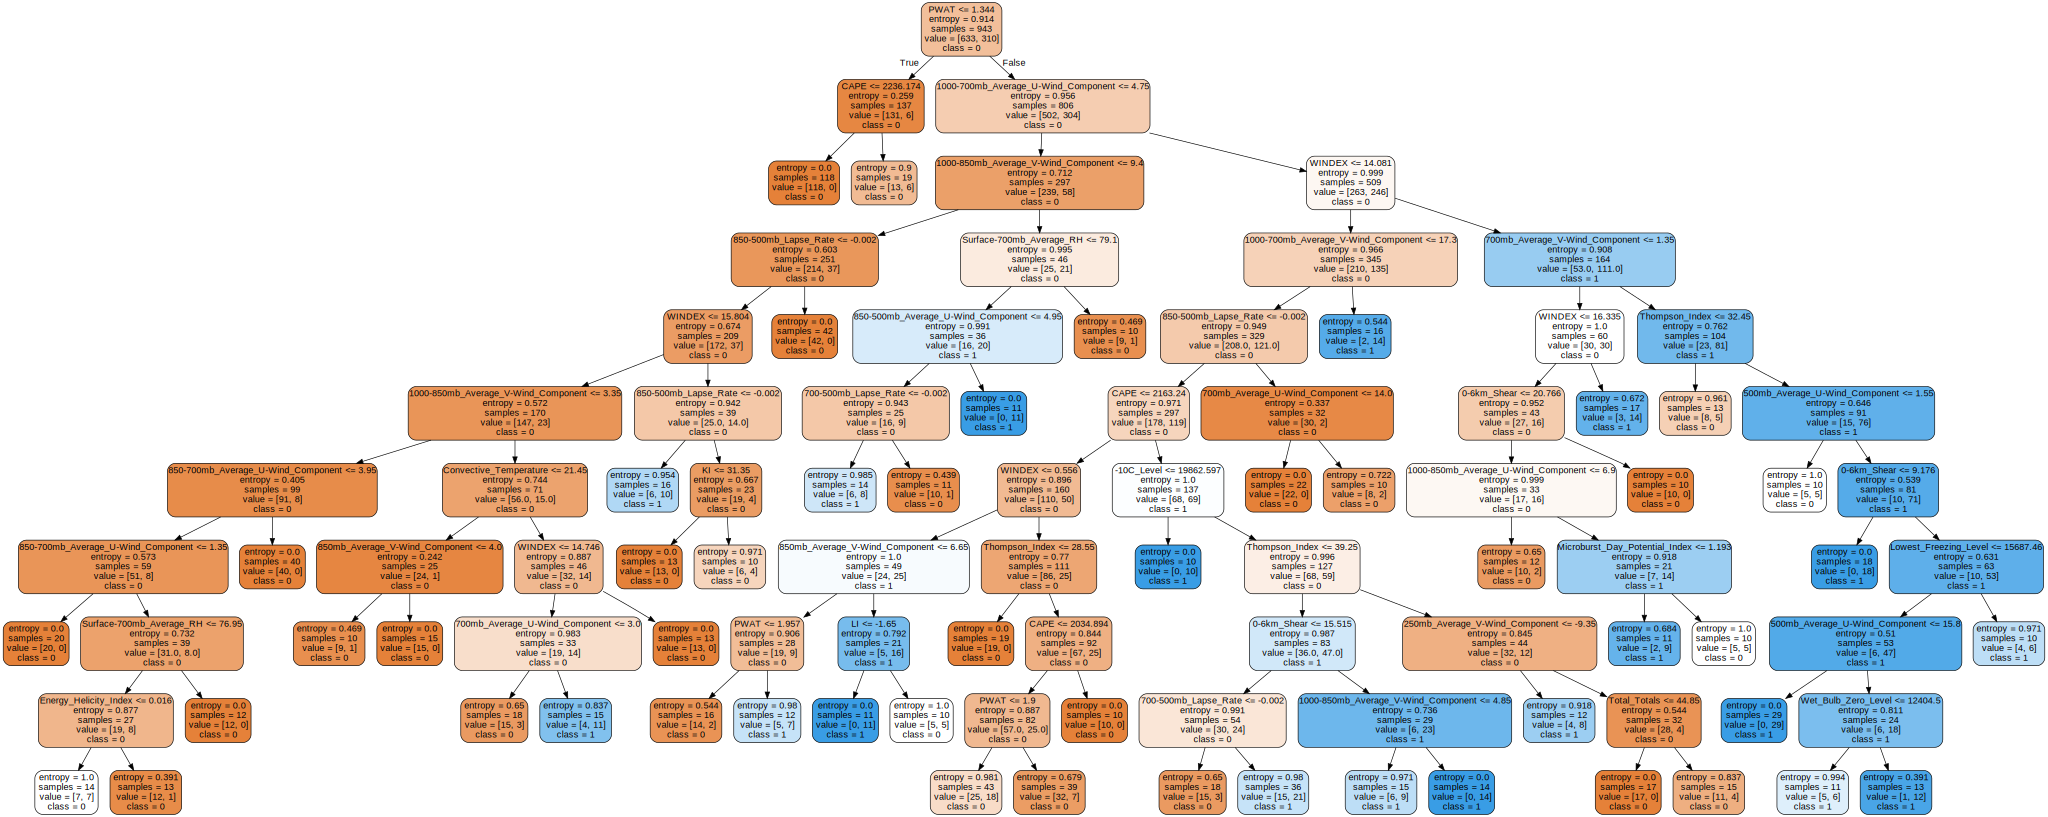

In [49]:
# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X_offshore, y_offshore, 'entropy', 'best',
                                                       mdepth=10,
                                                       clweight=None,
                                                       minleaf=10)

# Plot the tree graph
graph


# Save tree graph to a PDF
#graph.render('Decision_Tree_all_vars_gini')

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  5
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.6936619718309859
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       191
           1       0.55      0.38      0.45        93

    accuracy                           0.69       284
   macro avg       0.64      0.61      0.62       284
weighted avg       0.67      0.69      0.68       284

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.7594553706505295
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       443
           1       0.75      0.41      0.53       218

    accuracy                           0.76       661
   macro avg       0.75      0.67      0.68       661
wei

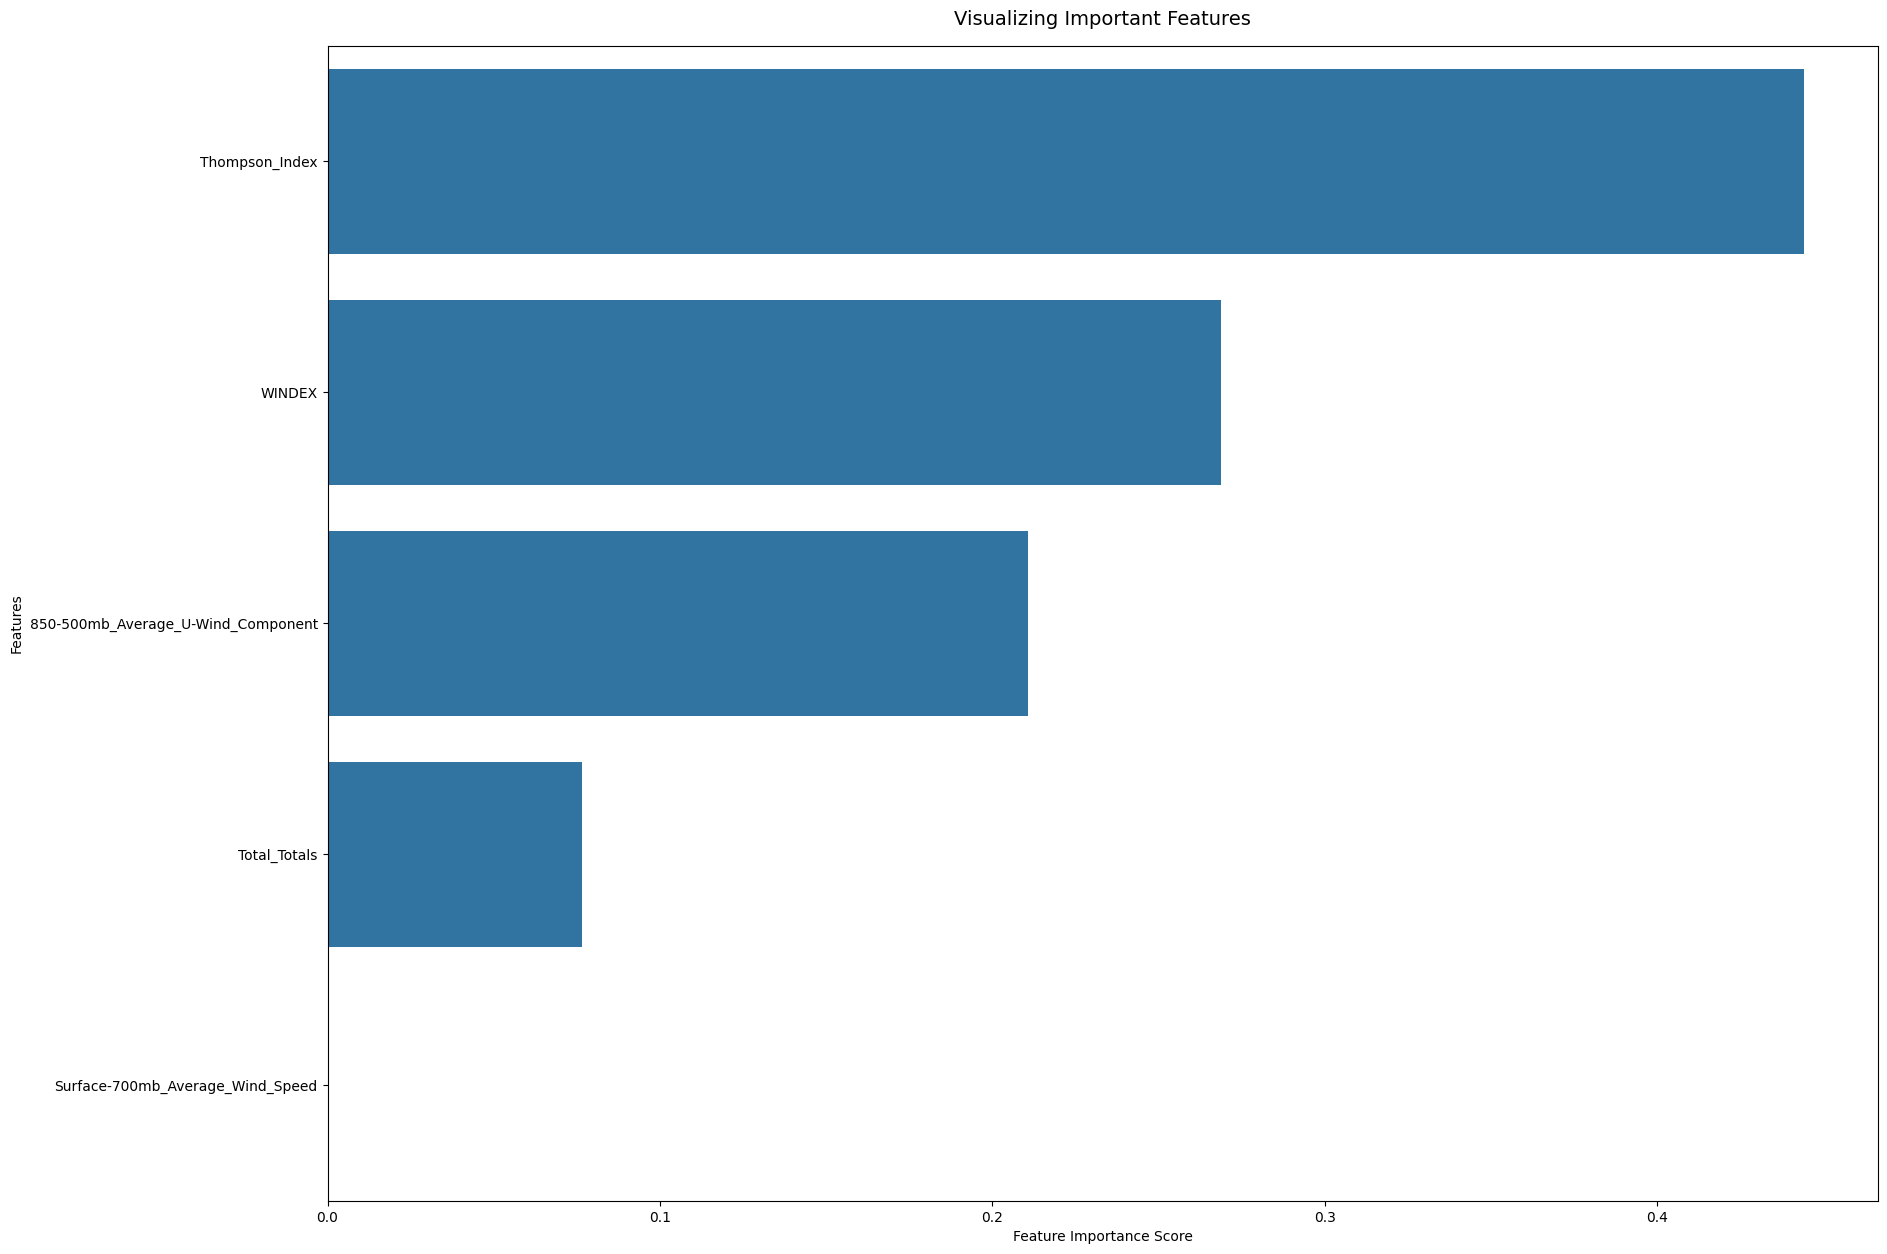

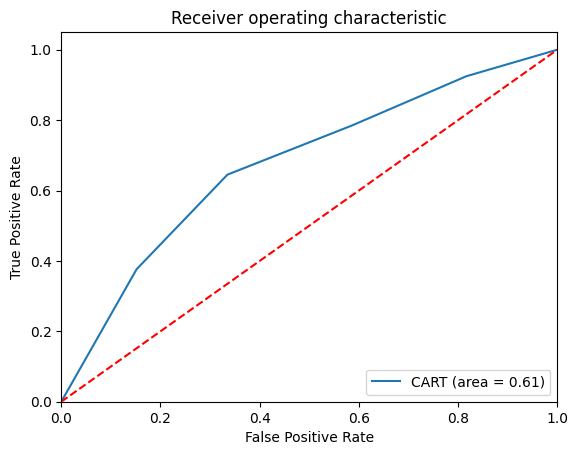

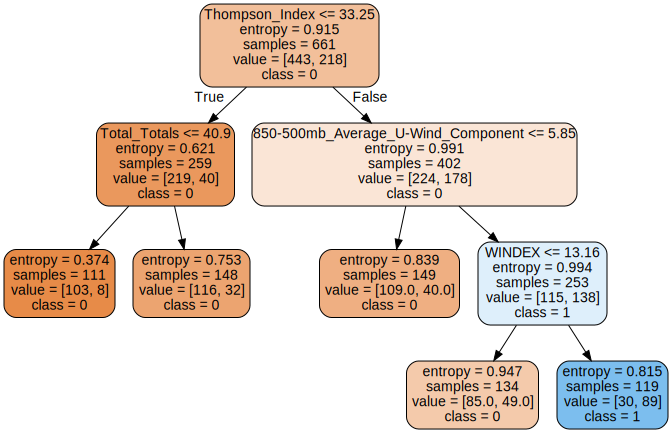

In [ ]:
X_cart = X_train_offshore[['Thompson_Index', 'WINDEX', '850-500mb_Average_U-Wind_Component', 'Total_Totals','Surface-700mb_Average_Wind_Speed']].copy()


X_train, X_test, y_train, y_test, clf, graph = fitting(X_cart, y_train_offshore, 'entropy', 'best',
                                                       mdepth=15,
                                                       clweight=None,
                                                       minleaf=100)

# Plot the tree graph
graph

# Random Forest Classifier

In [67]:
def hss(a, b, c, d):
  return (2*(a*d)-(b*c))/(((a+c)*(c+d)) + ((a + b)*(b+d)))

In [68]:
# prompt: Create a 1d array the same length as y_test, but with the value offshore_severe_pct as every value

import numpy as np

# Create a 1d array the same length as y_test
offshore_severe_pct_array = np.full(len(y_test), offshore_severe_pct)



In [69]:
total_severe_pct_array = np.full(len(y_test), .223)


---Test Set Accuracy
0.8220689655172414

---Brier Score
0.1349085134166107

---Brier Skill Score
0.22930392949589284

---Confusion Matrix
[[536  25]
 [104  60]]

---Classification Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       561
           1       0.71      0.37      0.48       164

    accuracy                           0.82       725
   macro avg       0.77      0.66      0.69       725
weighted avg       0.81      0.82      0.80       725


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

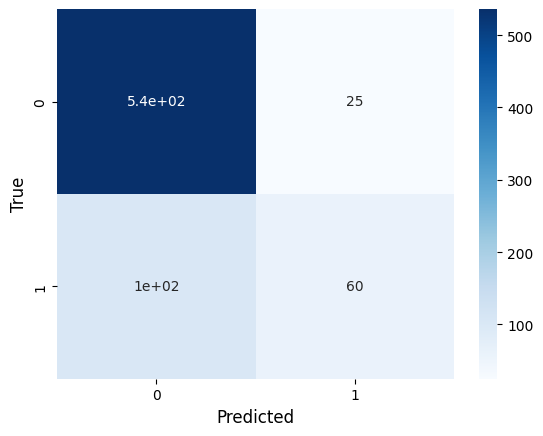

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

RFC_model = RandomForestClassifier(n_estimators=500,  criterion='entropy', max_features='sqrt',
                                 max_depth=6, bootstrap=True, n_jobs=1,
                                 random_state=42)

RFC_model.fit(X_train, y_train.values.ravel())
y_pred = RFC_model.predict(X_test)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model.score(X_test, y_test))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
#probs = RFC_model.predict_proba(X_test)
# keep the predictions for class 1 only
#probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test), offshore_severe_pct)
brier_climo = brier_score_loss(y_test, total_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)


In [71]:
hss1 = hss(15, 93, 7, 473)
print(hss1)

hss2 = hss(6, 25, 9, 352)
print(hss2)

0.18886006026113156
0.23383230031575256


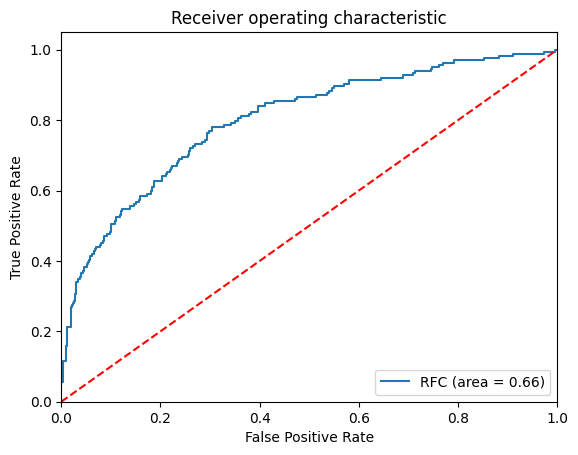

In [72]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rfc_roc_auc = roc_auc_score(y_test, RFC_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFC_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

Text(0.5, 1.0, 'Visualizing Important Features')

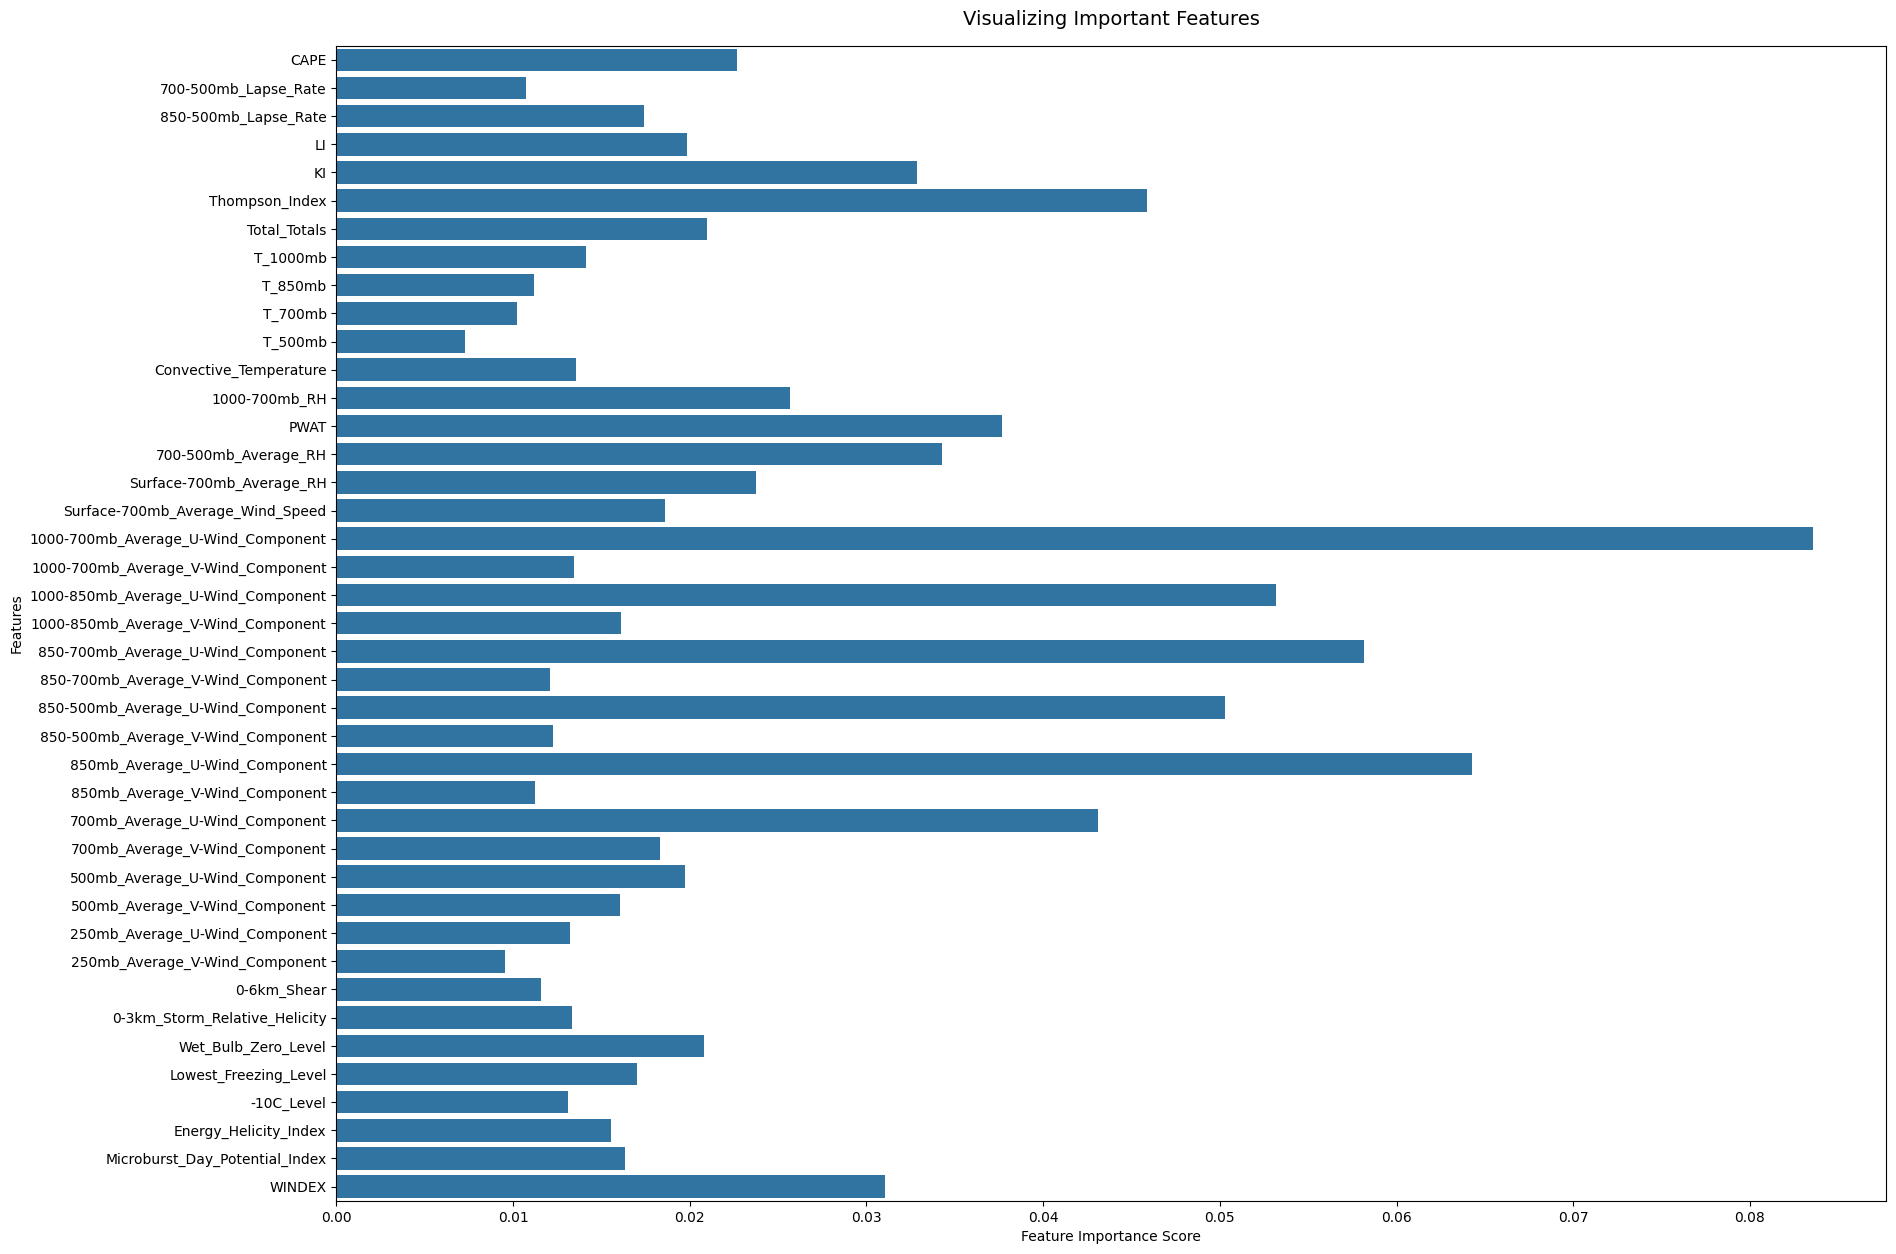

In [73]:
#feature_imp = pd.Series(model.feature_importances_,
                        #index=['sepal length (cm)', 'sepal width (cm)',
#'petal length (cm)', 'petal width (cm)']).sort_values(ascending=False)

feature_imp = pd.Series(RFC_model.feature_importances_, index = RFC_model.feature_names_in_)


plt.figure(figsize=(20,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)



In [74]:
print(RFC_model.feature_names_in_)

['CAPE' '700-500mb_Lapse_Rate' '850-500mb_Lapse_Rate' 'LI' 'KI'
 'Thompson_Index' 'Total_Totals' 'T_1000mb' 'T_850mb' 'T_700mb' 'T_500mb'
 'Convective_Temperature' '1000-700mb_RH' 'PWAT' '700-500mb_Average_RH'
 'Surface-700mb_Average_RH' 'Surface-700mb_Average_Wind_Speed'
 '1000-700mb_Average_U-Wind_Component'
 '1000-700mb_Average_V-Wind_Component'
 '1000-850mb_Average_U-Wind_Component'
 '1000-850mb_Average_V-Wind_Component'
 '850-700mb_Average_U-Wind_Component' '850-700mb_Average_V-Wind_Component'
 '850-500mb_Average_U-Wind_Component' '850-500mb_Average_V-Wind_Component'
 '850mb_Average_U-Wind_Component' '850mb_Average_V-Wind_Component'
 '700mb_Average_U-Wind_Component' '700mb_Average_V-Wind_Component'
 '500mb_Average_U-Wind_Component' '500mb_Average_V-Wind_Component'
 '250mb_Average_U-Wind_Component' '250mb_Average_V-Wind_Component'
 '0-6km_Shear' '0-3km_Storm_Relative_Helicity' 'Wet_Bulb_Zero_Level'
 'Lowest_Freezing_Level' '-10C_Level' 'Energy_Helicity_Index'
 'Microburst_Day_Poten

In [75]:
RFC_model_weights_full = RandomForestClassifier(n_estimators=500, class_weight= 'balanced', criterion='entropy', max_features='sqrt',
                                 max_depth = 8, bootstrap=True, n_jobs=1,
                                 random_state=9)

RFC_model_weights_full.fit(X_train, y_train.values.ravel())
y_pred = RFC_model_weights_full.predict(X_test)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model_weights_full.score(X_test, y_test))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model_weights_full.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = RFC_model_weights_full.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

#offshore_severe_pct_array = np.full(len(y_test), severe_pct)
#brier_climo = brier_score_loss(y_test, severe_pct_array)
#BSS = 1 - (brier_raw / brier_climo)
#print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)


---Test Set Accuracy
0.7903448275862069

---Brier Score
0.14456505552415683

---Brier Skill Score

---Confusion Matrix
[[480  81]
 [ 71  93]]

---Classification Report


NameError: name 'y_pred_offshore' is not defined

In [ ]:
X_train_RFC = X_train[['Thompson_Index', '850mb_Average_U-Wind_Component','700-500mb_Average_RH', 'WINDEX']].copy()
X_test_RFC = X_test[['Thompson_Index', '850mb_Average_U-Wind_Component', '700-500mb_Average_RH', 'WINDEX']].copy()


---Test Set Accuracy
0.7912087912087912

---Brier Score
0.14641904695166347

---Brier Skill Score
0.16471435713386462

---Confusion Matrix
[[535  28]
 [124  41]]

---Classification Report
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       563
           1       0.59      0.25      0.35       165

    accuracy                           0.79       728
   macro avg       0.70      0.60      0.61       728
weighted avg       0.76      0.79      0.76       728


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

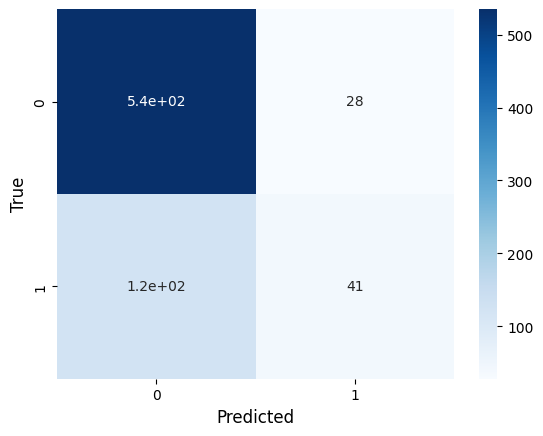

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

RFC_model = RandomForestClassifier(n_estimators=500,  criterion='entropy', max_features='sqrt',
                                 max_depth=6, bootstrap=True, n_jobs=1,
                                 random_state=42)

RFC_model.fit(X_train_RFC, y_train.values.ravel())
y_pred = RFC_model.predict(X_test_RFC)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model.score(X_test_RFC, y_test))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model.predict_proba(X_test_RFC)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
#probs = RFC_model.predict_proba(X_test)
# keep the predictions for class 1 only
#probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test), offshore_severe_pct)
brier_climo = brier_score_loss(y_test, total_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

#Random Forest Just Offshore Flow


---Test Set Accuracy
0.7475247524752475

---Brier Score
0.17157094384242266

---Brier Skill Score
0.22306467240707362

---Confusion Matrix
[[253  18]
 [ 84  49]]

---Classification Report
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       271
           1       0.73      0.37      0.49       133

    accuracy                           0.75       404
   macro avg       0.74      0.65      0.66       404
weighted avg       0.74      0.75      0.72       404


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

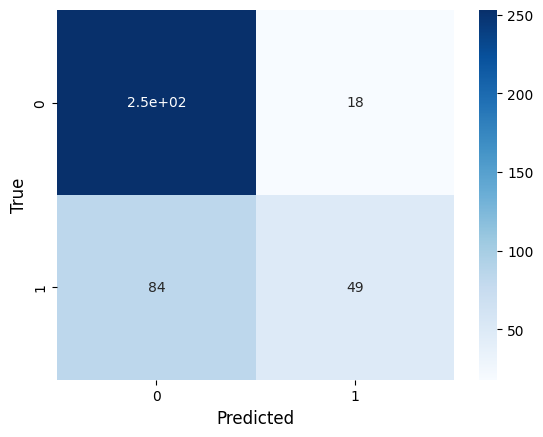

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

RFC_model_offshore = RandomForestClassifier(n_estimators=500,  criterion='entropy', max_features='sqrt',
                                 max_depth = 8, bootstrap=True, n_jobs=1,
                                 random_state=9)

RFC_model_offshore.fit(X_train_offshore, y_train_offshore.values.ravel())
y_pred_offshore = RFC_model_offshore.predict(X_test_offshore)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model_offshore.score(X_test_offshore, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model_offshore.predict_proba(X_test_offshore)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = RFC_model_offshore.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

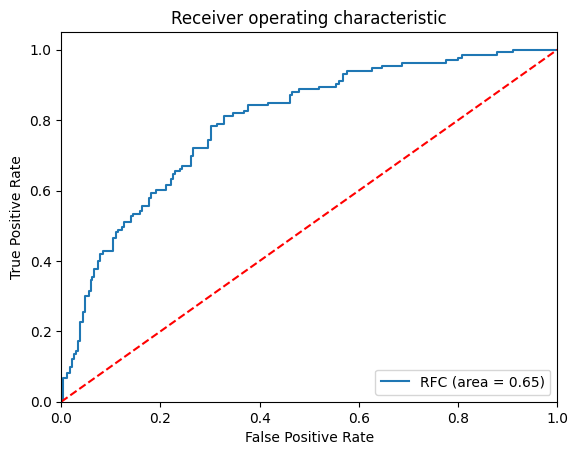

In [77]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rfc_roc_auc = roc_auc_score(y_test_offshore, RFC_model_offshore.predict(X_test_offshore))
fpr, tpr, thresholds = roc_curve(y_test_offshore, RFC_model_offshore.predict_proba(X_test_offshore)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

Text(0.5, 1.0, 'Visualizing Important Features')

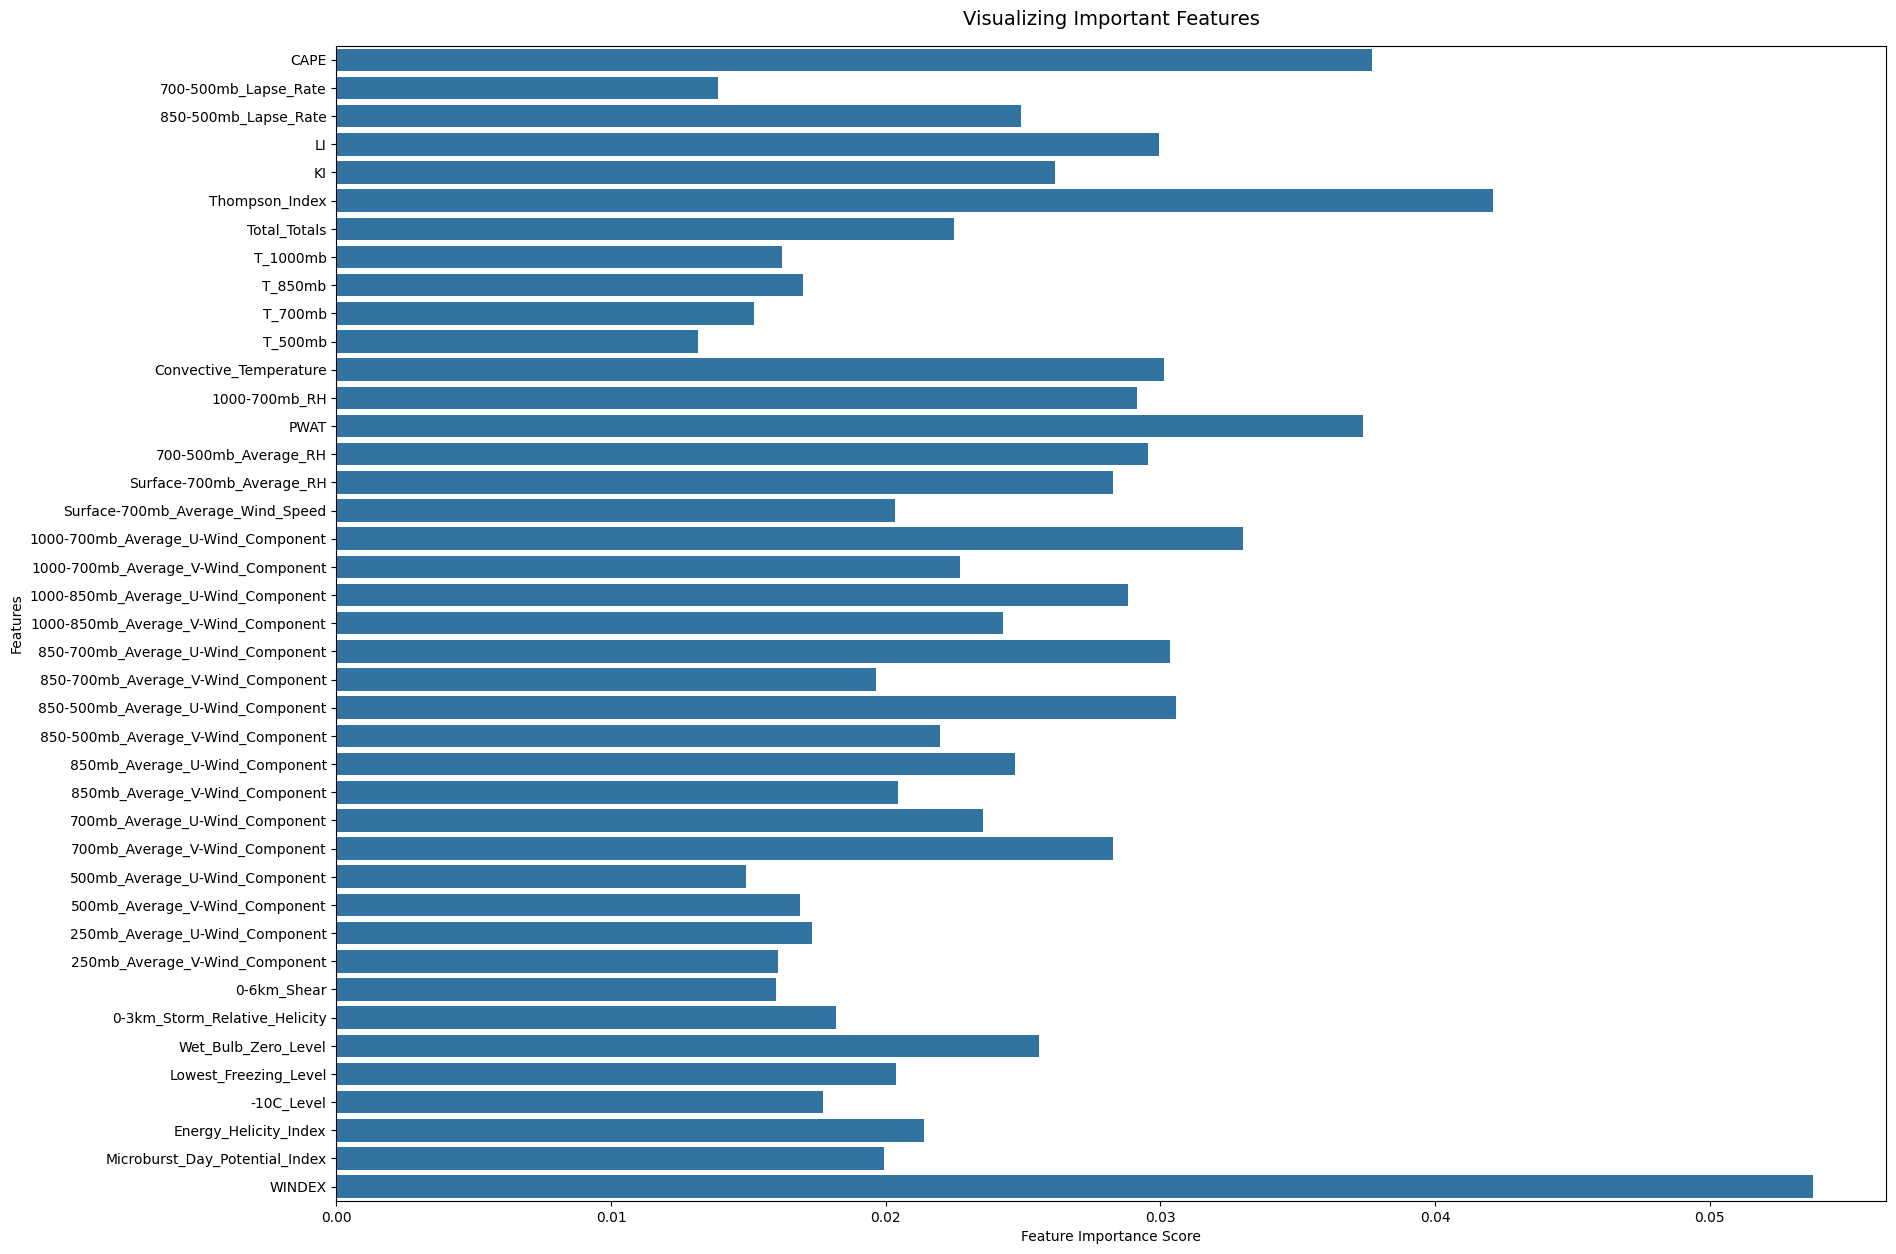

In [78]:
feature_imp = pd.Series(RFC_model_offshore.feature_importances_, index = RFC_model_offshore.feature_names_in_)


plt.figure(figsize=(20,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)


---Test Set Accuracy
0.7425742574257426

---Brier Score
0.1714483289893732

---Brier Skill Score
0.22361991683767624

---Confusion Matrix
[[231  40]
 [ 64  69]]

---Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       271
           1       0.63      0.52      0.57       133

    accuracy                           0.74       404
   macro avg       0.71      0.69      0.69       404
weighted avg       0.73      0.74      0.74       404


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

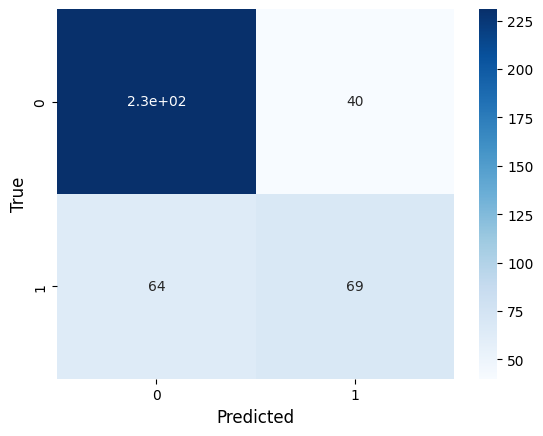

In [79]:
RFC_model_offshore_weights_full = RandomForestClassifier(n_estimators=500, class_weight= 'balanced', criterion='entropy', max_features='sqrt',
                                 max_depth = 8, bootstrap=True, n_jobs=1,
                                 random_state=9)

RFC_model_offshore_weights_full.fit(X_train_offshore, y_train_offshore.values.ravel())
y_pred_offshore = RFC_model_offshore_weights_full.predict(X_test_offshore)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model_offshore_weights_full.score(X_test_offshore, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model_offshore_weights_full.predict_proba(X_test_offshore)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = RFC_model_offshore_weights_full.predict_proba(X_test_offshore)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

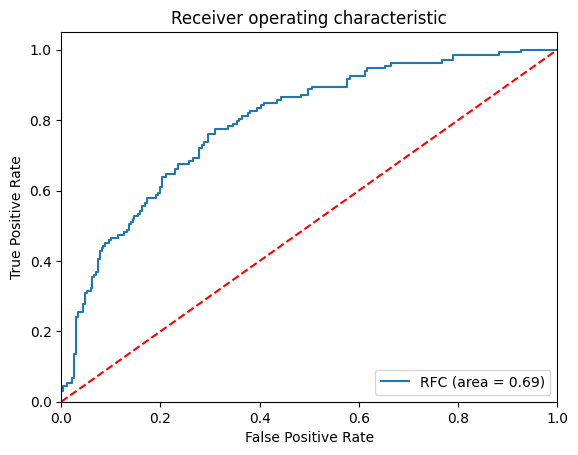

In [81]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rfc_roc_auc = roc_auc_score(y_test_offshore, RFC_model_offshore_weights_full.predict(X_test_offshore))
fpr, tpr, thresholds = roc_curve(y_test_offshore, RFC_model_offshore_weights_full.predict_proba(X_test_offshore)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

#Feature Importance Just Offshore Flow Random Forest

In [82]:
import numpy as np
import pandas as pd
import shap

from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

perm_importance = permutation_importance(RFC_model_offshore, X_test_offshore, y_test_offshore)

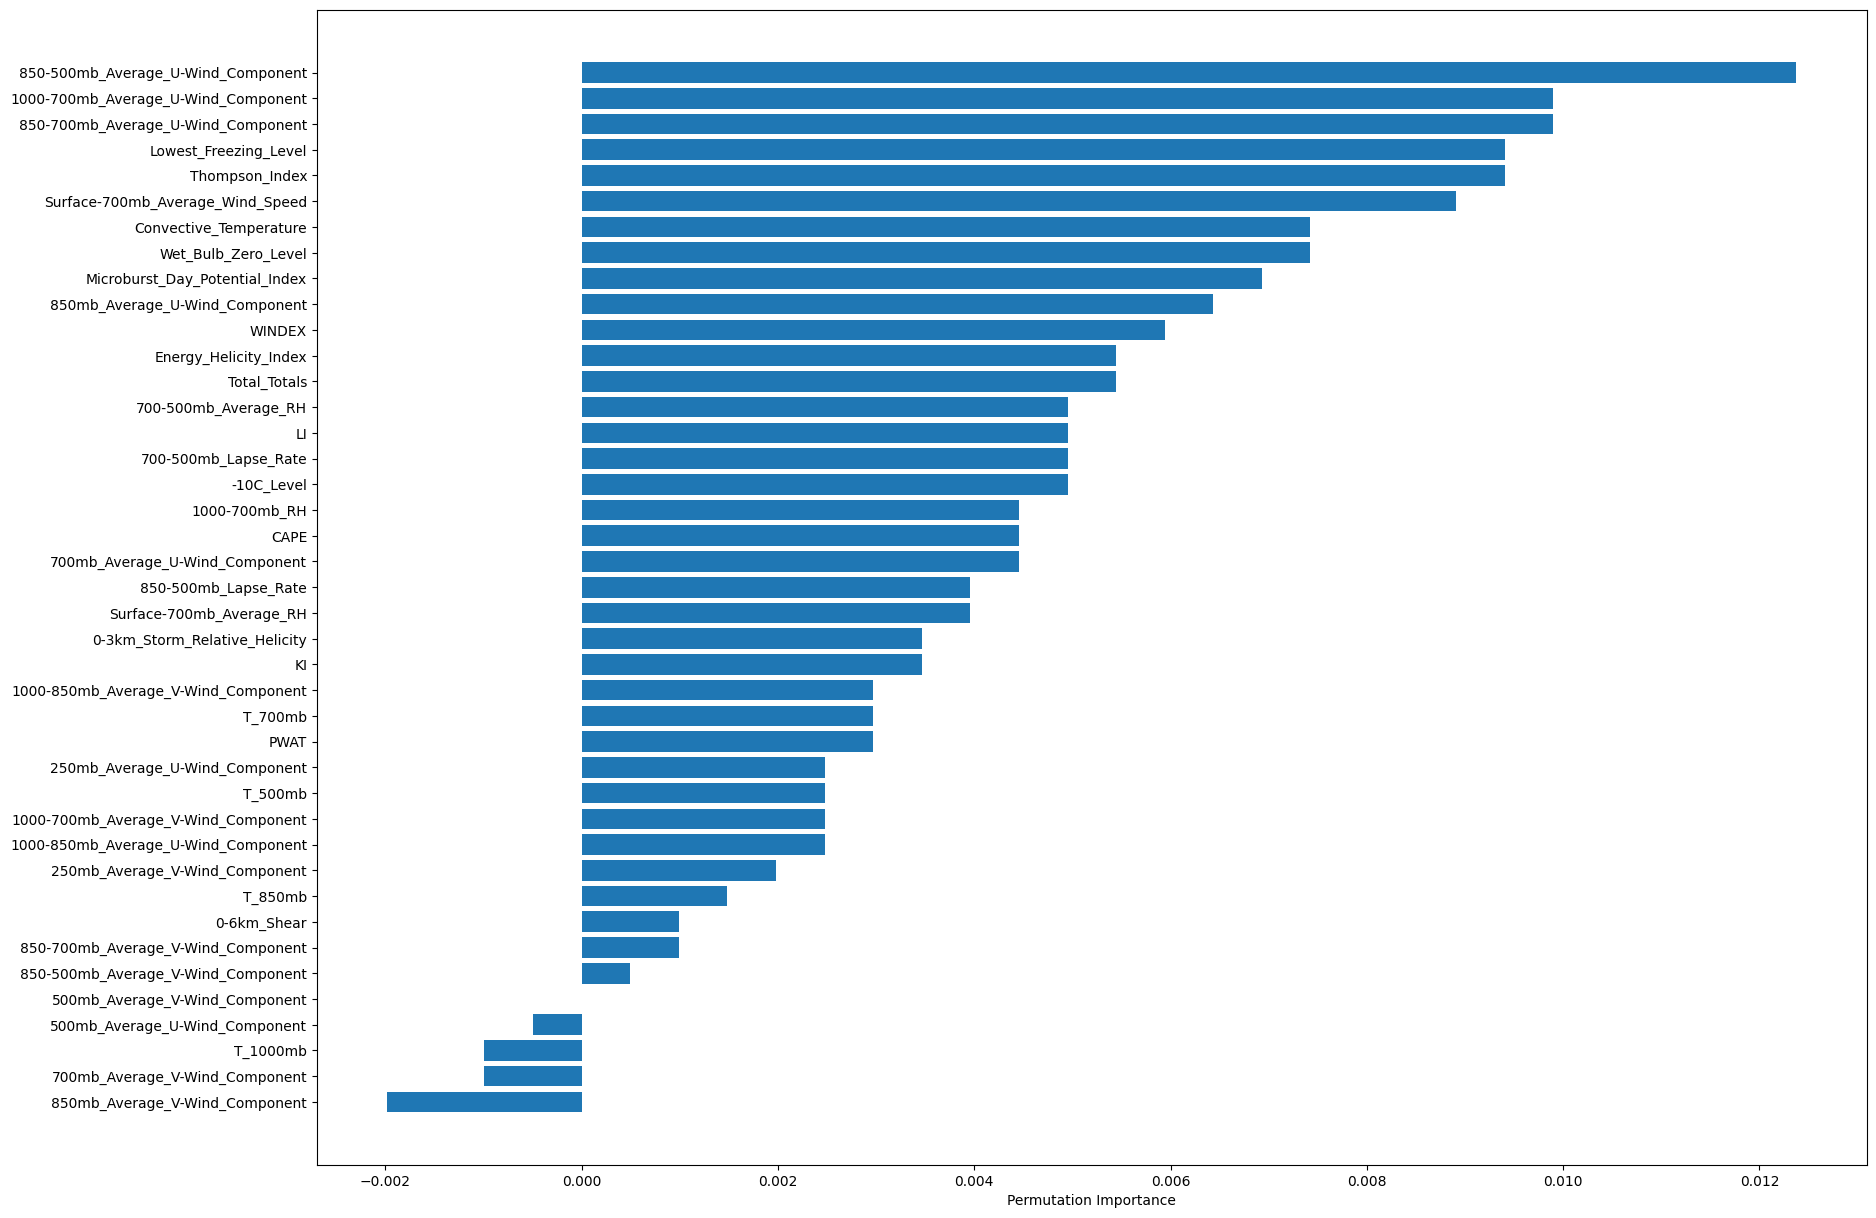

In [83]:
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(20, 15))
plt.barh(RFC_model_offshore.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Text(0.5, 0, 'RFC Offshore Feature Importance')

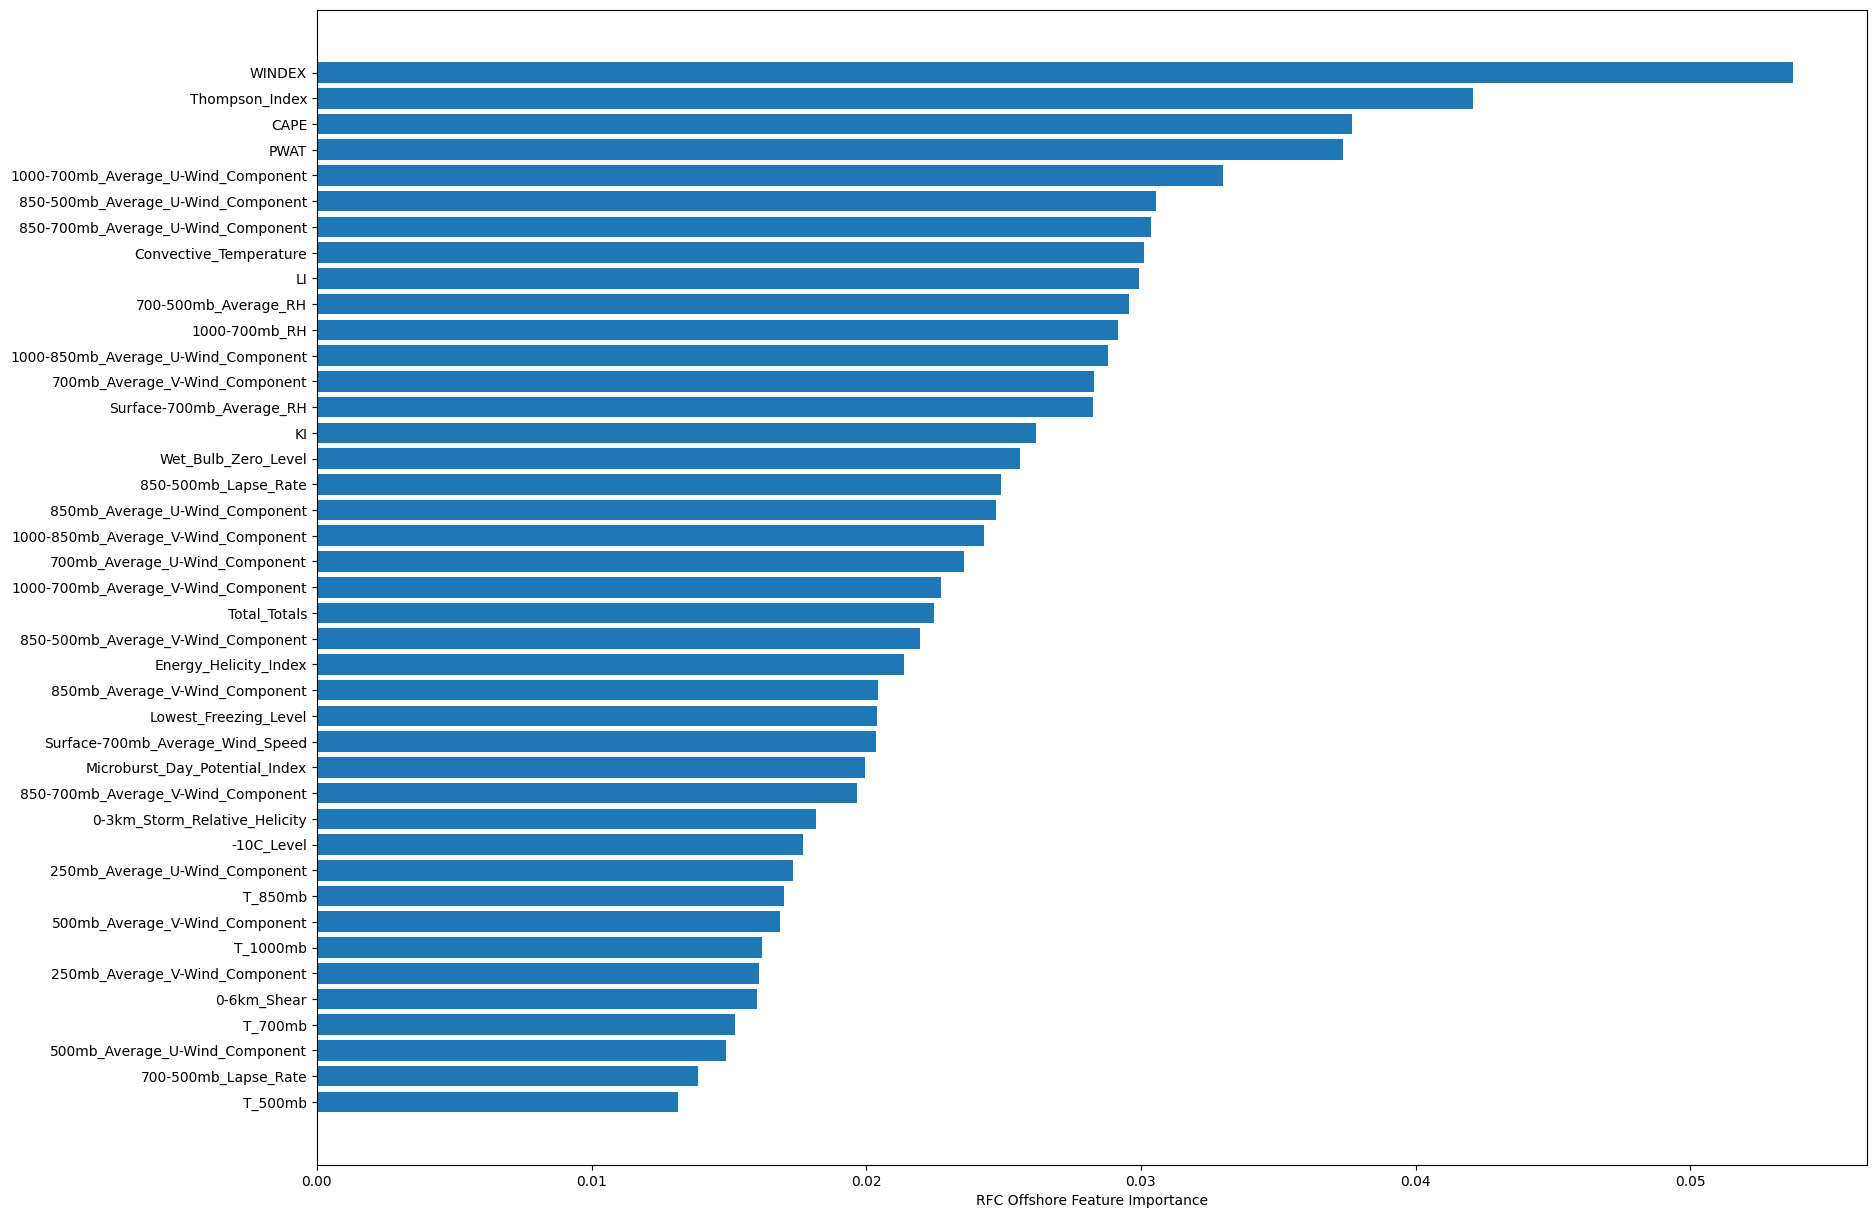

In [84]:
sorted_idx = RFC_model_offshore.feature_importances_.argsort()
plt.figure(figsize=(20, 15))
plt.barh(RFC_model_offshore.feature_names_in_[sorted_idx], RFC_model_offshore.feature_importances_[sorted_idx])
plt.xlabel("RFC Offshore Feature Importance")

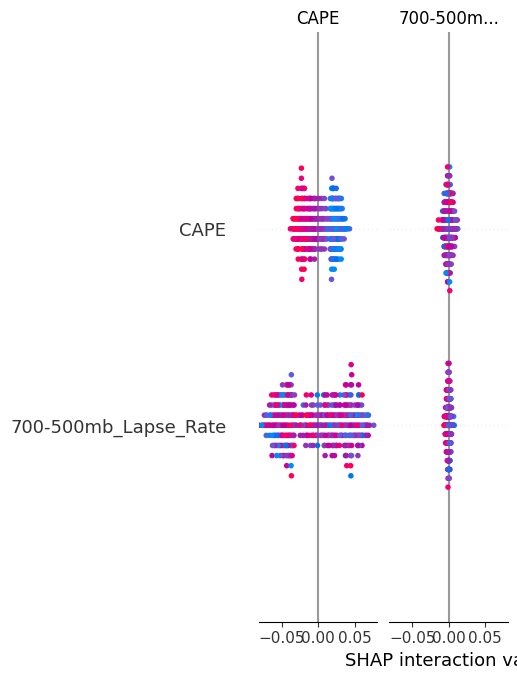

In [ ]:
explainer = shap.TreeExplainer(RFC_model_offshore)
shap_values = explainer.shap_values(X_test_offshore)

shap.summary_plot(shap_values, X_test_offshore, plot_type="bar")


#Random Forest Offshore Flow With Limited Features

In [ ]:
#X_train_limited = X_train_offshore[['Thompson_Index', '700-500mb_Average_RH',  'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component', '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Wet_Bulb_Zero_Level']].copy()
#X_test_limited = X_test_offshore[['Thompson_Index', '700-500mb_Average_RH',  'PWAT', 'WINDEX', '1000-850mb_Average_U-Wind_Component', '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Wet_Bulb_Zero_Level']].copy()

In [85]:
X_train_limited = X_train_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()
X_test_limited = X_test_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()

In [ ]:
#X_train_limited = X_train_offshore[['Thompson_Index', '700-500mb_Average_RH', 'PWAT', 'WINDEX',  '1000-700mb_Average_U-Wind_Component']].copy()
#X_test_limited = X_test_offshore[['Thompson_Index', '700-500mb_Average_RH', 'PWAT', 'WINDEX', '1000-700mb_Average_U-Wind_Component']].copy()


---Test Set Accuracy
0.7400990099009901

---Brier Score
0.17189945630292147

---Brier Skill Score
0.2215770490927762

---Confusion Matrix
[[251  20]
 [ 85  48]]

---Classification Report
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       271
           1       0.71      0.36      0.48       133

    accuracy                           0.74       404
   macro avg       0.73      0.64      0.65       404
weighted avg       0.73      0.74      0.71       404


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

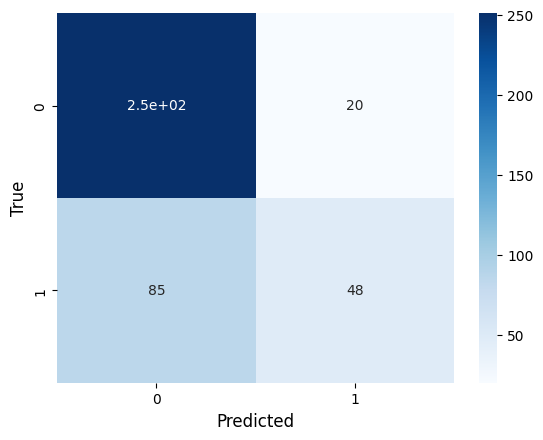

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

RFC_model_offshore = RandomForestClassifier(n_estimators=500,  criterion='entropy', max_features='sqrt',
                                 max_depth = 8, bootstrap=True, n_jobs=1,
                                 random_state=9)

RFC_model_offshore.fit(X_train_limited, y_train_offshore.values.ravel())
y_pred_offshore = RFC_model_offshore.predict(X_test_limited)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model_offshore.score(X_test_limited, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model_offshore.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = RFC_model_offshore.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)


---Test Set Accuracy
0.7301980198019802

---Brier Score
0.1723056820793765

---Brier Skill Score
0.21973751175831557

---Confusion Matrix
[[221  50]
 [ 59  74]]

---Classification Report
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       271
           1       0.60      0.56      0.58       133

    accuracy                           0.73       404
   macro avg       0.69      0.69      0.69       404
weighted avg       0.73      0.73      0.73       404


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

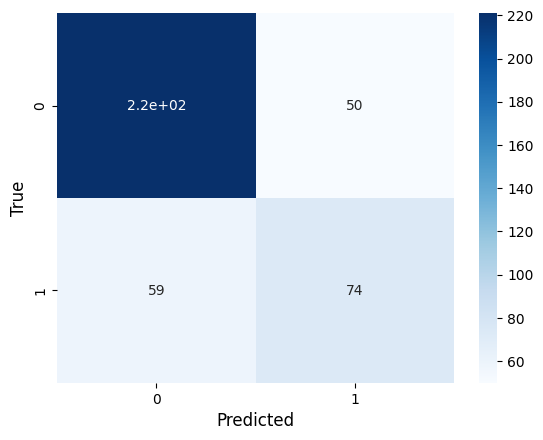

In [87]:
RFC_model_offshore_weights = RandomForestClassifier(n_estimators=500, class_weight= 'balanced', criterion='entropy', max_features='sqrt',
                                 max_depth = 8, bootstrap=True, n_jobs=1,
                                 random_state=9)

RFC_model_offshore_weights.fit(X_train_limited, y_train_offshore.values.ravel())
y_pred_offshore = RFC_model_offshore_weights.predict(X_test_limited)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(RFC_model_offshore_weights.score(X_test_limited, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = RFC_model_offshore_weights.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = RFC_model_offshore_weights.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

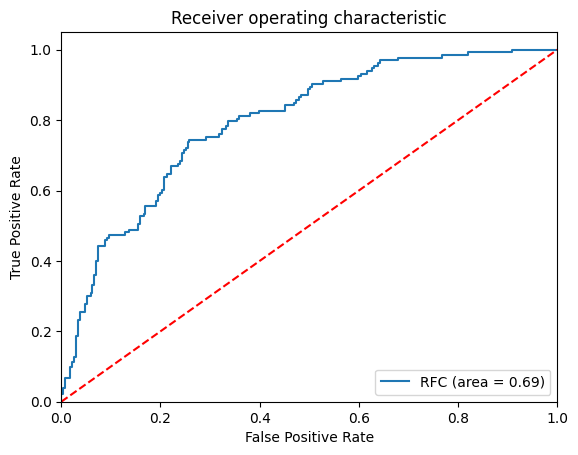

In [90]:
#Make the Roc Curve for test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rfc_roc_auc = roc_auc_score(y_test_offshore, RFC_model_offshore_weights.predict(X_test_limited))
fpr, tpr, thresholds = roc_curve(y_test_offshore, RFC_model_offshore_weights.predict_proba(X_test_limited)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', transparent=True)
plt.show()

Text(0.5, 1.0, 'Visualizing Important Features')

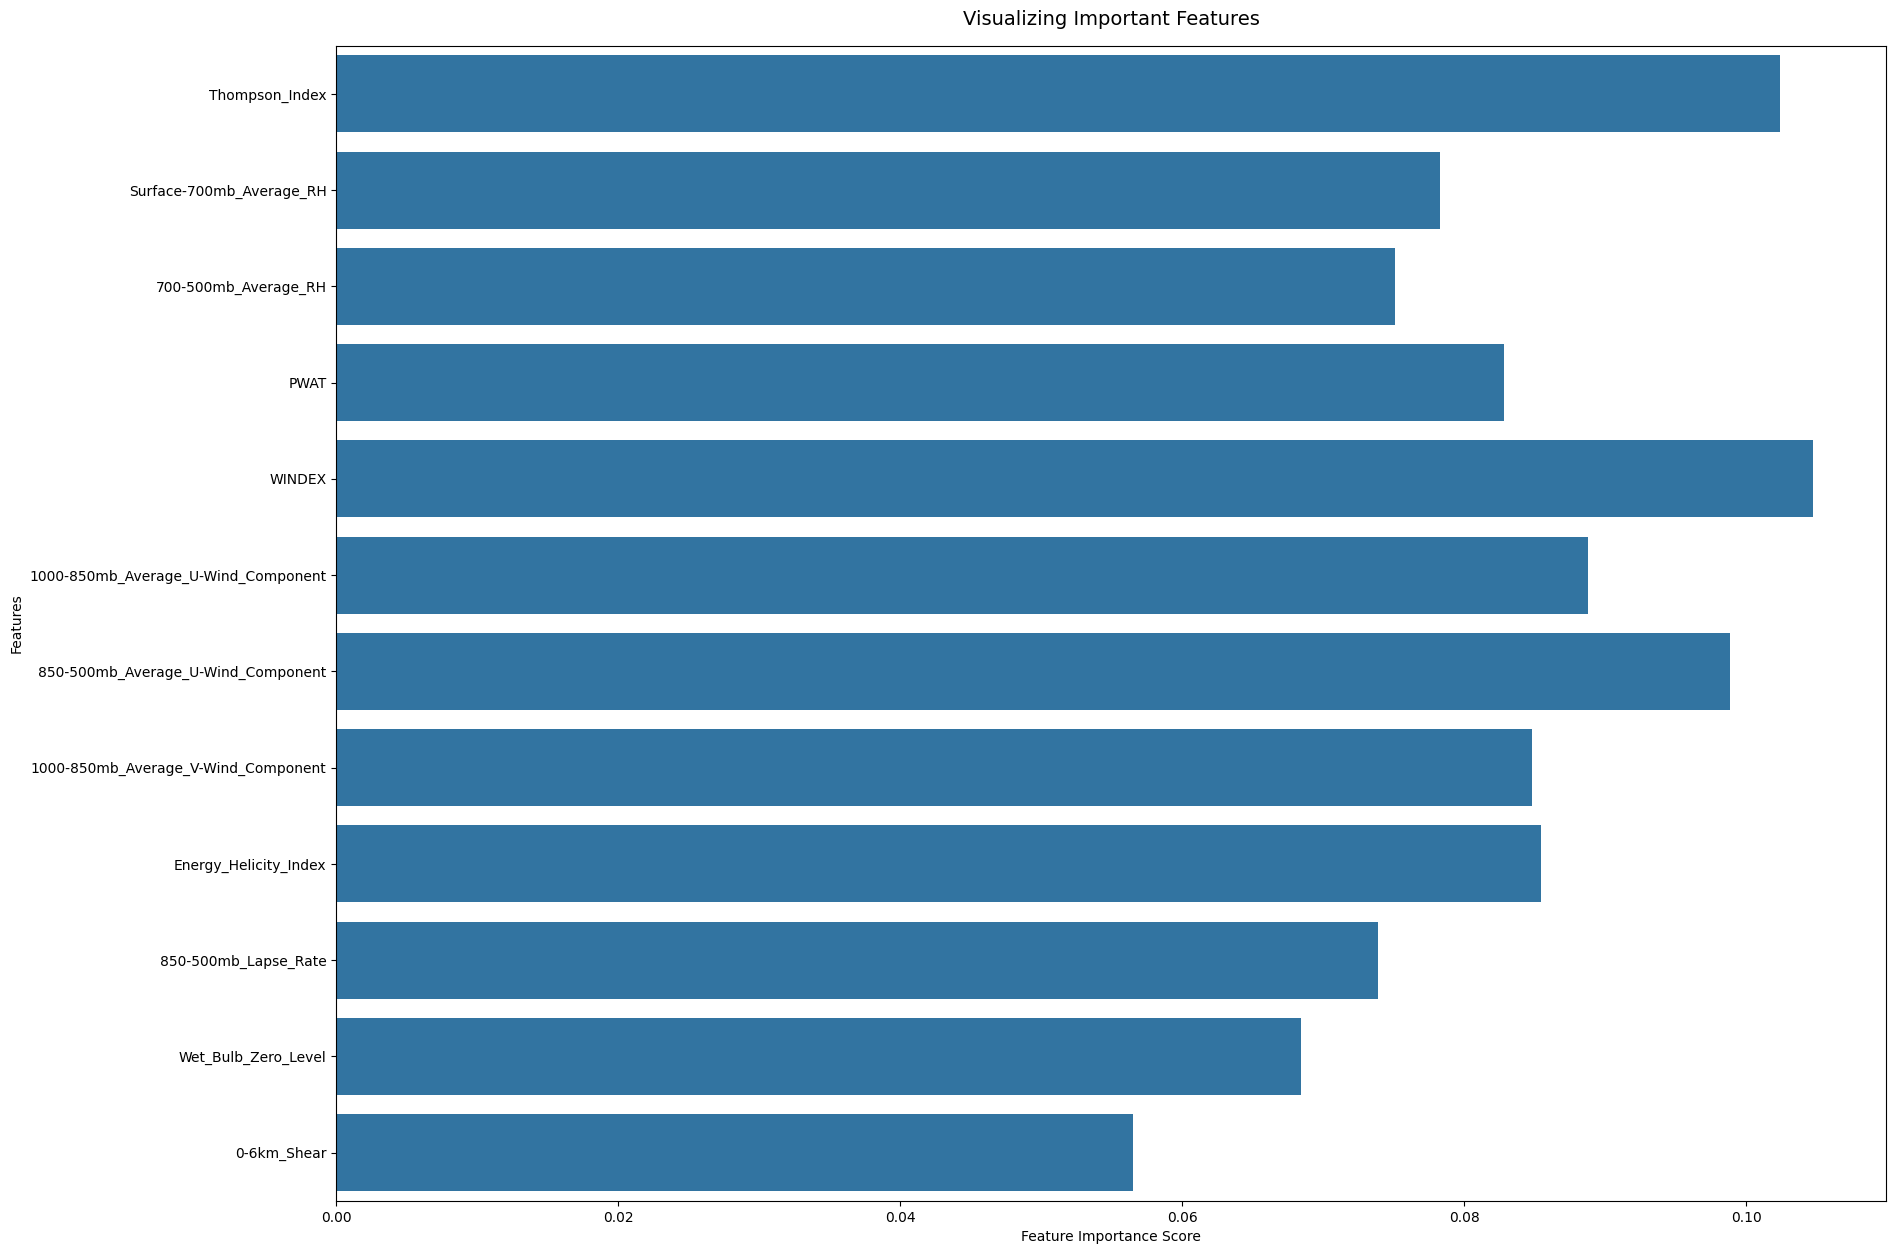

In [ ]:
feature_imp = pd.Series(RFC_model_offshore.feature_importances_, index = RFC_model_offshore.feature_names_in_)


plt.figure(figsize=(20,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)

In [ ]:
# prompt: Do a hyperparameter sweep on the Random Forest model RFC_model_offshore to maximize the f1-score on the test dataset

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(RFC_model_offshore, param_grid, scoring='f1', cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_offshore, y_train_offshore)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_offshore)

# Calculate the f1-score
f1 = f1_score(y_test_offshore, y_pred_offshore)

# Print the f1-score
print(f"Best f1-score: {f1}")

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")


In [ ]:
RFC_model_offshore.fit(X_train_limited, y_train_offshore.values.ravel())
y_pred_offshore = RFC_model_offshore.predict(X_test_limited)

Calibrating the Random Forest Classifier

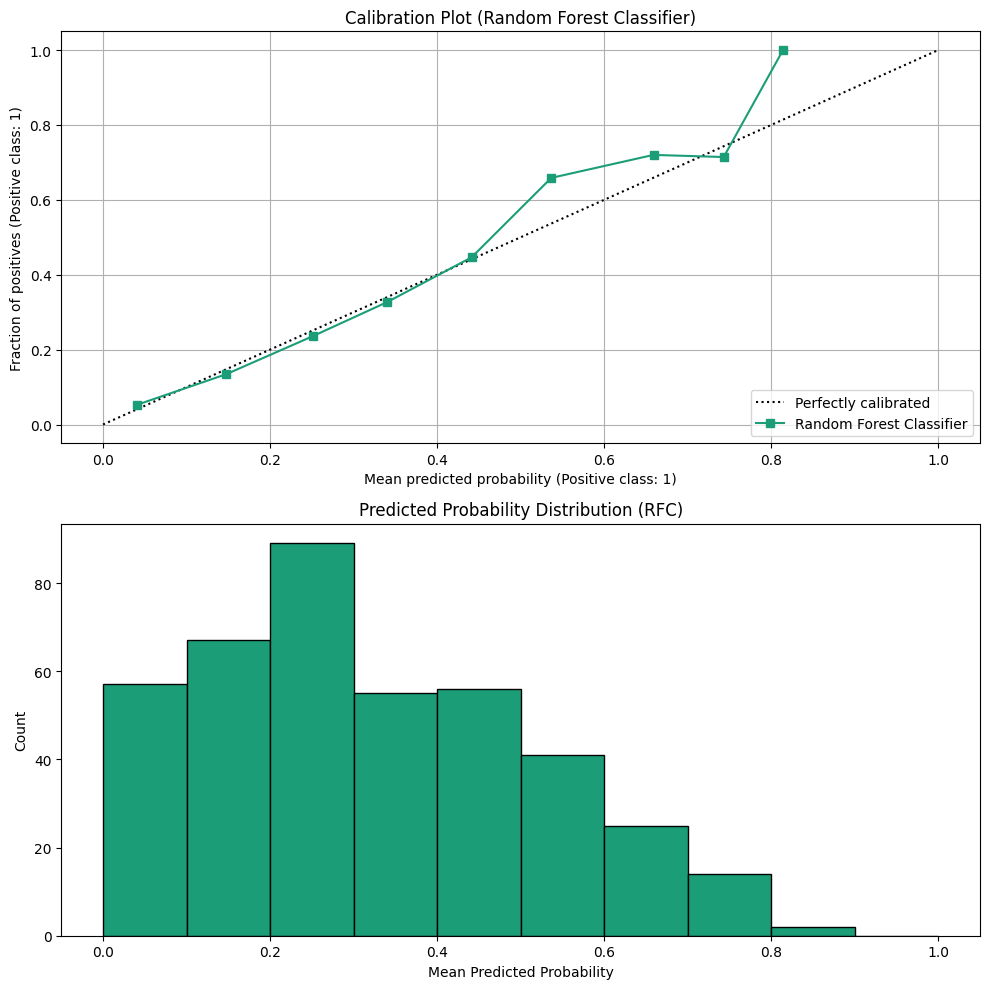

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

# Generate predictions
y_prob = RFC_model_offshore.predict_proba(X_test_limited)[:, 1]  # Probability for the positive class

# Create figure and grid
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
color = plt.cm.Dark2(0)  # Single color for the RFC plot

# Calibration curve plot
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
CalibrationDisplay.from_predictions(
    y_test_offshore,
    y_prob,
    n_bins=10,
    name="Random Forest Classifier",
    ax=ax_calibration_curve,
    color=color,
)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Random Forest Classifier)")

# Histogram plot
ax_hist = fig.add_subplot(gs[2:, :])
ax_hist.hist(
    y_prob,
    range=(0, 1),
    bins=10,
    color=color,
    edgecolor='black'
)
ax_hist.set(
    title="Predicted Probability Distribution (RFC)",
    xlabel="Mean Predicted Probability",
    ylabel="Count"
)

plt.tight_layout()
plt.show()


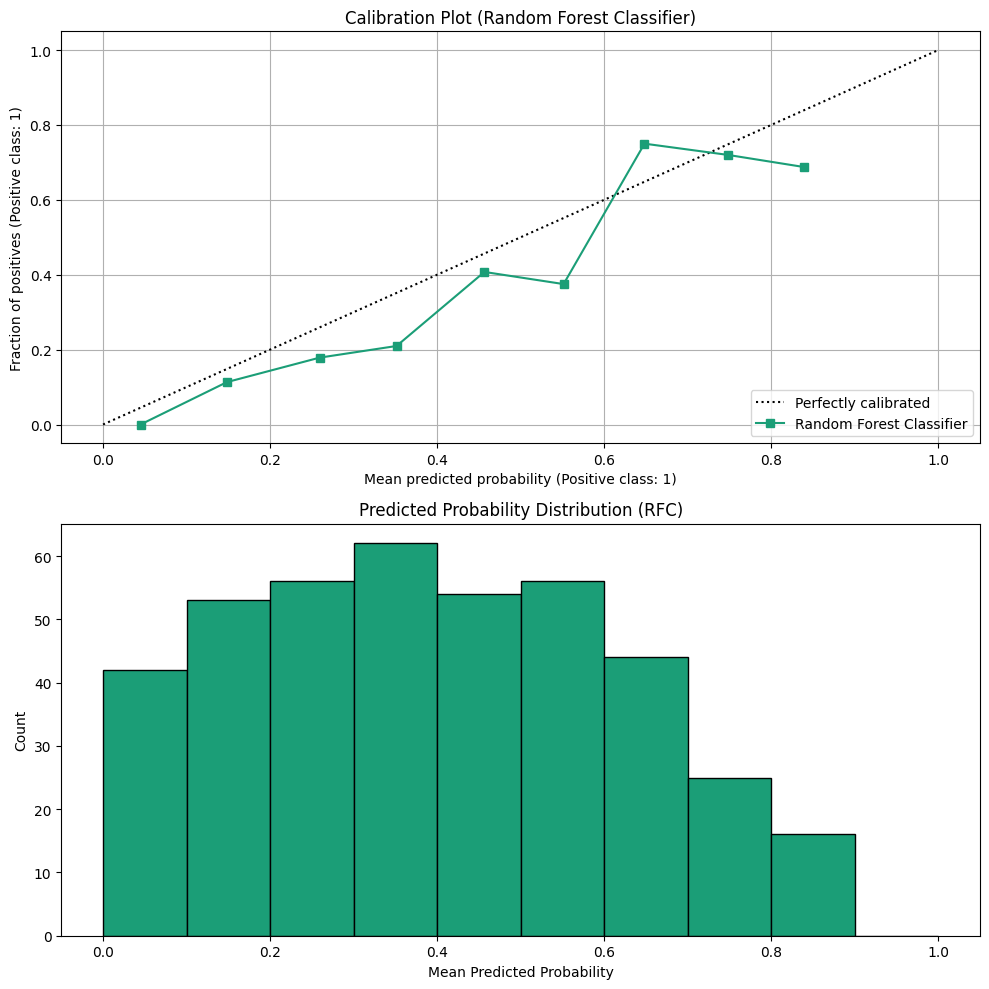

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

# Generate predictions
y_prob = RFC_model_offshore_weights.predict_proba(X_test_limited)[:, 1]  # Probability for the positive class

# Create figure and grid
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
color = plt.cm.Dark2(0)  # Single color for the RFC plot

# Calibration curve plot
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
CalibrationDisplay.from_predictions(
    y_test_offshore,
    y_prob,
    n_bins=10,
    name="Random Forest Classifier",
    ax=ax_calibration_curve,
    color=color,
)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Random Forest Classifier)")

# Histogram plot
ax_hist = fig.add_subplot(gs[2:, :])
ax_hist.hist(
    y_prob,
    range=(0, 1),
    bins=10,
    color=color,
    edgecolor='black'
)
ax_hist.set(
    title="Predicted Probability Distribution (RFC)",
    xlabel="Mean Predicted Probability",
    ylabel="Count"
)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
#from sklearn.naive_bayes import GaussianNB

# With no calibration
prob_no_calib = RFC_model_offshore.predict_proba(X_test_limited)[:, 1]

# With isotonic calibration
RFC_isotonic = CalibratedClassifierCV(RFC_model_offshore, cv=5, method="isotonic")
RFC_isotonic.fit(X_train_limited, y_train_offshore)
prob_pos_isotonic = RFC_isotonic.predict_proba(X_test_limited)[:, 1]

# With sigmoid calibration
RFC_sigmoid = CalibratedClassifierCV(RFC_model_offshore, cv=5, method="sigmoid")
RFC_sigmoid.fit(X_train_limited, y_train_offshore)
prob_pos_sigmoid = RFC_sigmoid.predict_proba(X_test_limited)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test_offshore, prob_no_calib)
print("No calibration: %1.3f" % clf_score)

RFC_isotonic_score = brier_score_loss(y_test_offshore, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % RFC_isotonic_score)

RFC_sigmoid_score = brier_score_loss(y_test_offshore, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % RFC_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.171
With isotonic calibration: 0.169
With sigmoid calibration: 0.169


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
#from sklearn.naive_bayes import GaussianNB

# With no calibration
prob_no_calib = RFC_model_offshore_weights.predict_proba(X_test_limited)[:, 1]

# With isotonic calibration
RFC_isotonic = CalibratedClassifierCV(RFC_model_offshore_weights, cv=5, method="isotonic")
RFC_isotonic.fit(X_train_limited, y_train_offshore)
prob_pos_isotonic = RFC_isotonic.predict_proba(X_test_limited)[:, 1]

# With sigmoid calibration
RFC_sigmoid = CalibratedClassifierCV(RFC_model_offshore_weights, cv=5, method="sigmoid")
RFC_sigmoid.fit(X_train_limited, y_train_offshore)
prob_pos_sigmoid = RFC_sigmoid.predict_proba(X_test_limited)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test_offshore, prob_no_calib)
print("No calibration: %1.3f" % clf_score)

RFC_isotonic_score = brier_score_loss(y_test_offshore, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % RFC_isotonic_score)

RFC_sigmoid_score = brier_score_loss(y_test_offshore, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % RFC_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.172
With isotonic calibration: 0.168
With sigmoid calibration: 0.169


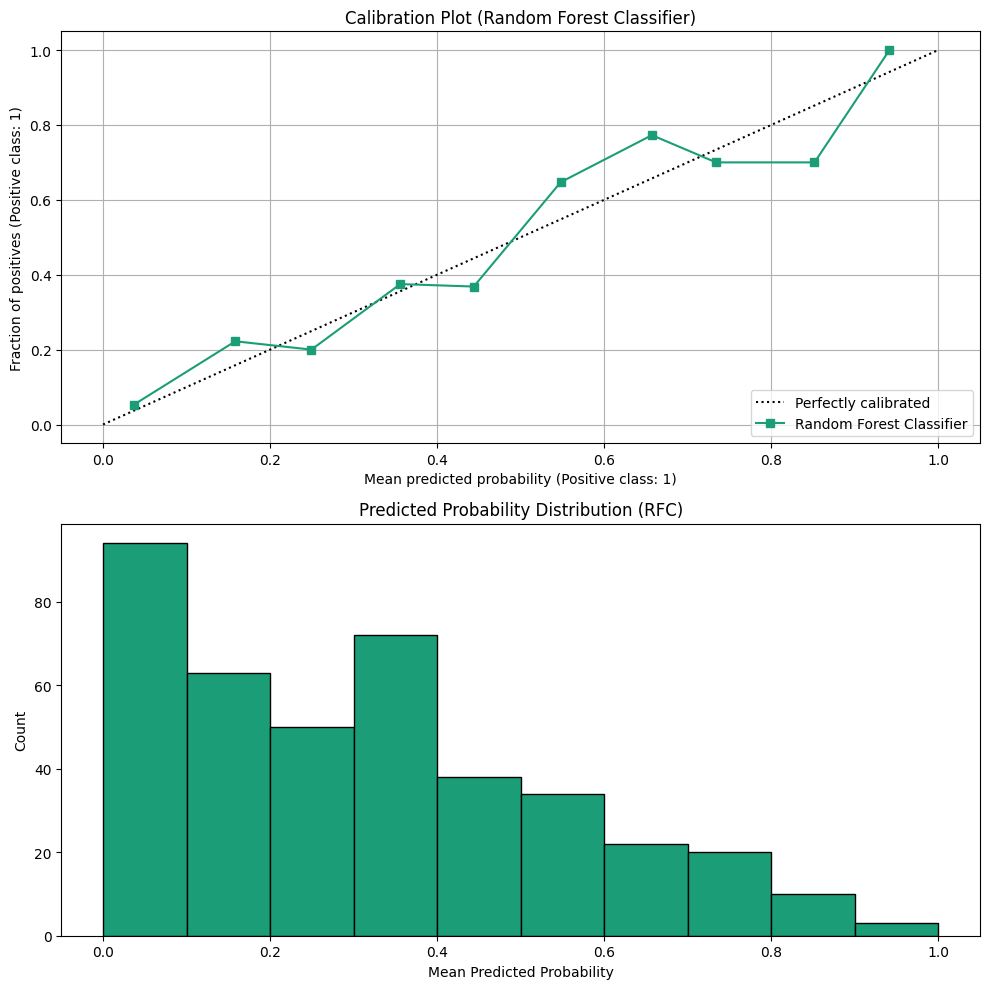

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

# Generate predictions
y_prob = RFC_isotonic.predict_proba(X_test_limited)[:, 1]  # Probability for the positive class

# Create figure and grid
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
color = plt.cm.Dark2(0)  # Single color for the RFC plot

# Calibration curve plot
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
CalibrationDisplay.from_predictions(
    y_test_offshore,
    y_prob,
    n_bins=10,
    name="Random Forest Classifier",
    ax=ax_calibration_curve,
    color=color,
)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Random Forest Classifier)")

# Histogram plot
ax_hist = fig.add_subplot(gs[2:, :])
ax_hist.hist(
    y_prob,
    range=(0, 1),
    bins=10,
    color=color,
    edgecolor='black'
)
ax_hist.set(
    title="Predicted Probability Distribution (RFC)",
    xlabel="Mean Predicted Probability",
    ylabel="Count"
)

plt.tight_layout()
plt.show()

# XG Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1, random_state=39)
gradient_booster.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 39,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#gradient_booster.fit(X_train,y_train)
gradient_booster.fit(X_train_offshore,y_train_offshore)
#RFC_model.fit(X_train_RFC, y_train)
#y_pred = RFC_model.predict(X_test_RFC)
print(classification_report(y_test,gradient_booster.predict(X_test)))



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       563
           1       0.88      0.59      0.71       165

    accuracy                           0.89       728
   macro avg       0.88      0.78      0.82       728
weighted avg       0.89      0.89      0.88       728



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



---Test Set Accuracy
0.7216748768472906

---Brier Score
0.1801775653663819

---Brier Skill Score

---Confusion Matrix
[[240  33]
 [ 80  53]]

---Classification Report
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       273
           1       0.62      0.40      0.48       133

    accuracy                           0.72       406
   macro avg       0.68      0.64      0.65       406
weighted avg       0.71      0.72      0.70       406


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

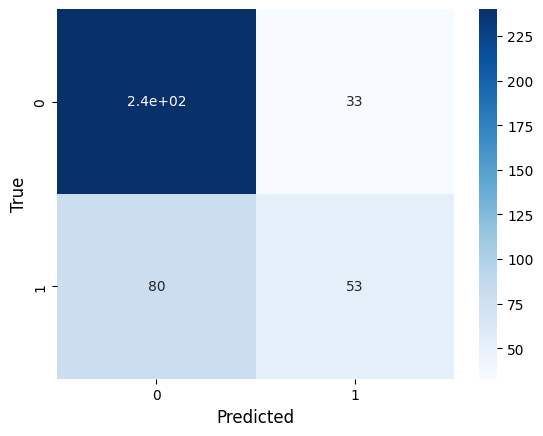

In [ ]:

gradient_booster.fit(X_train_offshore,y_train_offshore)
y_pred_offshore = gradient_booster.predict(X_test_offshore)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(gradient_booster.score(X_test_offshore, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = gradient_booster.predict_proba(X_test_offshore)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")

# calculate brier skillscore
#offshore_severe_pct_array = np.full(len(y_test), offshore_severe_pct)
#brier_climo = brier_score_loss(y_test, offshore_severe_pct_array)
#BSS = 1 - (brier_raw / brier_climo)
#print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))
#RFC_model.predict_proba(X_test_RFC)

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

Text(0.5, 0, 'Xgboost Feature Importance')

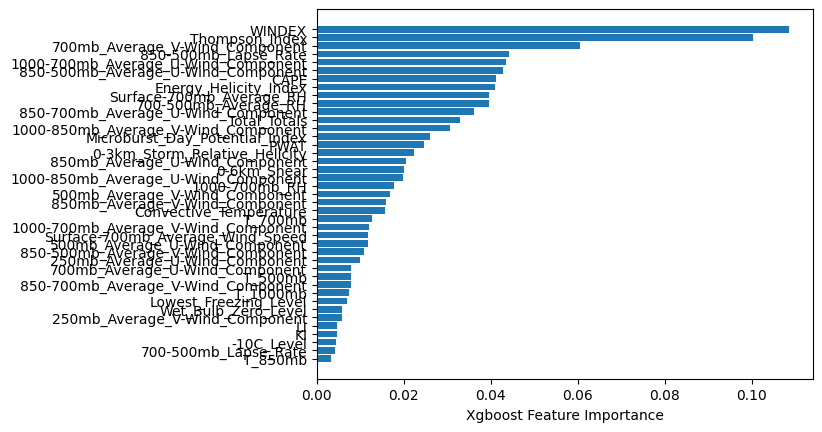

In [ ]:
sorted_idx = gradient_booster.feature_importances_.argsort()

plt.barh(gradient_booster.feature_names_in_[sorted_idx], gradient_booster.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
#index = RFC_model_offshore.feature_names_in_

In [ ]:
import numpy as np
import pandas as pd
import shap

from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

perm_importance = permutation_importance(gradient_booster, X_test_offshore, y_test_offshore)

In [ ]:
perm_importance.importances_mean[sorted_idx]

array([ 0.00000000e+00, -4.90196078e-04,  4.90196078e-04, -2.94117647e-03,
        9.80392157e-03, -4.90196078e-03, -9.80392157e-04,  4.90196078e-03,
       -4.41176471e-03, -4.90196078e-04, -5.88235294e-03, -2.94117647e-03,
       -4.90196078e-03,  4.41176471e-03, -9.80392157e-04, -7.35294118e-03,
       -3.43137255e-03,  0.00000000e+00, -9.80392157e-03,  4.90196078e-03,
       -2.94117647e-03, -6.37254902e-03, -2.22044605e-17, -1.42156863e-02,
       -1.07843137e-02,  1.47058824e-03, -7.35294118e-03,  1.47058824e-03,
       -3.43137255e-03,  4.90196078e-04, -8.33333333e-03, -2.45098039e-03,
       -2.22044605e-17,  1.81372549e-02,  9.80392157e-03,  7.84313725e-03,
       -5.39215686e-03,  1.61764706e-02,  1.17647059e-02,  8.82352941e-03,
        1.47058824e-03])

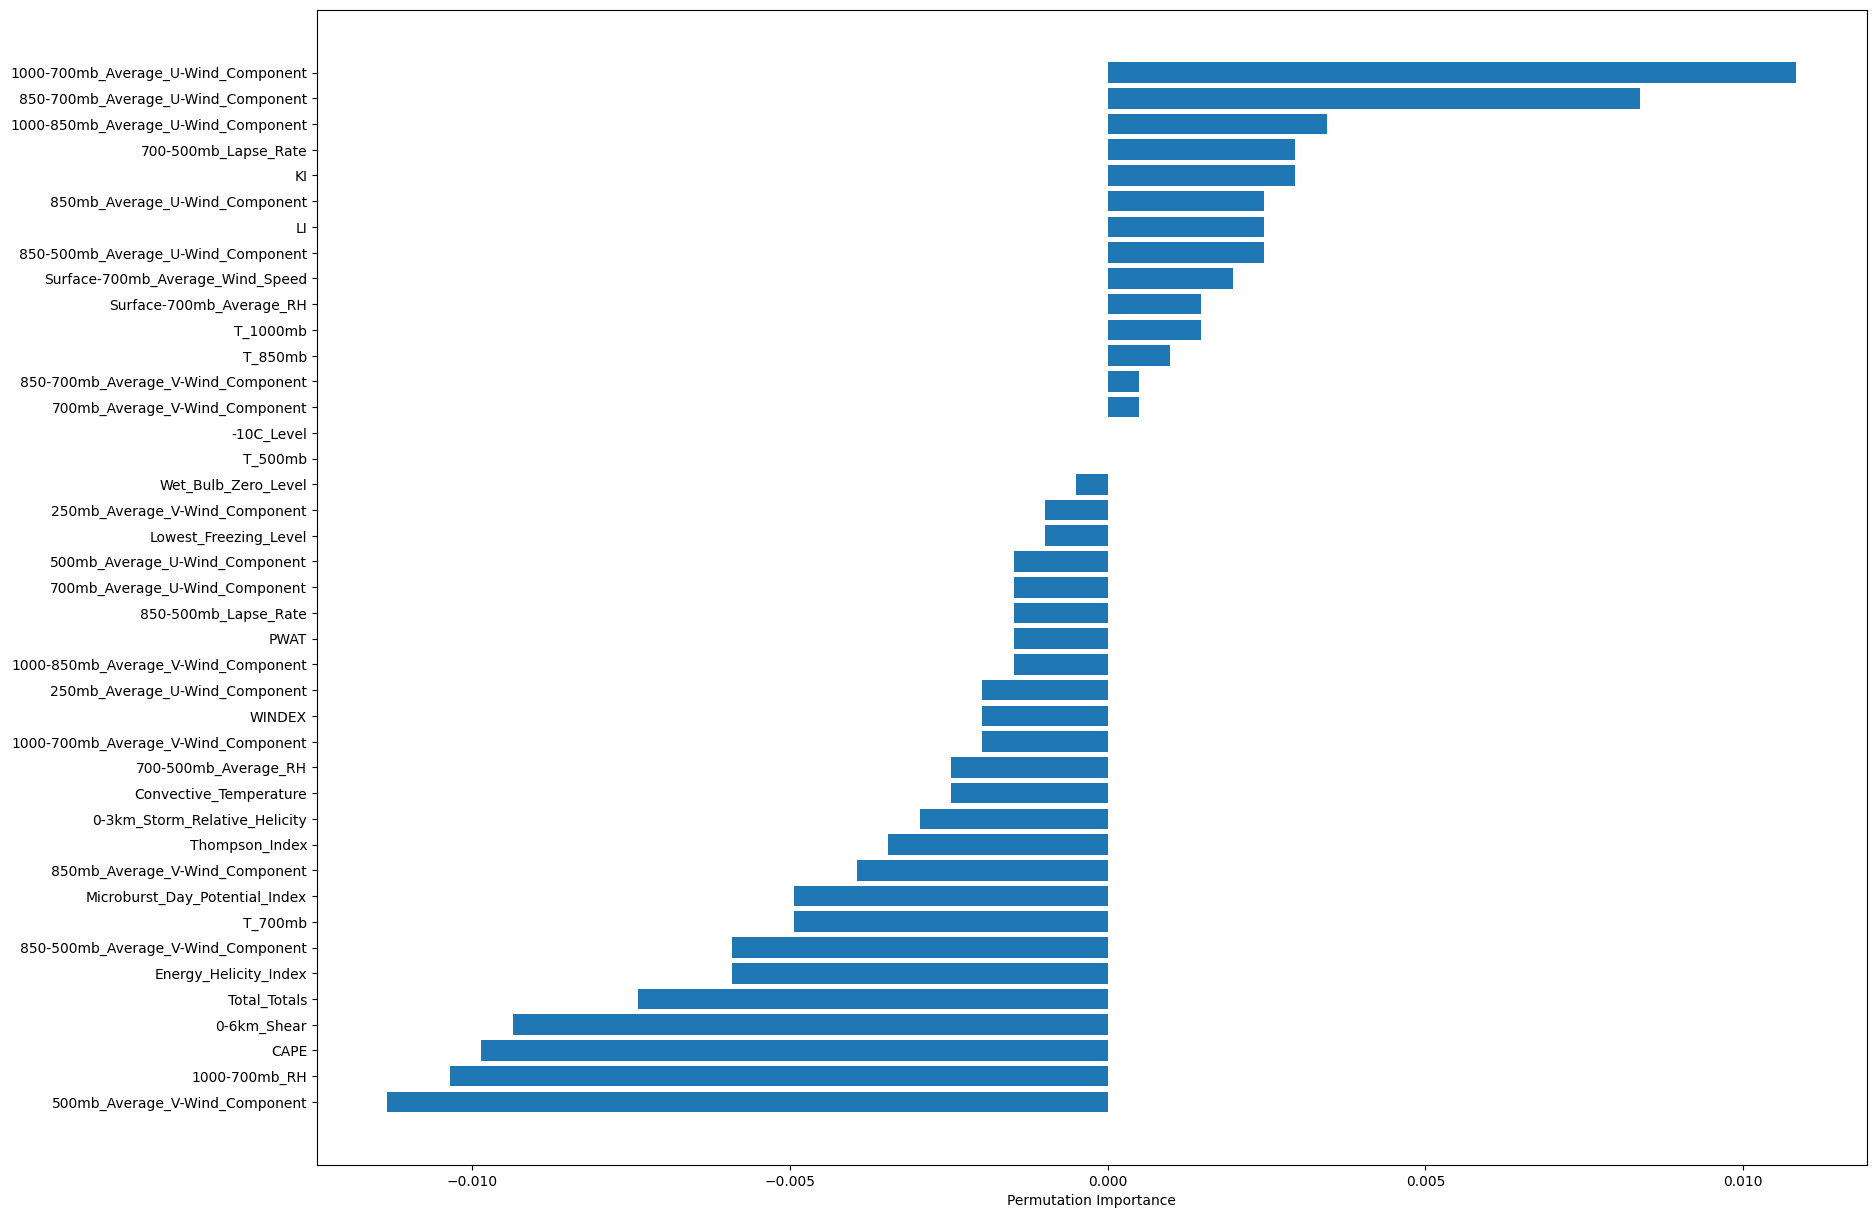

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(20, 15))
plt.barh(gradient_booster.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
sorted_idx

array([28,  9, 25, 32,  8,  3, 10, 18, 41,  1, 19, 36, 20, 38, 31, 34, 17,
       21, 16, 39,  2,  4, 24, 14,  7, 30,  6, 29, 40, 33, 26, 27, 37, 22,
       11,  5, 13, 12,  0, 35, 15, 23, 42])

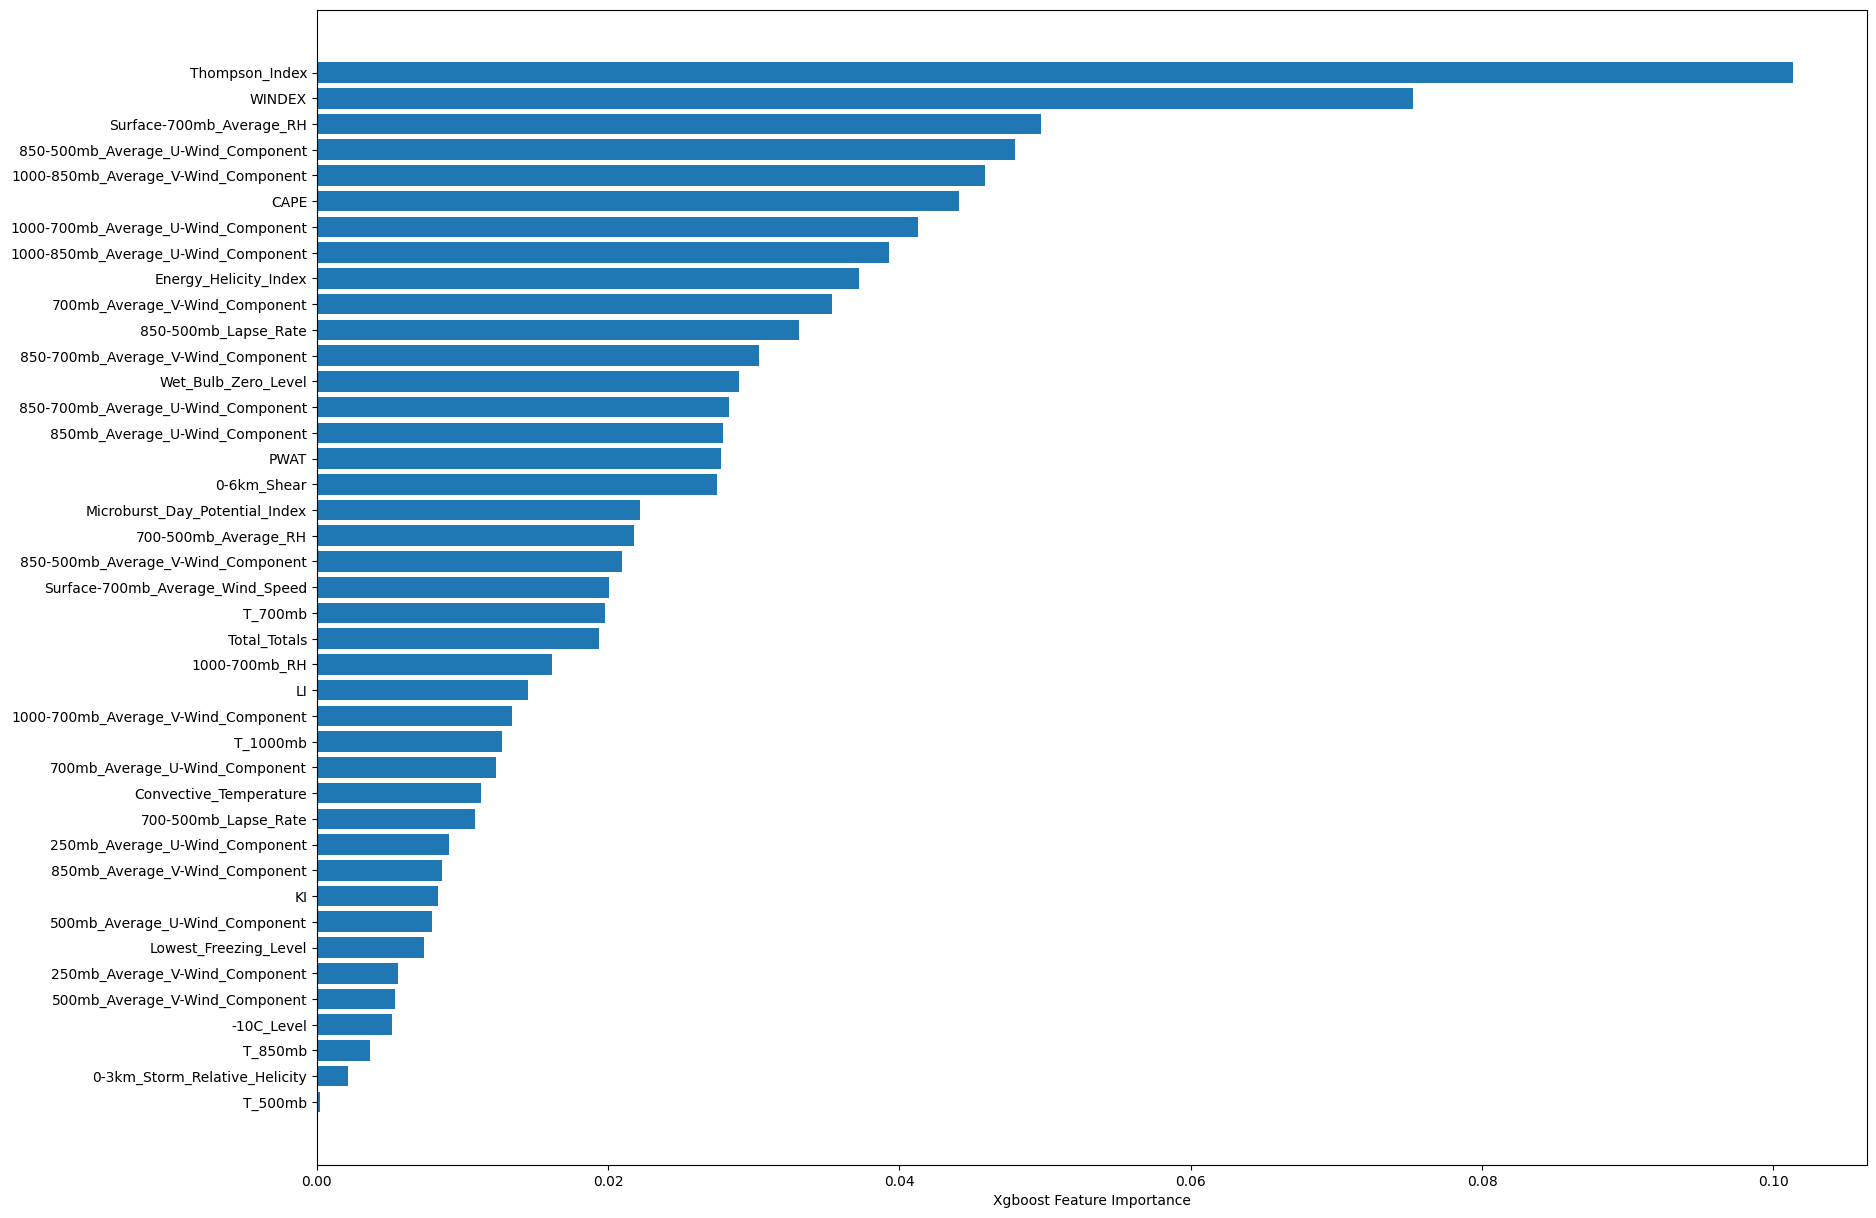

In [ ]:
# prompt: Use the same code as above, but make the image output bigger

import matplotlib.pyplot as plt

# Make the figure larger
plt.figure(figsize=(20, 15))

# Use the same code as above to plot the feature importances
sorted_idx = gradient_booster.feature_importances_.argsort()
plt.barh(gradient_booster.feature_names_in_[sorted_idx], gradient_booster.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.feature_selection import SelectFromModel
from numpy import sort

import warnings
warnings.filterwarnings("ignore")

# make predictions for test data and evaluate
predictions = gradient_booster.predict(X_test_offshore)
predictions_prob = gradient_booster.predict_proba(X_test_offshore)[:, 1]
accuracy = accuracy_score(y_test_offshore, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(gradient_booster.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(gradient_booster, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train_offshore)
 # train model
 selection_model = GradientBoostingClassifier(learning_rate=0.1, random_state=39)
 selection_model.fit(select_X_train, y_train_offshore)
 # eval model
 select_X_test = selection.transform(X_test_offshore)
 predictions = selection_model.predict(select_X_test)
 predictions_prob = selection_model.predict_proba(select_X_test)[:, 1]
 accuracy = accuracy_score(y_test_offshore, predictions)
 f1score = f1_score(y_test_offshore, predictions)
 brier = brier_score_loss(y_test_offshore, predictions_prob)

 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, f1 Score: %.2f%%, brier: %.3f  " % (thresh, select_X_train.shape[1], accuracy*100.0, f1score*100.0, brier ))

Accuracy: 72.17%
Thresh=0.003, n=41, Accuracy: 72.17%, f1 Score: 48.40%, brier: 0.180  
Thresh=0.004, n=40, Accuracy: 72.41%, f1 Score: 48.15%, brier: 0.181  
Thresh=0.004, n=39, Accuracy: 73.65%, f1 Score: 51.14%, brier: 0.178  
Thresh=0.005, n=38, Accuracy: 72.66%, f1 Score: 49.77%, brier: 0.179  
Thresh=0.005, n=37, Accuracy: 72.91%, f1 Score: 50.00%, brier: 0.180  
Thresh=0.006, n=36, Accuracy: 73.89%, f1 Score: 51.38%, brier: 0.180  
Thresh=0.006, n=35, Accuracy: 73.15%, f1 Score: 49.77%, brier: 0.182  
Thresh=0.007, n=34, Accuracy: 73.15%, f1 Score: 50.23%, brier: 0.180  
Thresh=0.007, n=33, Accuracy: 72.41%, f1 Score: 49.09%, brier: 0.179  
Thresh=0.008, n=32, Accuracy: 74.14%, f1 Score: 54.55%, brier: 0.176  
Thresh=0.008, n=31, Accuracy: 72.17%, f1 Score: 49.33%, brier: 0.181  
Thresh=0.008, n=30, Accuracy: 73.65%, f1 Score: 52.44%, brier: 0.180  
Thresh=0.010, n=29, Accuracy: 73.89%, f1 Score: 52.25%, brier: 0.176  
Thresh=0.011, n=28, Accuracy: 73.65%, f1 Score: 51.14%, brie

In [ ]:
# prompt: Find the optimal combination of the above features to maximize the f1 score and minimize the brier score. Test all number of features from 15 of them to just 1. Also output what those features names are.

from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss

# Initialize variables
max_f1 = 0
min_brier = 100
best_features = []

# Loop through all possible number of features
for num_features in range(1, 30):
    # Select the top num_features features
    selector = SelectKBest(k=num_features)
    X_train_selected = selector.fit_transform(X_train_offshore, y_train_offshore)
    X_test_selected = selector.transform(X_test_offshore)

    # Train the model
    gradient_booster.fit(X_train_selected, y_train_offshore)

    # Make predictions
    predictions = gradient_booster.predict(X_test_selected)
    predictions_prob = gradient_booster.predict_proba(X_test_selected)[:, 1]

    # Calculate the f1 score and brier score
    f1 = f1_score(y_test_offshore, predictions)
    brier = brier_score_loss(y_test_offshore, predictions_prob)

    # Check if the f1 score is the highest or the brier score is the lowest
    if f1 > max_f1:
        max_f1 = f1
        best_features = selector.get_support()
    if brier < min_brier:
        min_brier = brier
        best_features = selector.get_support()

# Print the results
print("Maximum f1 score:", max_f1)
print("Minimum brier score:", min_brier)
print("Best features:", X_train_offshore.columns[best_features])


Maximum f1 score: 0.5118483412322274
Minimum brier score: 0.1784770335478717
Best features: Index(['CAPE', '850-500mb_Lapse_Rate', 'LI', 'KI', 'Thompson_Index', 'Total_Totals', 'T_1000mb', 'T_850mb', 'Convective_Temperature', 'PWAT', '700-500mb_Average_RH', 'Surface-700mb_Average_Wind_Speed', '1000-700mb_Average_U-Wind_Component', '1000-700mb_Average_V-Wind_Component', '1000-850mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', '850-700mb_Average_U-Wind_Component', '850-700mb_Average_V-Wind_Component', '850-500mb_Average_V-Wind_Component', '850mb_Average_U-Wind_Component', '850mb_Average_V-Wind_Component', '700mb_Average_U-Wind_Component', '700mb_Average_V-Wind_Component', '500mb_Average_V-Wind_Component', '0-3km_Storm_Relative_Helicity', 'Wet_Bulb_Zero_Level', 'Energy_Helicity_Index', 'Microburst_Day_Potential_Index'], dtype='object')


In [ ]:
explainer = shap.TreeExplainer(gradient_booster)
shap_values = explainer.shap_values(X_test_offshore)

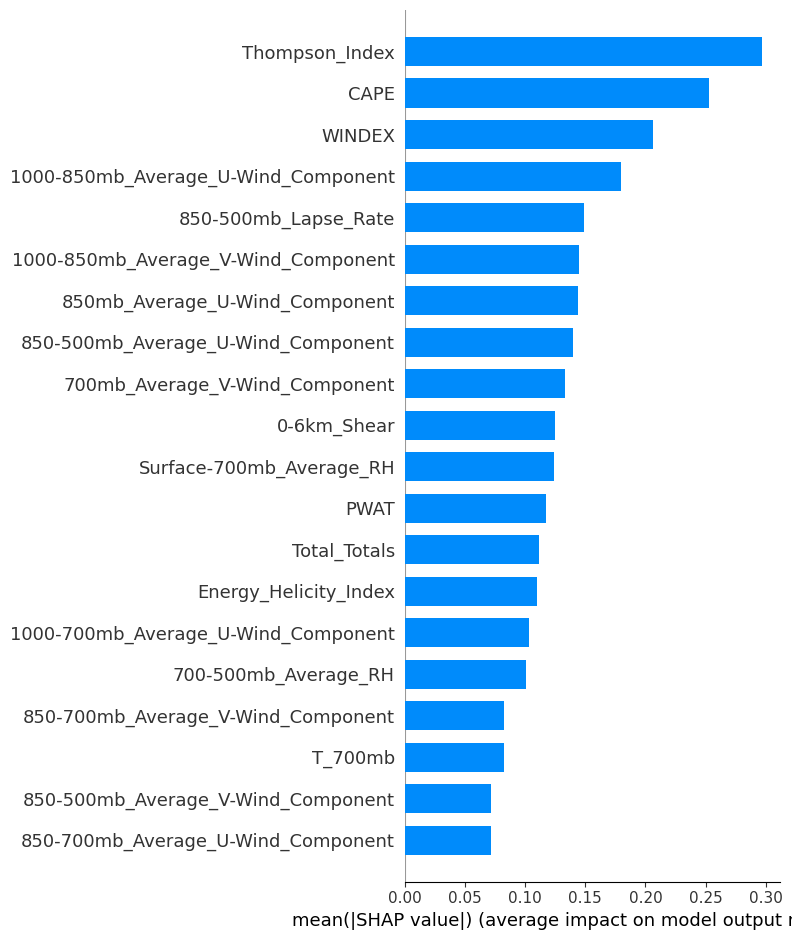

In [ ]:
shap.summary_plot(shap_values, X_test_offshore, plot_type="bar")

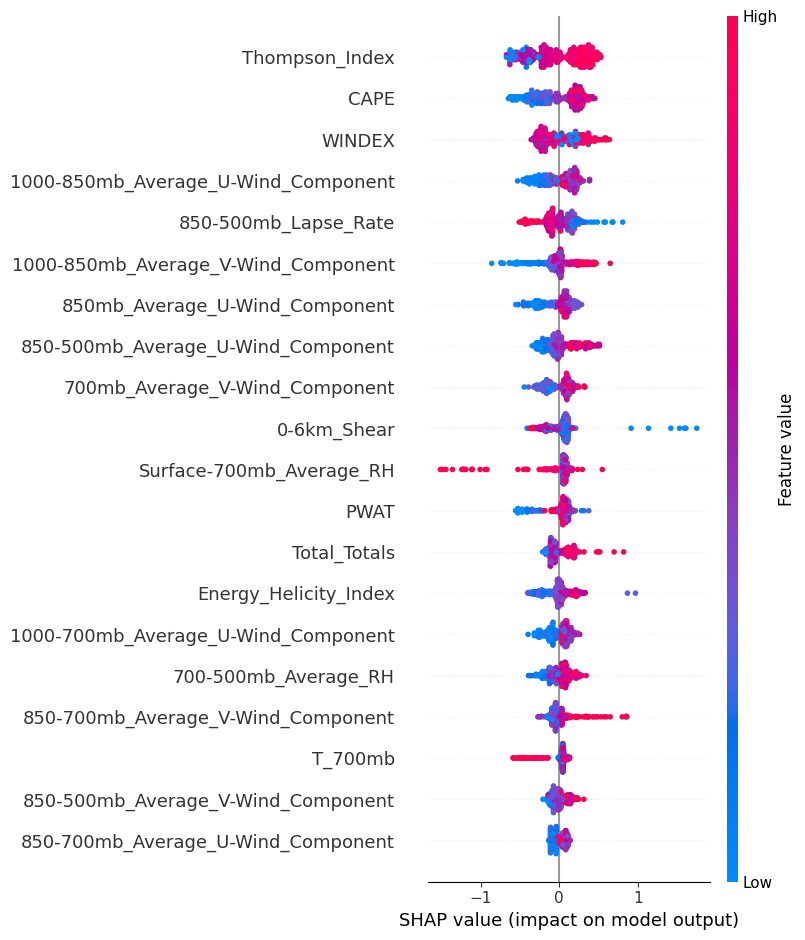

In [ ]:
shap.summary_plot(shap_values, X_test_offshore)

In [ ]:
shap_values

<function ndarray.mean>

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.feature_selection import SelectFromModel
from numpy import sort

import warnings
warnings.filterwarnings("ignore")

# make predictions for test data and evaluate
predictions = gradient_booster.predict(X_test_offshore)
predictions_prob = gradient_booster.predict_proba(X_test_offshore)[:, 1]
accuracy = accuracy_score(y_test_offshore, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(gradient_booster.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(gradient_booster, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train_offshore)
 # train model
 selection_model = GradientBoostingClassifier(learning_rate=0.1, random_state=39)
 selection_model.fit(select_X_train, y_train_offshore)
 # eval model
 select_X_test = selection.transform(X_test_offshore)
 predictions = selection_model.predict(select_X_test)
 predictions_prob = selection_model.predict_proba(select_X_test)[:, 1]
 accuracy = accuracy_score(y_test_offshore, predictions)
 f1score = f1_score(y_test_offshore, predictions)
 brier = brier_score_loss(y_test_offshore, predictions_prob)

 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, f1 Score: %.2f%%, brier: %.3f  " % (thresh, select_X_train.shape[1], accuracy*100.0, f1score*100.0, brier ))

Accuracy: 71.35%
Thresh=0.002, n=35, Accuracy: 71.35%, f1 Score: 50.89%, brier: 0.188  
Thresh=0.004, n=34, Accuracy: 70.05%, f1 Score: 50.22%, brier: 0.191  
Thresh=0.007, n=33, Accuracy: 70.31%, f1 Score: 49.56%, brier: 0.192  
Thresh=0.008, n=32, Accuracy: 72.40%, f1 Score: 53.10%, brier: 0.191  
Thresh=0.009, n=31, Accuracy: 71.35%, f1 Score: 52.17%, brier: 0.193  
Thresh=0.013, n=30, Accuracy: 71.35%, f1 Score: 50.89%, brier: 0.191  
Thresh=0.014, n=29, Accuracy: 69.27%, f1 Score: 46.85%, brier: 0.191  
Thresh=0.014, n=28, Accuracy: 71.61%, f1 Score: 50.23%, brier: 0.192  
Thresh=0.014, n=27, Accuracy: 71.09%, f1 Score: 50.67%, brier: 0.193  
Thresh=0.015, n=26, Accuracy: 71.88%, f1 Score: 50.91%, brier: 0.192  
Thresh=0.016, n=25, Accuracy: 69.27%, f1 Score: 47.79%, brier: 0.198  
Thresh=0.016, n=24, Accuracy: 72.14%, f1 Score: 53.68%, brier: 0.196  
Thresh=0.018, n=23, Accuracy: 70.57%, f1 Score: 50.22%, brier: 0.197  
Thresh=0.018, n=22, Accuracy: 69.53%, f1 Score: 49.35%, brie

#XGBoost Offshore Limited

In [ ]:
X_train_limited = X_train_offshore[['CAPE', 'Thompson_Index', '700-500mb_Average_RH', '850-500mb_Lapse_Rate',  'Wet_Bulb_Zero_Level', '-10C_Level',  '1000-700mb_Average_U-Wind_Component']].copy()
X_test_limited = X_test_offshore[['CAPE', 'Thompson_Index', '700-500mb_Average_RH', '850-500mb_Lapse_Rate',  'Wet_Bulb_Zero_Level', '-10C_Level', '1000-700mb_Average_U-Wind_Component']].copy()

In [ ]:
X_train_limited = X_train_offshore[['1000-700mb_Average_U-Wind_Component', '850mb_Average_V-Wind_Component', '500mb_Average_U-Wind_Component','CAPE', 'Thompson_Index', '700-500mb_Average_RH',  '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level']].copy()
X_test_limited = X_test_offshore[['1000-700mb_Average_U-Wind_Component', '850mb_Average_V-Wind_Component', '500mb_Average_U-Wind_Component','CAPE', 'Thompson_Index', '700-500mb_Average_RH',  '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level']].copy()

In [ ]:
X_train_limited = X_train_offshore[['1000-700mb_Average_U-Wind_Component', 'Thompson_Index', '700-500mb_Average_RH',  '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level']].copy()
X_test_limited = X_test_offshore[['1000-700mb_Average_U-Wind_Component', 'Thompson_Index', '700-500mb_Average_RH',  '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level']].copy()

In [ ]:
X_train_limited = X_train_offshore[['WINDEX', 'PWAT', 'Thompson_Index', '700-500mb_Average_RH', '850-500mb_Lapse_Rate',  '850-500mb_Average_U-Wind_Component', '1000-700mb_Average_V-Wind_Component' ]].copy()
X_test_limited = X_test_offshore[['WINDEX', 'PWAT', 'Thompson_Index', '700-500mb_Average_RH', '850-500mb_Lapse_Rate','850-500mb_Average_U-Wind_Component', '1000-700mb_Average_V-Wind_Component']].copy()

In [ ]:
X_train_limited = X_train_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()
X_test_limited = X_test_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()

In [ ]:
X_train_limited = X_train_offshore[['Thompson_Index', 'WINDEX', 'Surface-700_Average_RH','1000-700mb_Average_U-Wind_Component',  'Wet_Bulb_Zero_Level']].copy()
X_test_limited = X_test_offshore[['Thompson_Index', 'PWAT', 'WINDEX', '1000-700mb_Average_U-Wind_Component',  'Wet_Bulb_Zero_Level']].copy()

Last updated

In [ ]:
X_train_limited = X_train_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()
X_test_limited = X_test_offshore[['Thompson_Index', 'Surface-700mb_Average_RH', '700-500mb_Average_RH',   'PWAT', 'WINDEX',  '1000-850mb_Average_U-Wind_Component',  '850-500mb_Average_U-Wind_Component', '1000-850mb_Average_V-Wind_Component', 'Energy_Helicity_Index', '850-500mb_Lapse_Rate', 'Wet_Bulb_Zero_Level', '0-6km_Shear']].copy()


---Test Set Accuracy
0.7364532019704434

---Brier Score
0.17504068080324725

---Brier Skill Score
0.20535242790667096

---Confusion Matrix
[[239  34]
 [ 73  60]]

---Classification Report
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       273
           1       0.64      0.45      0.53       133

    accuracy                           0.74       406
   macro avg       0.70      0.66      0.67       406
weighted avg       0.72      0.74      0.72       406


Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

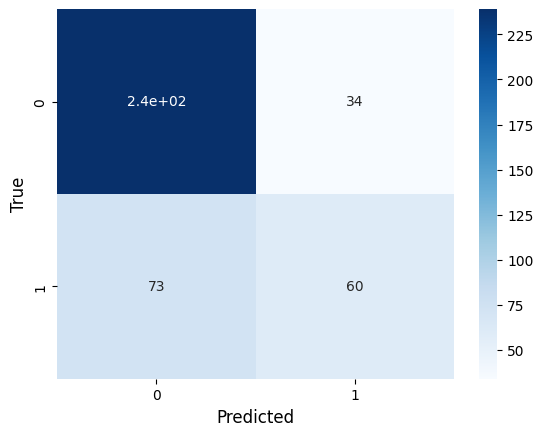

In [ ]:

from sklearn.metrics import brier_score_loss

'''RFC_model_offshore = RandomForestClassifier(n_estimators=500,  criterion='entropy', max_features='auto',
                                 bootstrap=True, n_jobs=1,
                                 random_state=9)'''


gradient_booster = GradientBoostingClassifier(learning_rate=0.1, random_state=39)
gradient_booster.fit(X_train_limited, y_train_offshore)
y_pred_offshore = gradient_booster.predict(X_test_limited)

#RFC_model_offshore.fit(X_train_limited, y_train_offshore.values.ravel())
#y_pred_offshore = RFC_model_offshore.predict(X_test_limited)

#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(gradient_booster.score(X_test_limited, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = gradient_booster.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = gradient_booster.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

Text(0.5, 0, 'Xgboost Feature Importance')

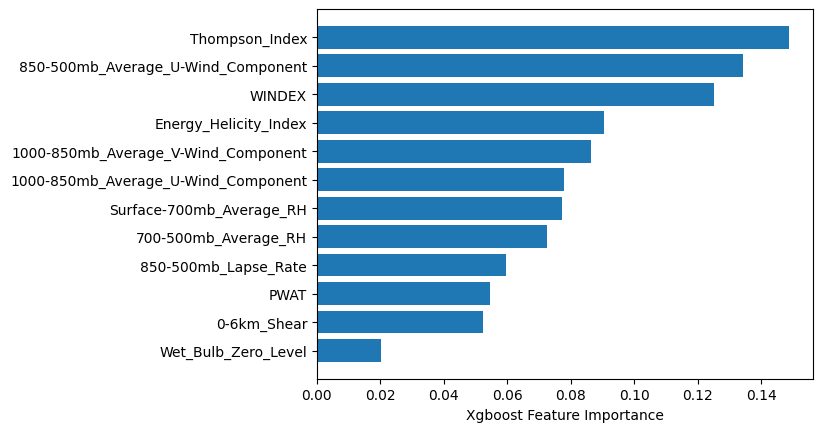

In [ ]:
sorted_idx = gradient_booster.feature_importances_.argsort()
plt.barh(gradient_booster.feature_names_in_[sorted_idx], gradient_booster.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
#index = RFC_model_offshore.feature_names_in_

In [ ]:
# prompt: On the cell's above gradient booster model gradient_booster, perform a hyperparamter sweep that minimizes the Brier score

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(gradient_booster, param_grid, scoring='neg_brier_score', cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_limited, y_train_offshore)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_limited)

# Evaluate the model
brier_score = brier_score_loss(y_test_limited, y_pred)
print("Brier score:", brier_score)

# Print the best Brier score
print("Best Brier score:", grid_search.best_score_)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


KeyboardInterrupt: 

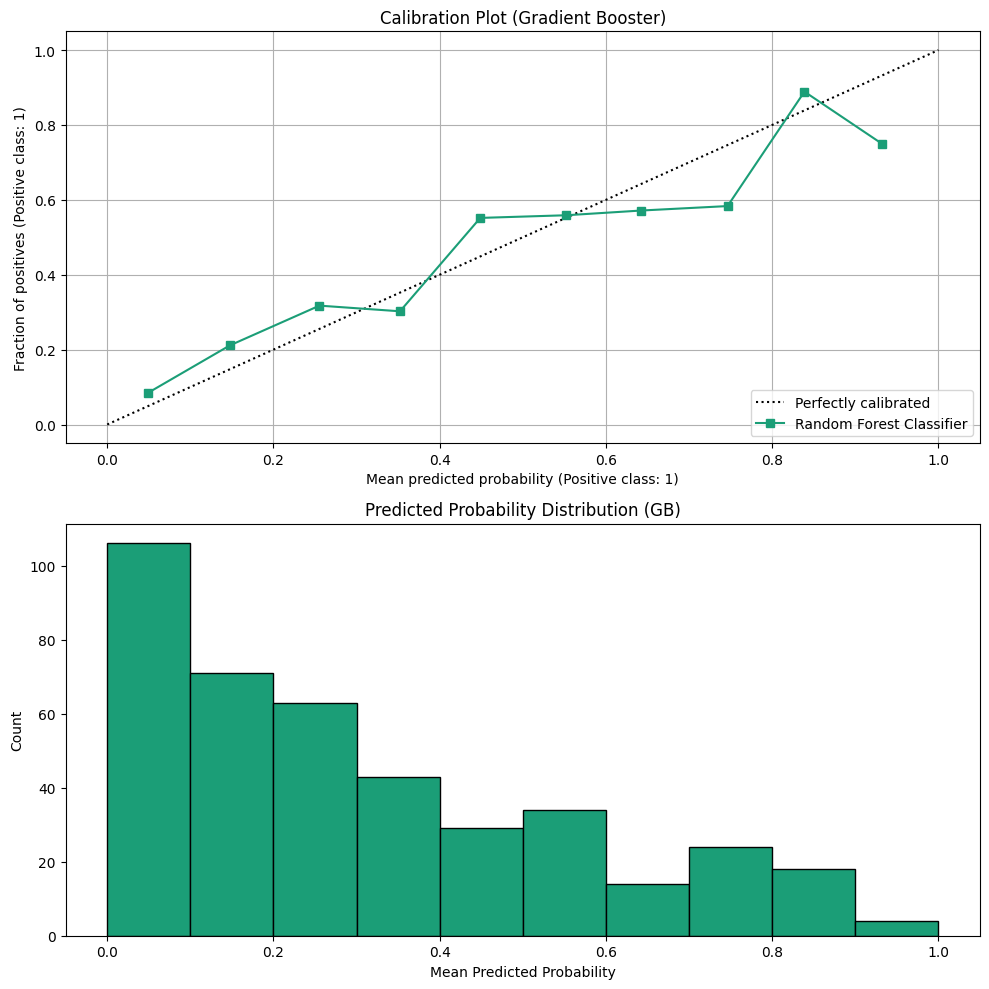

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

# Generate predictions
y_prob = gradient_booster.predict_proba(X_test_limited)[:, 1]  # Probability for the positive class

# Create figure and grid
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
color = plt.cm.Dark2(0)  # Single color for the RFC plot

# Calibration curve plot
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
CalibrationDisplay.from_predictions(
    y_test_offshore,
    y_prob,
    n_bins=10,
    name="Random Forest Classifier",
    ax=ax_calibration_curve,
    color=color,
)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Gradient Booster)")

# Histogram plot
ax_hist = fig.add_subplot(gs[2:, :])
ax_hist.hist(
    y_prob,
    range=(0, 1),
    bins=10,
    color=color,
    edgecolor='black'
)
ax_hist.set(
    title="Predicted Probability Distribution (GB)",
    xlabel="Mean Predicted Probability",
    ylabel="Count"
)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
#from sklearn.naive_bayes import GaussianNB

# With no calibration
prob_no_calib = gradient_booster.predict_proba(X_test_limited)[:, 1]

# With isotonic calibration
GB_isotonic = CalibratedClassifierCV(gradient_booster, cv=5, method="isotonic")
GB_isotonic.fit(X_train_limited, y_train_offshore)
prob_pos_isotonic = GB_isotonic.predict_proba(X_test_limited)[:, 1]

# With sigmoid calibration
GB_sigmoid = CalibratedClassifierCV(gradient_booster, cv=5, method="sigmoid")
GB_sigmoid.fit(X_train_limited, y_train_offshore)
prob_pos_sigmoid = GB_sigmoid.predict_proba(X_test_limited)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test_offshore, prob_no_calib)
print("No calibration: %1.3f" % clf_score)

GB_isotonic_score = brier_score_loss(y_test_offshore, prob_pos_isotonic)
print("With isotonic calibration: %1.3f" % GB_isotonic_score)

GB_sigmoid_score = brier_score_loss(y_test_offshore, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % GB_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.175
With isotonic calibration: 0.172
With sigmoid calibration: 0.174


# Support Vector Machine

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



---Test Set Accuracy
0.6707920792079208

---Brier Score
0.17969146289546326

---Brier Skill Score
0.18629202320784066

---Confusion Matrix
[[271   0]
 [133   0]]

---Classification Report
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       271
           1       0.00      0.00      0.00       133

    accuracy                           0.67       404
   macro avg       0.34      0.50      0.40       404
weighted avg       0.45      0.67      0.54       404


Test confusion_matrix


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(50.722222222222214, 0.5, 'True')

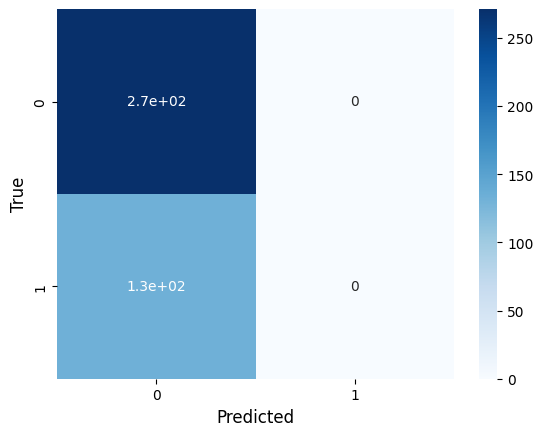

In [91]:
from sklearn import svm




# create an instance of SVC
svc = svm.SVC( C=1500, # regularization
               kernel='rbf', # radial or gaussian kernel
               random_state=101,
               probability=True) # predict probabilities

svc.fit(X_train_limited, y_train_offshore) # fit data to SVC
y_pred_offshore = svc.predict(X_test_limited) # predict using same data



#Print Test Set Accuracy
print("\n---Test Set Accuracy")
print(svc.score(X_test_limited, y_test_offshore))

#Print Brier Score
print("\n---Brier Score")
# predict probabilities
probs = svc.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score
brier_raw = brier_score_loss(y_test_offshore, probs)
print(brier_raw)

#Print Brier Skill Score
print("\n---Brier Skill Score")
# predict probabilities
probs = svc.predict_proba(X_test_limited)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate bier score

offshore_severe_pct_array = np.full(len(y_test_offshore), offshore_severe_pct)
brier_climo = brier_score_loss(y_test_offshore, offshore_severe_pct_array)
BSS = 1 - (brier_raw / brier_climo)
print(BSS)

#Confusion Matrix
print("\n---Confusion Matrix")
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_offshore, y_pred_offshore)
print(confusion_matrix)

#Classification Report
print("\n---Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test_offshore, y_pred_offshore))

# Make the confusion matrix

#cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)



# Conclusion

After testing several variations of logistic regression, decision trees, Random Forests, Gradient Boosters, and Support Vector Machines, the various models, I have decided to select a Random Forest model. For the version I selected I used a limited subset of the features based on several feature importance metrics. I chose class weights to be balanced, and then I further calibrated the probailistic output with isontonic calibration. This gave the lowest (best) brier score, and most reliable probabilistic outputs. I plan on implementing this model for the upcoming summer thunderstorm season to help forecast high impact weather for space launch at Cape Canaveral!